<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_header.png' alt="stsci_logo" width="900px"/> 

# NIRSpec MOS Pipeline Notebook

**Authors**: Dan Coe (dcoe@stsci.edu), NIRSpec branch, with contributions from the NIRSpec team, including Elena Manjavacas, Peter Zeidler, Kayli Glidic, Melanie Clarke, James Muzerolle, Nikolay Nikolov, Chris Hayes, and Alaina Henry, who designed the ERO NIRSpec observations.<br>
**Last Updated**: January 12, 2024 </br>
**Pipeline Version**: 1.17.1 (Build 11.2, Context jwst_1322.pmap)

**Purpose**:<br>
End-to-end calibration with the James Webb Space Telescope (JWST) pipeline is divided into three main processing stages. This notebook provides a framework for processing generic Near-Infrared Spectrograph (NIRSpec) multi-object spectroscopy (MOS) data through [stages 1-3 of the JWST pipeline](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/stages-of-jwst-data-processing#gsc.tab=0), including how to use associations for multi-exposure observations and how to interact and work with JWST datamodels. Data is assumed to be organized into two folders: science and associations, as specified in the paths set up below. In most cases, editing cells outside the [Configuration](#1.-Configuration) section is unnecessary unless the standard pipeline processing options or plot parameters need to be modified.

**[Data](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))**:<br>
This notebook is set up to use observations of galaxy cluster SMACS0723 with the G395M grism obtained by Proposal ID (PID) 2736, Observation 7. The demo data will automatically download unless disabled (i.e., to use local files instead).

**[JWST pipeline version and CRDS context](#Set-CRDS-Context-and-Server)**:<br>
This notebook was written for the above-specified pipeline version and associated build context for this version of the JWST Calibration Pipeline. Information about this and other contexts can be found in the JWST Calibration Reference Data System (CRDS [server](https://jwst-crds.stsci.edu/)). If you use different pipeline versions, please refer to the table [here](https://jwst-crds.stsci.edu/display_build_contexts/) to determine what context to use. To learn more about the differences for the pipeline, read the relevant [documentation](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/jwst-operations-pipeline-build-information#references).<br>

Please note that pipeline software development is a continuous process, so results in some cases may be slightly different if a subsequent version is used. **For optimal results, users are strongly encouraged to reprocess their data using the most recent pipeline version and [associated CRDS context](https://jwst-crds.stsci.edu/display_build_contexts/), taking advantage of bug fixes and algorithm improvements.**
Any [known issues](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues/nirspec-mos-known-issues#NIRSpecFSKnownIssues-Resamplingof2-Dspectra&gsc.tab=0:~:text=MOS%20Known%20Issues-,NIRSpec%20MOS%20Known%20Issues,-Known%20issues%20specific) for this build are noted in the notebook. 

**Updates**:<br>
This notebook is regularly updated to incorporate the latest pipeline improvements. Find the most up-to-date version of this notebook [here](https://github.com/spacetelescope/jwst-pipeline-notebooks/).

**Recent Changes**:</br>
* October 15, 2024: Converted notebook to follow standard template ([original](https://github.com/dancoe/NIRSpec/blob/main/NIRSpec%20MOS%20pipeline.ipynb)). </br>
* November 4, 2024: Notebook updated to JWST pipeline version 1.16.0 (Build 11.1).
* January 12, 2024: Added an example for association file creation.
* February 19, 2025: Updated JWST pipeline version 1.17.1 (Build 11.2). Changed code to create all associations instead of using the MAST downloads.
---

## Table of Contents

* [1. Configuration](#1.-Configuration)
* [2. Package Imports](#2.-Package-Imports)
* [3. Demo Mode Setup](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))
* [4. Directory Setup](#4.-Directory-Setup)
* [5. Stage 1: `Detector1Pipeline` (`calwebb_detector1`)](#5.-Stage-1:-Detector1Pipeline-(calwebb_detector1))
    * [5.1 Configure `Detector1Pipeline`](#5.1-Configure-Detector1Pipeline)
    * [5.2 Run `Detector1Pipeline`](#5.2-Run-Detector1Pipeline)
* [6. Stage 2: `Spec2Pipeline` (`calwebb_spec2`)](#5.-Stage-2:-Spec2Pipeline-(calwebb_spec2))
    * [6.1 Configure `Spec2Pipeline`](#6.1-Configure-Spec2Pipeline)
    * [6.2 Create `Spec2Pipeline` Association Files](#6.2-Create-Spec2Pipeline-Association-Files)
    * [6.3 MSA Metadata File](#6.3-MSA-Metadata-File)
    * [6.4 Run `Spec2Pipeline`](#6.4-Run-Spec2Pipeline)
* [7. Stage 3: `Spec3Pipeline` (`calwebb_spec3`)](#5.-Stage-3:-Spec3Pipeline-(calwebb_spec3))
    * [7.1 Configure `Spec3Pipeline`](#7.1-Configure-Spec3Pipeline)
    * [7.2 Create `Spec3Pipeline` Association Files](#7.2-Create-Spec3Pipeline-Association-Files)
    * [7.3 Run `Spec3Pipeline`](#7.3-Run-Spec3Pipeline)
* [8. Visualize the Data](#8.-Visualize-the-Data)
    * [8.1 Display `Detector1Pipeline` Products](#8.1-Display-Detector1Pipeline-Products)
    * [8.2 Display `Spec2Pipeline` Products](#8.2-Display-Spec2Pipeline-Products)
    * [8.3 Display `Spec3Pipeline` Products](#8.3-Display-Spec3Pipeline-Products)
* [9. Modifying the EXTRACT1D Reference File (as needed)](#9.-Modifying-the-EXTRACT1D-Reference-File-(as-needed))
---

## 1. Configuration

#### Install dependencies and parameters
To make sure that the pipeline version is compatible with the steps discussed below and that the required dependencies and packages get installed, you can create a fresh conda environment and install the provided requirements.txt file before starting this notebook:

    conda create -n nirspec_mos_pipeline python=3.12
    conda activate nirspec_mos_pipeline
    pip install -r requirements.txt

#### Set the basic parameters to configure the notebook.

These parameters determine what data gets used, where data is located (if already on disk), and the type of background subtraction (if any). The list of parameters includes:
* `demo_mode`:
    * `True`: Downloads example data from the [Barbara A. Mikulski Archive for Space Telescopes (MAST)](https://archive.stsci.edu/) and processes it through the pipeline. All processing will occur in a local directory unless modified in [Section 3](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data)) below.
    * `False`: Process your own downloaded data; provide its location.<br><br>
* **Directories with data**:
    * `sci_dir`: Directory where science observation data is stored.
    * REMOVE `asn_dir`: Directory where Stage 2/3 associations are stored.<br><br>
* **[Backgroud subtraction methods](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-observing-strategies/nirspec-background-recommended-strategies#gsc.tab=0)** (`True` = run, `False` = skip):
    * `master_bg`: Apply master-background subtraction in `calwebb_spec2`? Uses "blank sky" shutters defined in the observation.
    * `pixel_bg` : Apply pixel-to-pixel background subtraction in `calwebb_spec2`.  This is the default pipeline setting. Uses nodded observations.<br><br>

In [1]:
# Basic import necessary for configuration.
# Use logging if hiding logging

import os
import warnings
#import logging

# Control logging level: INFO, WARNING, ERROR
# Run command loging.disable if want to hide logging
# ERROR messages.
#logging.disable(logging.ERROR)
warnings.simplefilter("ignore", RuntimeWarning)

<div class="alert alert-block alert-warning">

Note that `demo_mode` must be set appropriately below.

</div>

In [2]:
# Set parameters for demo_mode, data mode directories, and processing steps.

# -------------------------------DEMO MODE-----------------------------------
demo_mode = True

if demo_mode:
    print('Running in demonstration mode using online example data!')

# ----------------------------User Mode Directories--------------------------
else:  # If demo_mode = False, look for user data in these paths.

    # Set directory paths for processing specific data; adjust to your local
    # directory setup (examples provided below).
    basedir = os.path.abspath(os.path.join(os.getcwd(), ''))

    # Directory to science observation data; expects uncalibrated data in
    # sci_dir/uncal/ and results in stage1, stage2, and stage3 directories.
    sci_dir = os.path.join(basedir, 'mos_data_02736/Obs007', '')

# ---------------------------Set Processing Steps----------------------------
# Individual pipeline stages can be turned on/off here.  Note that a later
# stage won't be able to run unless data products have already been
# produced from the prior stage.

# Science processing.
dodet1 = True  # calwebb_detector1
dospec2 = True  # calwebb_spec2
dospec3 = True  # calwebb_spec3
doviz = True  # Visualize calwebb outputs

# ---------------------------Set Processing Steps----------------------------
# How should background subtraction be done?
# If none are selected, data will not be background subtracted.
# pixel_bg - True for nodded observations
# master_bg - True if using "blank sky" sutters in the science observation.
master_bg = False  # Master-background subtraction in spec3.
pixel_bg = True  # Pixel-based background subtraction in spec2.

Running in demonstration mode using online example data!


---
### Set CRDS Context and Server
Before importing `CRDS` and `JWST` modules, we need to configure our environment. This includes defining a CRDS cache directory in which to keep the reference files that will be used by the calibration pipeline. If the local CRDS cache directory has not been set, it will automatically be created in the home directory.<br><br>
[Build Context Table](https://jwst-crds.stsci.edu/display_build_contexts/)

In [3]:
# ------------------------Set CRDS context and paths------------------------

# Each version of the calibration pipeline is associated with a specific CRDS
# context file. The pipeline will select the appropriate context file behind
# the scenes while running. However, if you wish to override the default context
# file and run the pipeline with a different context, you can set that using
# the CRDS_CONTEXT environment variable. Here we show how this is done,
# although we leave the line commented out in order to use the default context.
# If you wish to specify a different context, uncomment the line below.
#os.environ['CRDS_CONTEXT'] = 'jwst_1298.pmap'  # CRDS context for 1.16.0

# Set CRDS cache directory to user home if not already set.
if os.getenv('CRDS_PATH') is None:
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds_cache')

# Check whether the CRDS server URL has been set. If not, set it.
if os.getenv('CRDS_SERVER_URL') is None:
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Output the current CRDS path and server URL in use.
print('CRDS local filepath:', os.environ['CRDS_PATH'])
print('CRDS file server:', os.environ['CRDS_SERVER_URL'])

CRDS local filepath: /home/runner/crds_cache
CRDS file server: https://jwst-crds.stsci.edu


---
## 2. Package Imports

In [4]:
# Use the entire available screen width for this notebook.
from IPython.display import display, HTML, JSON
display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
# ----------------------General Imports----------------------
import time
import glob
import json
import itertools
import numpy as np
from itertools import combinations

# ----------------------Astropy Imports----------------------
# Astropy utilities for opening FITS files, downloading demo files, etc.
from astropy.io import fits
from astropy.stats import sigma_clip
from astropy.visualization import ImageNormalize, ManualInterval, LogStretch
from astropy.visualization import LinearStretch, AsinhStretch, simple_norm

# -------------------- Astroquery Imports ----------------------
from astroquery.mast import Observations

# ----------------------Plotting Imports---------------------
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

<div class="alert alert-block alert-info">

Installation instructions for the JWST pipeline found here: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview) •
[ReadtheDocs](https://jwst-pipeline.readthedocs.io) •
[Github](https://github.com/spacetelescope/jwst)

</div>

In [6]:
# ----------------------JWST Calibration Pipeline Imports----------------------
import jwst  # Import the base JWST and CRDS packages.
import crds
from crds.client import api
from stpipe import crds_client

# JWST pipelines (each encompassing many steps).
from jwst.pipeline import Detector1Pipeline  # calwebb_detector1
from jwst.pipeline import Spec2Pipeline  # calwebb_spec2
from jwst.pipeline import Spec3Pipeline  # calwebb_spec3
from jwst.extract_1d import Extract1dStep  # Extract1D Step

# JWST pipeline utilities
from jwst import datamodels  # JWST pipeline utilities: datamodels.
from jwst.associations import asn_from_list  # Tools for creating association files.
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base  # Define Lvl3 ASN.

default_context = crds.get_default_context('jwst', state='build')
print("JWST Calibration Pipeline Version = {}".format(jwst.__version__))
print(f"Default CRDS Context for JWST Version {jwst.__version__}: {default_context}")
print(f"Using CRDS Context: {os.environ.get('CRDS_CONTEXT', default_context)}")

CRDS - INFO -  Calibration SW Found: jwst 1.17.1 (/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst-1.17.1.dist-info)


JWST Calibration Pipeline Version = 1.17.1
Default CRDS Context for JWST Version 1.17.1: jwst_1322.pmap
Using CRDS Context: jwst_1322.pmap


---
### Define Convience Functions

Function that identifies unique MSA files.

In [7]:
# Find unique files to download.
def unique_files_to_array(files):
    """
    Checks for unique files and adds them to an array.

    Parameters
    ----------
    files : list of lists
        The input files.

    Returns
    -------
    list: An array of unique files.
    """

    unique_files = set()
    for row in files:
        for element in row:
            if isinstance(element, str):
                unique_files.add(element)

    return list(unique_files)

Define a function to combine the nodded exposures to use as background exposures in for the spec2 associations.
This funtions identify the `rate.fits` observations from the same detector and visit and create all the possible conbinations. 

In [8]:
# Identify and combine the nodded exposures
def group_spec2_asn_bkg_nods(files_l2, nods):

    # Function to split a string into words using underscores
    def split_name(s):
        return s.split('_')

    # Dictionary to store the strings that match the criteria for grouping
    group_obs = {}

    # Process each file to group 'rate.fits' files
    for original_name in files_l2:
        original_dir = os.path.dirname(original_name)
        original_name = os.path.basename(original_name)

        # Split the filename into components
        obs_vals = split_name(original_name)

        # Check if the filename has at least 4 components for grouping
        if len(obs_vals) >= 4 and obs_vals[-1] == 'rate.fits':
            key = (obs_vals[0], obs_vals[1], obs_vals[3], obs_vals[-1])

            # Group files by the key derived from filename components
            if key in group_obs:
                group_obs[key].append(os.path.join(original_dir, original_name))
            else:
                group_obs[key] = [os.path.join(original_dir, original_name)]

    # Convert grouped files into a list of lists
    matrix = list(group_obs.values())

    # Now, process each group to generate associations with background nods
    result = []
    for group in matrix:
        # Extract names from file paths for node association
        names = [file for file in group]

        # Generate associations
        for fixed in names:
            remaining = [os.path.join(original_dir, name) for name in names if name != fixed]
            for pair in combinations(remaining, nods - 1):
                combination = [os.path.join(original_dir, fixed)] + list(pair)
                result.append(combination)

    return result

In [9]:
# Start a timer to keep track of runtime.
time0 = time.perf_counter()

---
## 3. Demo Mode Setup (ignore if not using demo data)
<div class="alert alert-block alert-info">

The data in this notebook is public and does not require a token. For other data sets, you may need to provide a token. For more infomation visit the
[astroquery](https://astroquery.readthedocs.io/en/latest/index.html) documentation.

</div>

If running in demonstration mode, set up the program information to retrieve the uncalibrated data (`_uncal.fits`) automatically from MAST using `astroquery`. MAST provides flexibility by allowing searches based on proposal ID and observation ID, rather than relying solely on filenames. More information about the JWST file naming conventions can be found [here](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html).

The MOS demo data in this notebook is from ["JWST's First Deep Field"](https://webbtelescope.org/contents/news-releases/2022/news-2022-035), [JWST Early Release Observation (ERO) program 2736](https://www.stsci.edu/jwst/science-execution/program-information?id=2736) and features observations of galaxy cluster SMACS0723 with NIRCam, NIRSpec, and MIRI. This program includes two identical MOS observations (7 and 8) with confirmation images taken after target acquisition (20 groups | NRSIRS2RAPID | 306 [s]). More of the program setup is briefly summarized in the table below.

| Demo Target: SMACS0723 |       |   |
|:-----------:|:-------:|:---:|
| PROGRAM | 02736 | Program number |
| OBSERVTN | 007 | Observation number |
| [GRATING/FILTER](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-observing-modes/nirspec-multi-object-spectroscopy#gsc.tab=0:~:text=Table%C2%A01.%20Spectral%20configurations%20available%20in%20NIRSpec%20MOS%20mode) | G395M/F290LP | λ: 2.87–5.10 μm (a medium resolution, R ~ 1000) |
||G235M/F170LP | λ: 1.66–3.07 μm (a medium resolution, R ~ 1000) |
| SUBARRAY | FULL | Subarray used (2048 x 2048) |
| NINTS | 2 | Number of integrations in exposure |
| NGROUPS | 20 | Number of groups in integration |
| READPATT | NRSIRS2 | Readout pattern |
| NOD_TYPE | 3-SHUTTER-SLITLET | Nod pattern type |
| NUMDTHPT | 3 |  Total number of points in pattern |      
| SRCTYAPT | UNKNOWN | Source type selected in APT |
| TOTAL DURATION | NOD_TYPE x NINTS x NGROUPS = 8841 [s] (~2.5 hrs) | Total duration (per grating and observation)|

> **Note:** The presence of a physical gap between detectors affects all MOS observations (any resolution) because the spectra can be long enough to span both NIRSpec detectors. [More Info ...](https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-operations/nirspec-mos-operations/nirspec-mos-wavelength-ranges-and-gaps#gsc.tab=0)

In [10]:
# Set up the program information and directories to collect
# the data in demo_mode.

if demo_mode:

    print('Running in demonstration mode. '
          'Example data will be downloaded from MAST!')

    # NOTE:
    # For non public data sets, you may need to provide a token.
    # However, for security it is not recommended to enter tokens into
    # a terminal or Jupyter notebook.
    #Observations.login(token="your-token")

    # --------------Program and observation information--------------
    program = "02736"
    sci_observtn = "007"
    filters = ["F290LP;G395M"]
    number_nods = 3  # Number of nodded positions

    # ----------Define the base and observation directories----------
    basedir = os.path.join(os.getcwd(), f'mos_data_{program}')
    sci_dir = os.path.join(basedir, f'Obs{sci_observtn}')
    asn_dir = os.path.join(sci_dir, 'asn/') # Keep MSA files in the association directory
    uncal_dir = os.path.join(sci_dir, 'uncal/')

    # ----Ensure directories for downloading MAST data exists--------
    os.makedirs(uncal_dir, exist_ok=True)
    os.makedirs(asn_dir, exist_ok=True)

Running in demonstration mode. Example data will be downloaded from MAST!


<br>Click on the following links to learn more about querying and downloading data:<br>
• [Downloading data](https://astroquery.readthedocs.io/en/latest/mast/mast_obsquery.html#downloading-data)<br>
• [Observations Class](https://astroquery.readthedocs.io/en/latest/api/astroquery.mast.ObservationsClass.html)<br>
• [Products Field Descriptions](https://mast.stsci.edu/api/v0/_productsfields.html)<br><br>

Compile a table of files from MAST associated with the science (SCI) observation.

In [11]:
# Obtain a list of observation IDs for the specified demo program.

if demo_mode:
    # --------------------SCIENCE Observation--------------------
    sci_obs_id_table = Observations.query_criteria(instrument_name=['NIRSPEC/MSA'],
                                                   provenance_name=["CALJWST"],
                                                   obs_id=[f'*{program}*{sci_observtn}*'])

Filter these tables to identify uncalibrated data, metadata, and association files to download from MAST.

The demo dataset consists of six `_uncal.fits` files, each approximately 500 MB in size.

In [12]:
# Convert visits into a list of uncalibrated data and ASN files.

if demo_mode:

    file_criteria = {'filters': filters, 'calib_level': [1],
                     'productSubGroupDescription': 'UNCAL'}

    # Initialize lists for science, background, and ASN files.
    sci_downloads, msa_downloads = [], []

    pfilter = Observations.filter_products  # Alias for filter_products method.

    # ----Identify uncalibrated SCIENCE files associated with each visit-----
    for exposure in sci_obs_id_table:
        sci_products = Observations.get_product_list(exposure)

        # Filter for full-size science files (exclude smaller confirmation images).
        avg_sci_size = np.nanmean(sci_products['size'])
        sci_products_avg = sci_products[sci_products['size'] > avg_sci_size]
        sci_downloads.extend(pfilter(sci_products_avg, **file_criteria)['dataURI'])

        # Identifies association metadata files.
        msa_files = {
            f['productFilename'] for f in sci_products
            if 'AUXILIARY' in f['productType'] and 'metadata' in f['description']}
        msa_downloads.append(msa_files)

    # Filter out other observations and remove duplicates.
    msa_downloads = unique_files_to_array(msa_downloads)
    sci_downloads = {f for f in sci_downloads if f"jw{program}{sci_observtn}" in f}

    msa_mast_downloads = [
        f"mast:JWST/product/{f}" for f in msa_downloads
        if f"jw{program}{sci_observtn}" in f
    ]

    print(f"Science files selected for downloading: {len(sci_downloads)}")
    print(f"MSA files selected for downloading: {len(msa_mast_downloads)}")

Science files selected for downloading: 6
MSA files selected for downloading: 1


Download the data.

<div class="alert alert-block alert-warning">
Warning: If this notebook is halted during this step, the downloaded file may be incomplete, and cause crashes later on!
</div>

In [13]:
# Download data and place them into the appropriate directories.

if demo_mode:
    for file in sci_downloads:
        sci_manifest = Observations.download_file(file, local_path=uncal_dir)
    for file in msa_mast_downloads:
        msa_manifest = Observations.download_file(file, local_path=asn_dir)

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


---
### Galaxies of Interest
There are several galaxies of interest in the demo data. Here we will look at some of them (source_ids provided below).

* **6355**: z = 7.665 (13.0 Gyr ago)
    * We'll look at this galaxy in this notebook.
    * Excellent spectrum with bright lines.
    * 5-shutter slitlet (rather than standard 3-shutter slitlet), so 1D extraction can be improved significantly.
    * Not a multiple image of 10612 (described below), which has a similar redshift.

* 5144: z = 6.383 (12.8 Gyr ago)

The following galaxies have been featured in the [press release](https://webbtelescope.org/contents/news-releases/2022/news-2022-035):
*  4590: z = 8.498 (13.1 Gyr ago)
* 10612: z = 7.663 (13.0 Gyr ago)
*  8140: z = 5.275 (12.6 Gyr ago)
*  9922: z = 2.743 (11.3 Gyr ago)

and presented and studied in papers including
[Katz et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.518..592K),
[Curti et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.518..425C),
[Carnall et al. 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.518L..45C).

---
## 4. Directory Setup
Set up detailed paths to input/output stages here.

In [14]:
# Define/create output subdirectories to keep data products organized.

# -----------------------------Science Directories------------------------------
uncal_dir = os.path.join(sci_dir, 'uncal/')  # Uncalibrated pipeline inputs.
det1_dir = os.path.join(sci_dir, 'stage1/')  # calwebb_detector1 pipeline outputs.
spec2_dir = os.path.join(sci_dir, 'stage2/')  # calwebb_spec2 pipeline outputs.
spec3_dir = os.path.join(sci_dir, 'stage3/')  # calwebb_spec3 pipeline outputs.
asn_dir = os.path.join(sci_dir, 'asn/')  # Associations directory

# Creates the directories if target directory does not exist
os.makedirs(det1_dir, exist_ok=True)
os.makedirs(spec2_dir, exist_ok=True)
os.makedirs(spec3_dir, exist_ok=True)
os.makedirs(asn_dir, exist_ok=True)

In [15]:
# Print out the time benchmark.
time1 = time.perf_counter()
print(f"Runtime so far: {round((time1 - time0) / 60.0, 1):0.4f} min")

Runtime so far: 11.9000 min


---
## 5. Stage 1: `Detector1Pipeline` (`calwebb_detector1`)
In this section, we process the data through the `calwebb_detector1` pipeline to create Stage 1 [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html).

* **Input**: Raw exposure (`_uncal.fits`) containing original data from all detector readouts (ncols x nrows x ngroups x nintegrations).
* **Output**: Uncalibrated countrate (slope) image in units of DN/s:
    * `_rate.fits`: A single countrate image averaged over multiple integrations (if available).
    * `_rateints.fits`: Countrate images for each integration, saved in multiple extensions.

The `Detector1Pipeline` applies basic detector-level corrections on a group-by-group basis, followed by ramp fitting for all exposure types, commonly referred to as "ramps-to-slopes" processing.

---

### 5.1 Configure `Detector1Pipeline`

The `Detector1Pipeline` has the following steps available for NIRSpec MOS:

* `group_scale` : Rescales pixel values to correct for improper onboard frame averaging.
* `dq_init` : Initializes the data quality (DQ) flags for the input data.
* `saturation` : Flags pixels at or below the A/D floor or above the saturation threshold.
* `superbias` : Subtracts the superbias reference file from the input data.
* `refpix` : Use reference pixels to correct bias drifts.
* `linearity` : Applies a correction for non-linear detector response.
* `dark_current` : Subtracts the dark current reference file from the input data.
* `jump` : Performs CR/jump detection on each ramp integration within an exposure.
* `clean_flicker_noise`: Removes flicker (1/f) noise from calibrated ramp images (similar to `nsclean` in spec2).
* `ramp_fit` : Determines the mean count rate (counts per second) for each pixel by performing a linear fit to the input data.
* `gain_scale` : Corrects pixel values for non-standard gain settings, primarily in NIRSpec subarray data.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1) and
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/stable/jwst/pipeline/calwebb_detector1.html)

Below, we set up a dictionary that defines how the `Detector1Pipeline` should be configured for MOS data. We follow the [CEERS NIRSpec reduction parameters](https://web.corral.tacc.utexas.edu/ceersdata/DR07/NIRSpec/README_NIRSpec_DR0.7.txt) to improve the rejection of cosmic rays and snowballs during the `jump` step.

<div class="alert alert-warning">
To override specific steps and reference files, use the examples below.
</div>

In [16]:
# Set up a dictionary to define how the Detector1 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
det1dict = {}
det1dict['group_scale'], det1dict['dq_init'], det1dict['saturation'] = {}, {}, {}
det1dict['superbias'], det1dict['refpix'] = {}, {}
det1dict['linearity'], det1dict['dark_current'], det1dict['jump'] = {}, {}, {}
det1dict['clean_flicker_noise'], det1dict['ramp_fit'] = {}, {}
det1dict['gain_scale'] = {}

# ---------------------------Override reference files---------------------------

# Overrides for various reference files (example).
# Files should be in the base local directory or provide full path.
#det1dict['dq_init']['override_mask'] = 'myfile.fits'  # Bad pixel mask
#det1dict['superbias']['override_superbias'] = 'myfile.fits'  # Bias subtraction
#det1dict['dark_current']['override_dark'] = 'myfile.fits'  # Dark current subtraction

# -----------------------------Set step parameters------------------------------

# Overrides for whether or not certain steps should be skipped (example).
det1dict['linearity']['skip'] = False  # This is the default.

# Turn on multi-core processing (off by default).
# Choose what fraction of cores to use (quarter, half, or all).
det1dict['jump']['maximum_cores'] = 'half'
#det1dict['ramp_fit']['maximum_cores'] = 'half'

In [17]:
# Turn on detection of cosmic ray snowballs (on by default).
# and change some parameters
det1dict['jump']['expand_large_events'] = True
det1dict['jump']['expand_factor'] = 3  # (default 2)
det1dict['jump']['min_sat_area'] = 15  # (default 1).
det1dict['jump']['min_jump_area'] = 15  # (default 5)

<div class="alert alert-info">

Many exposures are affected by artifacts known as [snowballs](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/shower-and-snowball-artifacts#gsc.tab=0) caused by large cosmic ray events. These artifacts are particularly significant in deep exposures with long integration times, with an estimated rate of one snowball per detector (FULL FRAME) per 20 seconds. To expand the number of pixels flagged as jumps around large cosmic ray events, set `expand_large_events` to True. An `expand_factor` of 3 works well for NIRSpec observations to cover most snowballs.

</div>

In [18]:
# Turn on 1/f noise correction in Stage 1? (off by default).
det1dict['clean_flicker_noise']['skip'] = True

<div class="alert alert-info">

JWST detector readout electronics (a.k.a. SIDECAR ASICs) generate significant 1/f noise during detector operations and signal digitization. This noise manifests as faint banding along the detector's slow axis and varies from column to column. For NIRSpec data, the primary pipeline algorithm to address 1/f noise is `nsclean` in the `Spec2Pipeline` (Rauscher 2023) but is off by default.

An additional 1/f noise-cleaning algorithm, `clean_flicker_noise`, has been implemented at the group stage in the `Detector1Pipeline`. This step is also off by default.

</div>

---
### 5.2 Run `Detector1Pipeline`
Run the science files through the `calwebb_detector1` pipeline using the `.call()` method.

We use `.call()` instead of `.run()` to ensure that the latest default parameters set via reference files in CRDS are applied ([ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/stpipe/call_via_run.html)).

This stage takes approximately 25 minutes to process six `_uncal.fits` files (~4 minutes per file) and generate `_rate.fits` files.

In [19]:
# Final list of UNCAL files ready for Stage 1 processing.
uncal_sci = sorted(glob.glob(uncal_dir + '*uncal.fits'))
print(f"Science UNCAL Files:\n{'-' * 20}\n" + "\n".join(uncal_sci))

Science UNCAL Files:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00001_nrs1_uncal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00001_nrs2_uncal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00002_nrs1_uncal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00002_nrs2_uncal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00003_nrs1_uncal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00003_nrs2_uncal.fits


In [20]:
time_det1 = time.perf_counter()  # Tracks runtime for Stage 1.

In [21]:
# Run Stage 1 pipeline using the custom det1dict dictionary.

if dodet1:
    # --------------------------Science UNCAL files--------------------------
    for uncal_file in uncal_sci:
        print(f"Applying Stage 1 Corrections & Calibrations to: "
              f"{os.path.basename(uncal_file)}")

        det1_result = Detector1Pipeline.call(uncal_file,
                                             save_results=True,
                                             steps=det1dict,
                                             output_dir=det1_dir)
    print("Stage 1 has been completed! \n")
else:
    print('Skipping Detector1 processing for SCI data.')

Applying Stage 1 Corrections & Calibrations to: jw02736007001_03103_00001_nrs1_uncal.fits


2025-03-04 22:30:20,236 - CRDS - INFO -  Calibration SW Found: jwst 1.17.1 (/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst-1.17.1.dist-info)


2025-03-04 22:30:20,534 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_system_datalvl_0002.rmap      694 bytes  (1 / 202 files) (0 / 722.8 K bytes)


2025-03-04 22:30:20,619 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_system_calver_0046.rmap    5.2 K bytes  (2 / 202 files) (694 / 722.8 K bytes)


2025-03-04 22:30:20,675 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_system_0045.imap      385 bytes  (3 / 202 files) (5.9 K / 722.8 K bytes)


2025-03-04 22:30:20,770 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_wavelengthrange_0024.rmap    1.4 K bytes  (4 / 202 files) (6.3 K / 722.8 K bytes)


2025-03-04 22:30:20,858 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_wavecorr_0005.rmap      884 bytes  (5 / 202 files) (7.7 K / 722.8 K bytes)


2025-03-04 22:30:20,917 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_superbias_0074.rmap   33.8 K bytes  (6 / 202 files) (8.5 K / 722.8 K bytes)


2025-03-04 22:30:21,111 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_sflat_0026.rmap   20.6 K bytes  (7 / 202 files) (42.3 K / 722.8 K bytes)


2025-03-04 22:30:21,190 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_saturation_0018.rmap    2.0 K bytes  (8 / 202 files) (62.9 K / 722.8 K bytes)


2025-03-04 22:30:21,256 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_refpix_0015.rmap    1.6 K bytes  (9 / 202 files) (64.9 K / 722.8 K bytes)


2025-03-04 22:30:21,331 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_readnoise_0025.rmap    2.6 K bytes  (10 / 202 files) (66.5 K / 722.8 K bytes)


2025-03-04 22:30:21,500 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_photom_0013.rmap      958 bytes  (11 / 202 files) (69.1 K / 722.8 K bytes)


2025-03-04 22:30:21,599 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pathloss_0008.rmap    1.2 K bytes  (12 / 202 files) (70.0 K / 722.8 K bytes)


2025-03-04 22:30:21,771 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-whitelightstep_0001.rmap      777 bytes  (13 / 202 files) (71.2 K / 722.8 K bytes)


2025-03-04 22:30:21,849 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-spec2pipeline_0013.rmap    2.1 K bytes  (14 / 202 files) (72.0 K / 722.8 K bytes)


2025-03-04 22:30:21,935 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-resamplespecstep_0002.rmap      709 bytes  (15 / 202 files) (74.1 K / 722.8 K bytes)


2025-03-04 22:30:22,025 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-outlierdetectionstep_0005.rmap    1.1 K bytes  (16 / 202 files) (74.8 K / 722.8 K bytes)


2025-03-04 22:30:22,089 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-jumpstep_0005.rmap      810 bytes  (17 / 202 files) (76.0 K / 722.8 K bytes)


2025-03-04 22:30:22,150 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-image2pipeline_0008.rmap    1.0 K bytes  (18 / 202 files) (76.8 K / 722.8 K bytes)


2025-03-04 22:30:22,219 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-detector1pipeline_0003.rmap    1.1 K bytes  (19 / 202 files) (77.8 K / 722.8 K bytes)


2025-03-04 22:30:22,302 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-darkpipeline_0003.rmap      872 bytes  (20 / 202 files) (78.8 K / 722.8 K bytes)


2025-03-04 22:30:22,375 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_pars-darkcurrentstep_0001.rmap      622 bytes  (21 / 202 files) (79.7 K / 722.8 K bytes)


2025-03-04 22:30:22,444 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ote_0030.rmap    1.3 K bytes  (22 / 202 files) (80.3 K / 722.8 K bytes)


2025-03-04 22:30:22,524 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_msaoper_0016.rmap    1.5 K bytes  (23 / 202 files) (81.6 K / 722.8 K bytes)


2025-03-04 22:30:22,598 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_msa_0027.rmap    1.3 K bytes  (24 / 202 files) (83.1 K / 722.8 K bytes)


2025-03-04 22:30:22,665 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_mask_0039.rmap    2.7 K bytes  (25 / 202 files) (84.3 K / 722.8 K bytes)


2025-03-04 22:30:22,741 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_linearity_0017.rmap    1.6 K bytes  (26 / 202 files) (87.0 K / 722.8 K bytes)


2025-03-04 22:30:22,808 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ipc_0006.rmap      876 bytes  (27 / 202 files) (88.6 K / 722.8 K bytes)


2025-03-04 22:30:22,873 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ifuslicer_0017.rmap    1.5 K bytes  (28 / 202 files) (89.5 K / 722.8 K bytes)


2025-03-04 22:30:22,960 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ifupost_0019.rmap    1.5 K bytes  (29 / 202 files) (91.0 K / 722.8 K bytes)


2025-03-04 22:30:23,029 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_ifufore_0017.rmap    1.5 K bytes  (30 / 202 files) (92.5 K / 722.8 K bytes)


2025-03-04 22:30:23,099 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_gain_0023.rmap    1.8 K bytes  (31 / 202 files) (94.0 K / 722.8 K bytes)


2025-03-04 22:30:23,167 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_fpa_0028.rmap    1.3 K bytes  (32 / 202 files) (95.7 K / 722.8 K bytes)


2025-03-04 22:30:23,232 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_fore_0026.rmap    5.0 K bytes  (33 / 202 files) (97.0 K / 722.8 K bytes)


2025-03-04 22:30:23,300 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_flat_0015.rmap    3.8 K bytes  (34 / 202 files) (102.0 K / 722.8 K bytes)


2025-03-04 22:30:23,361 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_fflat_0026.rmap    7.2 K bytes  (35 / 202 files) (105.8 K / 722.8 K bytes)


2025-03-04 22:30:23,452 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_extract1d_0018.rmap    2.3 K bytes  (36 / 202 files) (113.0 K / 722.8 K bytes)


2025-03-04 22:30:23,512 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_disperser_0028.rmap    5.7 K bytes  (37 / 202 files) (115.3 K / 722.8 K bytes)


2025-03-04 22:30:23,569 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_dflat_0007.rmap    1.1 K bytes  (38 / 202 files) (121.0 K / 722.8 K bytes)


2025-03-04 22:30:23,636 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_dark_0069.rmap   32.6 K bytes  (39 / 202 files) (122.1 K / 722.8 K bytes)


2025-03-04 22:30:23,721 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_cubepar_0015.rmap      966 bytes  (40 / 202 files) (154.7 K / 722.8 K bytes)


2025-03-04 22:30:23,819 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_collimator_0026.rmap    1.3 K bytes  (41 / 202 files) (155.7 K / 722.8 K bytes)


2025-03-04 22:30:23,891 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_camera_0026.rmap    1.3 K bytes  (42 / 202 files) (157.0 K / 722.8 K bytes)


2025-03-04 22:30:23,959 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_barshadow_0007.rmap    1.8 K bytes  (43 / 202 files) (158.3 K / 722.8 K bytes)


2025-03-04 22:30:24,081 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_area_0018.rmap    6.3 K bytes  (44 / 202 files) (160.1 K / 722.8 K bytes)


2025-03-04 22:30:24,145 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_apcorr_0009.rmap    5.6 K bytes  (45 / 202 files) (166.4 K / 722.8 K bytes)


2025-03-04 22:30:24,209 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nirspec_0387.imap    5.7 K bytes  (46 / 202 files) (171.9 K / 722.8 K bytes)


2025-03-04 22:30:24,279 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_wfssbkg_0008.rmap    3.1 K bytes  (47 / 202 files) (177.7 K / 722.8 K bytes)


2025-03-04 22:30:24,337 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_wavemap_0008.rmap    2.2 K bytes  (48 / 202 files) (180.8 K / 722.8 K bytes)


2025-03-04 22:30:24,398 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_wavelengthrange_0006.rmap      862 bytes  (49 / 202 files) (183.0 K / 722.8 K bytes)


2025-03-04 22:30:24,464 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_trappars_0004.rmap      753 bytes  (50 / 202 files) (183.9 K / 722.8 K bytes)


2025-03-04 22:30:24,531 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_trapdensity_0005.rmap      705 bytes  (51 / 202 files) (184.6 K / 722.8 K bytes)


2025-03-04 22:30:24,596 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_throughput_0005.rmap    1.3 K bytes  (52 / 202 files) (185.3 K / 722.8 K bytes)


2025-03-04 22:30:24,665 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_superbias_0030.rmap    7.4 K bytes  (53 / 202 files) (186.6 K / 722.8 K bytes)


2025-03-04 22:30:24,785 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_specwcs_0014.rmap    3.1 K bytes  (54 / 202 files) (194.0 K / 722.8 K bytes)


2025-03-04 22:30:24,864 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_spectrace_0008.rmap    2.3 K bytes  (55 / 202 files) (197.1 K / 722.8 K bytes)


2025-03-04 22:30:24,921 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_specprofile_0008.rmap    2.4 K bytes  (56 / 202 files) (199.5 K / 722.8 K bytes)


2025-03-04 22:30:24,988 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_speckernel_0006.rmap    1.0 K bytes  (57 / 202 files) (201.8 K / 722.8 K bytes)


2025-03-04 22:30:25,054 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_saturation_0015.rmap      829 bytes  (58 / 202 files) (202.9 K / 722.8 K bytes)


2025-03-04 22:30:25,130 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_readnoise_0011.rmap      987 bytes  (59 / 202 files) (203.7 K / 722.8 K bytes)


2025-03-04 22:30:25,194 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_photom_0036.rmap    1.3 K bytes  (60 / 202 files) (204.7 K / 722.8 K bytes)


2025-03-04 22:30:25,261 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_persat_0007.rmap      674 bytes  (61 / 202 files) (205.9 K / 722.8 K bytes)


2025-03-04 22:30:25,330 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pathloss_0003.rmap      758 bytes  (62 / 202 files) (206.6 K / 722.8 K bytes)


2025-03-04 22:30:25,387 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pastasoss_0004.rmap      818 bytes  (63 / 202 files) (207.4 K / 722.8 K bytes)


2025-03-04 22:30:25,452 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-undersamplecorrectionstep_0001.rmap      904 bytes  (64 / 202 files) (208.2 K / 722.8 K bytes)


2025-03-04 22:30:25,519 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-tweakregstep_0012.rmap    3.1 K bytes  (65 / 202 files) (209.1 K / 722.8 K bytes)


2025-03-04 22:30:25,583 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-spec2pipeline_0008.rmap      984 bytes  (66 / 202 files) (212.2 K / 722.8 K bytes)


2025-03-04 22:30:25,653 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-sourcecatalogstep_0002.rmap    2.3 K bytes  (67 / 202 files) (213.2 K / 722.8 K bytes)


2025-03-04 22:30:25,709 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-resamplestep_0002.rmap      687 bytes  (68 / 202 files) (215.5 K / 722.8 K bytes)


2025-03-04 22:30:25,804 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-outlierdetectionstep_0004.rmap    2.7 K bytes  (69 / 202 files) (216.2 K / 722.8 K bytes)


2025-03-04 22:30:25,871 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-jumpstep_0007.rmap    6.4 K bytes  (70 / 202 files) (218.9 K / 722.8 K bytes)


2025-03-04 22:30:25,935 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-image2pipeline_0005.rmap    1.0 K bytes  (71 / 202 files) (225.2 K / 722.8 K bytes)


2025-03-04 22:30:25,998 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-detector1pipeline_0002.rmap    1.0 K bytes  (72 / 202 files) (226.3 K / 722.8 K bytes)


2025-03-04 22:30:26,053 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-darkpipeline_0002.rmap      868 bytes  (73 / 202 files) (227.3 K / 722.8 K bytes)


2025-03-04 22:30:26,120 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-darkcurrentstep_0001.rmap      591 bytes  (74 / 202 files) (228.2 K / 722.8 K bytes)


2025-03-04 22:30:26,186 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_pars-chargemigrationstep_0004.rmap    5.7 K bytes  (75 / 202 files) (228.8 K / 722.8 K bytes)


2025-03-04 22:30:26,246 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_nrm_0005.rmap      663 bytes  (76 / 202 files) (234.4 K / 722.8 K bytes)


2025-03-04 22:30:26,310 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_mask_0022.rmap    1.3 K bytes  (77 / 202 files) (235.1 K / 722.8 K bytes)


2025-03-04 22:30:26,371 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_linearity_0022.rmap      961 bytes  (78 / 202 files) (236.4 K / 722.8 K bytes)


2025-03-04 22:30:26,452 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_ipc_0007.rmap      651 bytes  (79 / 202 files) (237.3 K / 722.8 K bytes)


2025-03-04 22:30:26,517 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_gain_0011.rmap      797 bytes  (80 / 202 files) (238.0 K / 722.8 K bytes)


2025-03-04 22:30:26,583 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_flat_0023.rmap    5.9 K bytes  (81 / 202 files) (238.8 K / 722.8 K bytes)


2025-03-04 22:30:26,650 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_filteroffset_0010.rmap      853 bytes  (82 / 202 files) (244.6 K / 722.8 K bytes)


2025-03-04 22:30:26,718 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_extract1d_0007.rmap      905 bytes  (83 / 202 files) (245.5 K / 722.8 K bytes)


2025-03-04 22:30:26,781 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_drizpars_0004.rmap      519 bytes  (84 / 202 files) (246.4 K / 722.8 K bytes)


2025-03-04 22:30:26,842 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_distortion_0025.rmap    3.4 K bytes  (85 / 202 files) (246.9 K / 722.8 K bytes)


2025-03-04 22:30:26,907 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_dark_0034.rmap    7.5 K bytes  (86 / 202 files) (250.4 K / 722.8 K bytes)


2025-03-04 22:30:26,972 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_area_0014.rmap    2.7 K bytes  (87 / 202 files) (257.9 K / 722.8 K bytes)


2025-03-04 22:30:27,045 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_apcorr_0010.rmap    4.3 K bytes  (88 / 202 files) (260.6 K / 722.8 K bytes)


2025-03-04 22:30:27,109 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_abvegaoffset_0004.rmap    1.4 K bytes  (89 / 202 files) (264.9 K / 722.8 K bytes)


2025-03-04 22:30:27,173 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_niriss_0267.imap    5.8 K bytes  (90 / 202 files) (266.2 K / 722.8 K bytes)


2025-03-04 22:30:27,241 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_wfssbkg_0004.rmap    7.2 K bytes  (91 / 202 files) (272.0 K / 722.8 K bytes)


2025-03-04 22:30:27,305 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_wavelengthrange_0010.rmap      996 bytes  (92 / 202 files) (279.2 K / 722.8 K bytes)


2025-03-04 22:30:27,369 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_tsophot_0003.rmap      896 bytes  (93 / 202 files) (280.2 K / 722.8 K bytes)


2025-03-04 22:30:27,435 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_trappars_0003.rmap    1.6 K bytes  (94 / 202 files) (281.1 K / 722.8 K bytes)


2025-03-04 22:30:27,499 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_trapdensity_0003.rmap    1.6 K bytes  (95 / 202 files) (282.7 K / 722.8 K bytes)


2025-03-04 22:30:27,565 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_superbias_0018.rmap   16.2 K bytes  (96 / 202 files) (284.4 K / 722.8 K bytes)


2025-03-04 22:30:27,640 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_specwcs_0022.rmap    7.1 K bytes  (97 / 202 files) (300.5 K / 722.8 K bytes)


2025-03-04 22:30:27,706 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_sirskernel_0002.rmap      671 bytes  (98 / 202 files) (307.7 K / 722.8 K bytes)


2025-03-04 22:30:27,770 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_saturation_0010.rmap    2.2 K bytes  (99 / 202 files) (308.3 K / 722.8 K bytes)


2025-03-04 22:30:27,827 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_readnoise_0025.rmap   23.2 K bytes  (100 / 202 files) (310.5 K / 722.8 K bytes)


2025-03-04 22:30:27,910 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_psfmask_0008.rmap   28.4 K bytes  (101 / 202 files) (333.7 K / 722.8 K bytes)


2025-03-04 22:30:27,988 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_photom_0028.rmap    3.4 K bytes  (102 / 202 files) (362.0 K / 722.8 K bytes)


2025-03-04 22:30:28,053 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_persat_0005.rmap    1.6 K bytes  (103 / 202 files) (365.4 K / 722.8 K bytes)


2025-03-04 22:30:28,123 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-whitelightstep_0003.rmap    1.5 K bytes  (104 / 202 files) (367.0 K / 722.8 K bytes)


2025-03-04 22:30:28,188 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-tweakregstep_0003.rmap    4.5 K bytes  (105 / 202 files) (368.4 K / 722.8 K bytes)


2025-03-04 22:30:28,253 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-spec2pipeline_0008.rmap      984 bytes  (106 / 202 files) (372.9 K / 722.8 K bytes)


2025-03-04 22:30:28,322 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-sourcecatalogstep_0002.rmap    4.6 K bytes  (107 / 202 files) (373.9 K / 722.8 K bytes)


2025-03-04 22:30:28,385 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-resamplestep_0002.rmap      687 bytes  (108 / 202 files) (378.5 K / 722.8 K bytes)


2025-03-04 22:30:28,443 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-outlierdetectionstep_0003.rmap      940 bytes  (109 / 202 files) (379.2 K / 722.8 K bytes)


2025-03-04 22:30:28,506 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-jumpstep_0005.rmap      806 bytes  (110 / 202 files) (380.2 K / 722.8 K bytes)


2025-03-04 22:30:28,573 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-image2pipeline_0003.rmap    1.0 K bytes  (111 / 202 files) (381.0 K / 722.8 K bytes)


2025-03-04 22:30:28,641 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-detector1pipeline_0003.rmap    1.0 K bytes  (112 / 202 files) (382.0 K / 722.8 K bytes)


2025-03-04 22:30:28,706 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-darkpipeline_0002.rmap      868 bytes  (113 / 202 files) (383.0 K / 722.8 K bytes)


2025-03-04 22:30:28,772 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_pars-darkcurrentstep_0001.rmap      618 bytes  (114 / 202 files) (383.9 K / 722.8 K bytes)


2025-03-04 22:30:28,836 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_mask_0011.rmap    3.5 K bytes  (115 / 202 files) (384.5 K / 722.8 K bytes)


2025-03-04 22:30:28,900 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_linearity_0011.rmap    2.4 K bytes  (116 / 202 files) (388.0 K / 722.8 K bytes)


2025-03-04 22:30:28,960 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_ipc_0003.rmap    2.0 K bytes  (117 / 202 files) (390.4 K / 722.8 K bytes)


2025-03-04 22:30:29,024 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_gain_0016.rmap    2.1 K bytes  (118 / 202 files) (392.4 K / 722.8 K bytes)


2025-03-04 22:30:29,081 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_flat_0027.rmap   51.7 K bytes  (119 / 202 files) (394.5 K / 722.8 K bytes)


2025-03-04 22:30:29,168 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_filteroffset_0004.rmap    1.4 K bytes  (120 / 202 files) (446.2 K / 722.8 K bytes)


2025-03-04 22:30:29,240 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_extract1d_0004.rmap      842 bytes  (121 / 202 files) (447.6 K / 722.8 K bytes)


2025-03-04 22:30:29,306 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_drizpars_0001.rmap      519 bytes  (122 / 202 files) (448.5 K / 722.8 K bytes)


2025-03-04 22:30:29,364 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_distortion_0033.rmap   53.4 K bytes  (123 / 202 files) (449.0 K / 722.8 K bytes)


2025-03-04 22:30:29,458 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_dark_0046.rmap   26.4 K bytes  (124 / 202 files) (502.3 K / 722.8 K bytes)


2025-03-04 22:30:29,547 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_area_0012.rmap   33.5 K bytes  (125 / 202 files) (528.7 K / 722.8 K bytes)


2025-03-04 22:30:29,630 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_apcorr_0008.rmap    4.3 K bytes  (126 / 202 files) (562.2 K / 722.8 K bytes)


2025-03-04 22:30:29,708 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_abvegaoffset_0003.rmap    1.3 K bytes  (127 / 202 files) (566.5 K / 722.8 K bytes)


2025-03-04 22:30:29,773 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_nircam_0301.imap    5.6 K bytes  (128 / 202 files) (567.8 K / 722.8 K bytes)


2025-03-04 22:30:29,841 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_wavelengthrange_0027.rmap      929 bytes  (129 / 202 files) (573.4 K / 722.8 K bytes)


2025-03-04 22:30:29,905 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_tsophot_0004.rmap      882 bytes  (130 / 202 files) (574.3 K / 722.8 K bytes)


2025-03-04 22:30:29,970 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_straymask_0009.rmap      987 bytes  (131 / 202 files) (575.2 K / 722.8 K bytes)


2025-03-04 22:30:30,028 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_specwcs_0042.rmap    5.8 K bytes  (132 / 202 files) (576.2 K / 722.8 K bytes)


2025-03-04 22:30:30,094 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_saturation_0015.rmap    1.2 K bytes  (133 / 202 files) (582.0 K / 722.8 K bytes)


2025-03-04 22:30:30,161 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_rscd_0008.rmap    1.0 K bytes  (134 / 202 files) (583.1 K / 722.8 K bytes)


2025-03-04 22:30:30,223 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_resol_0006.rmap      790 bytes  (135 / 202 files) (584.2 K / 722.8 K bytes)


2025-03-04 22:30:30,282 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_reset_0026.rmap    3.9 K bytes  (136 / 202 files) (585.0 K / 722.8 K bytes)


2025-03-04 22:30:30,349 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_regions_0033.rmap    5.2 K bytes  (137 / 202 files) (588.8 K / 722.8 K bytes)


2025-03-04 22:30:30,419 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_readnoise_0023.rmap    1.6 K bytes  (138 / 202 files) (594.0 K / 722.8 K bytes)


2025-03-04 22:30:30,487 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_psfmask_0009.rmap    2.1 K bytes  (139 / 202 files) (595.7 K / 722.8 K bytes)


2025-03-04 22:30:30,571 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_psf_0002.rmap      753 bytes  (140 / 202 files) (597.8 K / 722.8 K bytes)


2025-03-04 22:30:30,637 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_photom_0056.rmap    3.7 K bytes  (141 / 202 files) (598.5 K / 722.8 K bytes)


2025-03-04 22:30:30,703 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pathloss_0005.rmap      866 bytes  (142 / 202 files) (602.3 K / 722.8 K bytes)


2025-03-04 22:30:30,769 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-whitelightstep_0003.rmap      912 bytes  (143 / 202 files) (603.2 K / 722.8 K bytes)


2025-03-04 22:30:30,834 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-tweakregstep_0003.rmap    1.8 K bytes  (144 / 202 files) (604.1 K / 722.8 K bytes)


2025-03-04 22:30:30,896 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-spec3pipeline_0009.rmap      816 bytes  (145 / 202 files) (605.9 K / 722.8 K bytes)


2025-03-04 22:30:30,970 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-spec2pipeline_0012.rmap    1.3 K bytes  (146 / 202 files) (606.7 K / 722.8 K bytes)


2025-03-04 22:30:31,036 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-sourcecatalogstep_0003.rmap    1.9 K bytes  (147 / 202 files) (608.0 K / 722.8 K bytes)


2025-03-04 22:30:31,098 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-resamplestep_0002.rmap      677 bytes  (148 / 202 files) (610.0 K / 722.8 K bytes)


2025-03-04 22:30:31,152 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-resamplespecstep_0002.rmap      706 bytes  (149 / 202 files) (610.6 K / 722.8 K bytes)


2025-03-04 22:30:31,219 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-outlierdetectionstep_0017.rmap    3.4 K bytes  (150 / 202 files) (611.3 K / 722.8 K bytes)


2025-03-04 22:30:31,286 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-jumpstep_0011.rmap    1.6 K bytes  (151 / 202 files) (614.7 K / 722.8 K bytes)


2025-03-04 22:30:31,354 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-image2pipeline_0007.rmap      983 bytes  (152 / 202 files) (616.3 K / 722.8 K bytes)


2025-03-04 22:30:31,415 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-extract1dstep_0003.rmap      807 bytes  (153 / 202 files) (617.3 K / 722.8 K bytes)


2025-03-04 22:30:31,479 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-emicorrstep_0003.rmap      796 bytes  (154 / 202 files) (618.1 K / 722.8 K bytes)


2025-03-04 22:30:31,547 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-detector1pipeline_0010.rmap    1.6 K bytes  (155 / 202 files) (618.9 K / 722.8 K bytes)


2025-03-04 22:30:31,616 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-darkpipeline_0002.rmap      860 bytes  (156 / 202 files) (620.5 K / 722.8 K bytes)


2025-03-04 22:30:31,681 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_pars-darkcurrentstep_0002.rmap      683 bytes  (157 / 202 files) (621.3 K / 722.8 K bytes)


2025-03-04 22:30:31,747 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_mrsxartcorr_0002.rmap    2.2 K bytes  (158 / 202 files) (622.0 K / 722.8 K bytes)


2025-03-04 22:30:31,810 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_mrsptcorr_0005.rmap    2.0 K bytes  (159 / 202 files) (624.1 K / 722.8 K bytes)


2025-03-04 22:30:31,875 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_mask_0023.rmap    3.5 K bytes  (160 / 202 files) (626.1 K / 722.8 K bytes)


2025-03-04 22:30:31,937 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_linearity_0018.rmap    2.8 K bytes  (161 / 202 files) (629.6 K / 722.8 K bytes)


2025-03-04 22:30:31,998 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_ipc_0008.rmap      700 bytes  (162 / 202 files) (632.4 K / 722.8 K bytes)


2025-03-04 22:30:32,063 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_gain_0013.rmap    3.9 K bytes  (163 / 202 files) (633.1 K / 722.8 K bytes)


2025-03-04 22:30:32,129 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_fringefreq_0003.rmap    1.4 K bytes  (164 / 202 files) (637.0 K / 722.8 K bytes)


2025-03-04 22:30:32,191 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_fringe_0019.rmap    3.9 K bytes  (165 / 202 files) (638.5 K / 722.8 K bytes)


2025-03-04 22:30:32,259 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_flat_0065.rmap   15.5 K bytes  (166 / 202 files) (642.4 K / 722.8 K bytes)


2025-03-04 22:30:32,335 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_filteroffset_0025.rmap    2.5 K bytes  (167 / 202 files) (657.9 K / 722.8 K bytes)


2025-03-04 22:30:32,400 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_extract1d_0020.rmap    1.4 K bytes  (168 / 202 files) (660.4 K / 722.8 K bytes)


2025-03-04 22:30:32,466 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_emicorr_0003.rmap      663 bytes  (169 / 202 files) (661.7 K / 722.8 K bytes)


2025-03-04 22:30:32,530 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_drizpars_0002.rmap      511 bytes  (170 / 202 files) (662.4 K / 722.8 K bytes)


2025-03-04 22:30:32,595 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_distortion_0040.rmap    4.9 K bytes  (171 / 202 files) (662.9 K / 722.8 K bytes)


2025-03-04 22:30:32,659 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_dark_0036.rmap    4.4 K bytes  (172 / 202 files) (667.8 K / 722.8 K bytes)


2025-03-04 22:30:32,726 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_cubepar_0017.rmap      800 bytes  (173 / 202 files) (672.2 K / 722.8 K bytes)


2025-03-04 22:30:32,790 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_area_0015.rmap      866 bytes  (174 / 202 files) (673.0 K / 722.8 K bytes)


2025-03-04 22:30:32,856 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_apcorr_0019.rmap    5.0 K bytes  (175 / 202 files) (673.8 K / 722.8 K bytes)


2025-03-04 22:30:32,923 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_abvegaoffset_0003.rmap    1.3 K bytes  (176 / 202 files) (678.8 K / 722.8 K bytes)


2025-03-04 22:30:32,983 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_miri_0423.imap    5.8 K bytes  (177 / 202 files) (680.1 K / 722.8 K bytes)


2025-03-04 22:30:33,045 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_trappars_0004.rmap      903 bytes  (178 / 202 files) (685.9 K / 722.8 K bytes)


2025-03-04 22:30:33,101 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_trapdensity_0006.rmap      930 bytes  (179 / 202 files) (686.8 K / 722.8 K bytes)


2025-03-04 22:30:33,167 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_superbias_0017.rmap    3.8 K bytes  (180 / 202 files) (687.8 K / 722.8 K bytes)


2025-03-04 22:30:33,233 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_saturation_0009.rmap      779 bytes  (181 / 202 files) (691.5 K / 722.8 K bytes)


2025-03-04 22:30:33,297 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_readnoise_0011.rmap    1.3 K bytes  (182 / 202 files) (692.3 K / 722.8 K bytes)


2025-03-04 22:30:33,358 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_photom_0014.rmap    1.1 K bytes  (183 / 202 files) (693.6 K / 722.8 K bytes)


2025-03-04 22:30:33,426 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_persat_0006.rmap      884 bytes  (184 / 202 files) (694.7 K / 722.8 K bytes)


2025-03-04 22:30:33,484 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-tweakregstep_0002.rmap      850 bytes  (185 / 202 files) (695.6 K / 722.8 K bytes)


2025-03-04 22:30:33,541 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-sourcecatalogstep_0001.rmap      636 bytes  (186 / 202 files) (696.4 K / 722.8 K bytes)


2025-03-04 22:30:33,607 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-outlierdetectionstep_0001.rmap      654 bytes  (187 / 202 files) (697.1 K / 722.8 K bytes)


2025-03-04 22:30:33,671 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-image2pipeline_0005.rmap      974 bytes  (188 / 202 files) (697.7 K / 722.8 K bytes)


2025-03-04 22:30:33,736 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-detector1pipeline_0002.rmap    1.0 K bytes  (189 / 202 files) (698.7 K / 722.8 K bytes)


2025-03-04 22:30:33,805 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_pars-darkpipeline_0002.rmap      856 bytes  (190 / 202 files) (699.7 K / 722.8 K bytes)


2025-03-04 22:30:33,873 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_mask_0023.rmap    1.1 K bytes  (191 / 202 files) (700.6 K / 722.8 K bytes)


2025-03-04 22:30:33,934 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_linearity_0015.rmap      925 bytes  (192 / 202 files) (701.6 K / 722.8 K bytes)


2025-03-04 22:30:34,002 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_ipc_0003.rmap      614 bytes  (193 / 202 files) (702.6 K / 722.8 K bytes)


2025-03-04 22:30:34,067 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_gain_0010.rmap      890 bytes  (194 / 202 files) (703.2 K / 722.8 K bytes)


2025-03-04 22:30:34,142 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_flat_0009.rmap    1.1 K bytes  (195 / 202 files) (704.1 K / 722.8 K bytes)


2025-03-04 22:30:34,203 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_distortion_0011.rmap    1.2 K bytes  (196 / 202 files) (705.2 K / 722.8 K bytes)


2025-03-04 22:30:34,262 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_dark_0017.rmap    4.3 K bytes  (197 / 202 files) (706.4 K / 722.8 K bytes)


2025-03-04 22:30:34,327 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_area_0010.rmap    1.2 K bytes  (198 / 202 files) (710.7 K / 722.8 K bytes)


2025-03-04 22:30:34,393 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_apcorr_0004.rmap    4.0 K bytes  (199 / 202 files) (711.9 K / 722.8 K bytes)


2025-03-04 22:30:34,455 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_abvegaoffset_0002.rmap    1.3 K bytes  (200 / 202 files) (715.8 K / 722.8 K bytes)


2025-03-04 22:30:34,516 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_fgs_0118.imap    5.1 K bytes  (201 / 202 files) (717.1 K / 722.8 K bytes)


2025-03-04 22:30:34,576 - CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/jwst/jwst_1322.pmap         580 bytes  (202 / 202 files) (722.2 K / 722.8 K bytes)


2025-03-04 22:30:34,867 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-03-04 22:30:34,871 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf    1.7 K bytes  (1 / 1 files) (0 / 1.7 K bytes)


2025-03-04 22:30:34,940 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-03-04 22:30:34,952 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf    1.2 K bytes  (1 / 1 files) (0 / 1.2 K bytes)


2025-03-04 22:30:35,011 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-03-04 22:30:35,030 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-03-04 22:30:35,031 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-03-04 22:30:35,032 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-03-04 22:30:35,033 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-03-04 22:30:35,034 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-03-04 22:30:35,035 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-03-04 22:30:35,036 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-03-04 22:30:35,038 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-03-04 22:30:35,039 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-03-04 22:30:35,040 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-03-04 22:30:35,041 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-03-04 22:30:35,042 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-03-04 22:30:35,043 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-03-04 22:30:35,044 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-03-04 22:30:35,046 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-03-04 22:30:35,047 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-03-04 22:30:35,049 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-03-04 22:30:35,050 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-03-04 22:30:35,051 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-03-04 22:30:35,052 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-03-04 22:30:35,141 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00001_nrs1_uncal.fits',).


2025-03-04 22:30:35,162 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-03-04 22:30:35,431 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02736007001_03103_00001_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-03-04 22:30:35,435 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits    8.3 G bytes  (1 / 8 files) (0 / 8.8 G bytes)


2025-03-04 22:32:49,265 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits   16.8 M bytes  (2 / 8 files) (8.3 G / 8.8 G bytes)


2025-03-04 22:32:49,530 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits  117.5 M bytes  (3 / 8 files) (8.4 G / 8.8 G bytes)


2025-03-04 22:32:50,873 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits   26.2 M bytes  (4 / 8 files) (8.5 G / 8.8 G bytes)


2025-03-04 22:32:51,264 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits   33.6 M bytes  (5 / 8 files) (8.5 G / 8.8 G bytes)


2025-03-04 22:32:52,222 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits   93.3 M bytes  (6 / 8 files) (8.5 G / 8.8 G bytes)


2025-03-04 22:32:53,292 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits   50.4 M bytes  (7 / 8 files) (8.6 G / 8.8 G bytes)


2025-03-04 22:32:54,223 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits   78.7 M bytes  (8 / 8 files) (8.7 G / 8.8 G bytes)


2025-03-04 22:32:55,440 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits'.


2025-03-04 22:32:55,441 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits'.


2025-03-04 22:32:55,441 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits'.


2025-03-04 22:32:55,442 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits'.


2025-03-04 22:32:55,442 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-03-04 22:32:55,443 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits'.


2025-03-04 22:32:55,443 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits'.


2025-03-04 22:32:55,444 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-03-04 22:32:55,444 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-03-04 22:32:55,445 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits'.


2025-03-04 22:32:55,445 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits'.


2025-03-04 22:32:55,446 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-03-04 22:32:55,446 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-03-04 22:32:55,448 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-03-04 22:32:58,020 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs1_uncal.fits>,).


2025-03-04 22:33:00,347 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=5, FRMDIVSR=8


2025-03-04 22:33:00,348 - stpipe.Detector1Pipeline.group_scale - INFO - Rescaling all groups by 8/5


2025-03-04 22:33:02,651 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-03-04 22:33:02,788 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs1_uncal.fits>,).


2025-03-04 22:33:02,804 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits


2025-03-04 22:33:03,433 - CRDS - INFO -  Calibration SW Found: jwst 1.17.1 (/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst-1.17.1.dist-info)


2025-03-04 22:33:03,507 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-03-04 22:33:03,682 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs1_uncal.fits>,).


2025-03-04 22:33:03,698 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits


2025-03-04 22:33:04,036 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 5


2025-03-04 22:33:08,115 - stpipe.Detector1Pipeline.saturation - INFO - Detected 54143 saturated pixels


2025-03-04 22:33:08,200 - stpipe.Detector1Pipeline.saturation - INFO - Detected 2 A/D floor pixels


2025-03-04 22:33:08,211 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-03-04 22:33:08,305 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs1_uncal.fits>,).


2025-03-04 22:33:08,306 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-03-04 22:33:08,384 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs1_uncal.fits>,).


2025-03-04 22:33:08,401 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits


2025-03-04 22:33:09,565 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-03-04 22:33:09,661 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs1_uncal.fits>,).


2025-03-04 22:33:10,104 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 50


2025-03-04 22:33:10,235 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 50


2025-03-04 22:33:10,245 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits


2025-03-04 22:33:10,540 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 2


2025-03-04 22:33:38,925 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 2 out of 2


2025-03-04 22:34:07,326 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-03-04 22:34:07,424 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs1_uncal.fits>,).


2025-03-04 22:34:07,440 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits


2025-03-04 22:34:07,486 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-04 22:34:08,602 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-03-04 22:34:08,696 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs1_uncal.fits>,).


2025-03-04 22:34:08,954 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits


2025-03-04 22:34:28,895 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=20, nframes=5, groupgap=0


2025-03-04 22:34:28,895 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-03-04 22:34:33,630 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-03-04 22:34:33,772 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs1_uncal.fits>,).


2025-03-04 22:34:33,772 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-03-04 22:34:33,861 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs1_uncal.fits>,).


2025-03-04 22:34:34,169 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-03-04 22:34:34,170 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-03-04 22:34:34,300 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-03-04 22:34:34,452 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-03-04 22:34:34,909 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-03-04 22:34:35,044 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-03-04 22:35:09,416 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-03-04 22:35:26,723 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 804


2025-03-04 22:35:26,724 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 51.8139 sec


2025-03-04 22:35:26,928 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 52.941501


2025-03-04 22:35:26,931 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-03-04 22:35:27,086 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs1_uncal.fits>,).


2025-03-04 22:35:27,087 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-03-04 22:35:27,166 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs1_uncal.fits>,).


2025-03-04 22:35:27,649 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-03-04 22:35:27,650 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-03-04 22:35:27,684 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-03-04 22:35:27,685 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-03-04 22:35:29,154 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-03-04 22:35:41,511 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 12.353054523468018


2025-03-04 22:35:41,567 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-03-04 22:35:41,658 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00001_nrs1_uncal.fits>,).


2025-03-04 22:35:41,676 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-03-04 22:35:41,682 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-04 22:35:41,768 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 2048, 2048) from jw02736007001_03103_00001_nrs1_uncal.fits>,).


2025-03-04 22:35:41,791 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-03-04 22:35:41,801 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-04 22:35:42,040 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs1_rateints.fits


2025-03-04 22:35:42,041 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-03-04 22:35:42,042 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-04 22:35:42,178 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs1_rate.fits


2025-03-04 22:35:42,179 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-03-04 22:35:42,179 - stpipe - INFO - Results used jwst version: 1.17.1


Applying Stage 1 Corrections & Calibrations to: jw02736007001_03103_00001_nrs2_uncal.fits


2025-03-04 22:35:43,321 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-03-04 22:35:43,324 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-03-04 22:35:43,337 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-03-04 22:35:43,354 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-03-04 22:35:43,355 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-03-04 22:35:43,356 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-03-04 22:35:43,357 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-03-04 22:35:43,358 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-03-04 22:35:43,359 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-03-04 22:35:43,360 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-03-04 22:35:43,361 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-03-04 22:35:43,362 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-03-04 22:35:43,363 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-03-04 22:35:43,364 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-03-04 22:35:43,365 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-03-04 22:35:43,366 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-03-04 22:35:43,367 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-03-04 22:35:43,368 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-03-04 22:35:43,369 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-03-04 22:35:43,371 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-03-04 22:35:43,374 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-03-04 22:35:43,374 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-03-04 22:35:43,375 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-03-04 22:35:43,465 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00001_nrs2_uncal.fits',).


2025-03-04 22:35:43,486 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-03-04 22:35:43,756 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02736007001_03103_00001_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-03-04 22:35:43,760 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits    8.3 G bytes  (1 / 8 files) (0 / 8.8 G bytes)


2025-03-04 22:37:47,093 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits   16.8 M bytes  (2 / 8 files) (8.3 G / 8.8 G bytes)


2025-03-04 22:37:47,406 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits  117.5 M bytes  (3 / 8 files) (8.4 G / 8.8 G bytes)


2025-03-04 22:37:48,482 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits   26.2 M bytes  (4 / 8 files) (8.5 G / 8.8 G bytes)


2025-03-04 22:37:48,922 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits   33.6 M bytes  (5 / 8 files) (8.5 G / 8.8 G bytes)


2025-03-04 22:37:49,657 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits  186.7 M bytes  (6 / 8 files) (8.5 G / 8.8 G bytes)


2025-03-04 22:37:52,001 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits   50.4 M bytes  (7 / 8 files) (8.7 G / 8.8 G bytes)


2025-03-04 22:37:53,369 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits   78.7 M bytes  (8 / 8 files) (8.8 G / 8.8 G bytes)


2025-03-04 22:37:54,588 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits'.


2025-03-04 22:37:54,589 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits'.


2025-03-04 22:37:54,589 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits'.


2025-03-04 22:37:54,590 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits'.


2025-03-04 22:37:54,590 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-03-04 22:37:54,591 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits'.


2025-03-04 22:37:54,591 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits'.


2025-03-04 22:37:54,592 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-03-04 22:37:54,592 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-03-04 22:37:54,593 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits'.


2025-03-04 22:37:54,593 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits'.


2025-03-04 22:37:54,594 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-03-04 22:37:54,594 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-03-04 22:37:54,596 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-03-04 22:37:55,245 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs2_uncal.fits>,).


2025-03-04 22:37:56,697 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=5, FRMDIVSR=8


2025-03-04 22:37:56,698 - stpipe.Detector1Pipeline.group_scale - INFO - Rescaling all groups by 8/5


2025-03-04 22:37:59,006 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-03-04 22:37:59,106 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs2_uncal.fits>,).


2025-03-04 22:37:59,123 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits


2025-03-04 22:37:59,737 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-03-04 22:37:59,911 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs2_uncal.fits>,).


2025-03-04 22:37:59,927 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits


2025-03-04 22:38:00,265 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 5


2025-03-04 22:38:04,025 - stpipe.Detector1Pipeline.saturation - INFO - Detected 36567 saturated pixels


2025-03-04 22:38:04,112 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-03-04 22:38:04,126 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-03-04 22:38:04,224 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs2_uncal.fits>,).


2025-03-04 22:38:04,224 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-03-04 22:38:04,306 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs2_uncal.fits>,).


2025-03-04 22:38:04,323 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits


2025-03-04 22:38:05,397 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-03-04 22:38:05,494 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs2_uncal.fits>,).


2025-03-04 22:38:05,939 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 50


2025-03-04 22:38:06,073 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 50


2025-03-04 22:38:06,082 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits


2025-03-04 22:38:06,397 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 2


2025-03-04 22:38:35,594 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 2 out of 2


2025-03-04 22:39:04,949 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-03-04 22:39:05,045 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs2_uncal.fits>,).


2025-03-04 22:39:05,061 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits


2025-03-04 22:39:05,106 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-04 22:39:06,226 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-03-04 22:39:06,322 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs2_uncal.fits>,).


2025-03-04 22:39:06,581 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits


2025-03-04 22:39:25,925 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=20, nframes=5, groupgap=0


2025-03-04 22:39:25,927 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-03-04 22:39:31,319 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-03-04 22:39:31,413 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs2_uncal.fits>,).


2025-03-04 22:39:31,415 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-03-04 22:39:31,496 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs2_uncal.fits>,).


2025-03-04 22:39:31,832 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-03-04 22:39:31,833 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-03-04 22:39:31,959 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-03-04 22:39:32,106 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-03-04 22:39:32,571 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-03-04 22:39:32,698 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-03-04 22:40:04,573 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-03-04 22:40:19,005 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 624


2025-03-04 22:40:19,005 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 46.4334 sec


2025-03-04 22:40:19,212 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 47.575657


2025-03-04 22:40:19,214 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-03-04 22:40:19,393 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs2_uncal.fits>,).


2025-03-04 22:40:19,393 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-03-04 22:40:19,475 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00001_nrs2_uncal.fits>,).


2025-03-04 22:40:19,962 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-03-04 22:40:19,962 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-03-04 22:40:19,999 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-03-04 22:40:19,999 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-03-04 22:40:21,433 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-03-04 22:40:33,689 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 12.251589298248291


2025-03-04 22:40:33,738 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-03-04 22:40:33,832 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00001_nrs2_uncal.fits>,).


2025-03-04 22:40:33,850 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-03-04 22:40:33,856 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-04 22:40:33,949 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 2048, 2048) from jw02736007001_03103_00001_nrs2_uncal.fits>,).


2025-03-04 22:40:33,972 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-03-04 22:40:33,982 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-04 22:40:34,221 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs2_rateints.fits


2025-03-04 22:40:34,222 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-03-04 22:40:34,223 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-04 22:40:34,360 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs2_rate.fits


2025-03-04 22:40:34,361 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-03-04 22:40:34,361 - stpipe - INFO - Results used jwst version: 1.17.1


Applying Stage 1 Corrections & Calibrations to: jw02736007001_03103_00002_nrs1_uncal.fits


2025-03-04 22:40:35,521 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-03-04 22:40:35,524 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-03-04 22:40:35,536 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-03-04 22:40:35,554 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-03-04 22:40:35,555 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-03-04 22:40:35,556 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-03-04 22:40:35,558 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-03-04 22:40:35,559 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-03-04 22:40:35,560 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-03-04 22:40:35,562 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-03-04 22:40:35,563 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-03-04 22:40:35,563 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-03-04 22:40:35,565 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-03-04 22:40:35,566 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-03-04 22:40:35,567 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-03-04 22:40:35,568 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-03-04 22:40:35,569 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-03-04 22:40:35,570 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-03-04 22:40:35,571 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-03-04 22:40:35,573 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-03-04 22:40:35,574 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-03-04 22:40:35,575 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-03-04 22:40:35,576 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-03-04 22:40:35,669 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00002_nrs1_uncal.fits',).


2025-03-04 22:40:35,691 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-03-04 22:40:35,965 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02736007001_03103_00002_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-03-04 22:40:35,969 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits'.


2025-03-04 22:40:35,970 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits'.


2025-03-04 22:40:35,970 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits'.


2025-03-04 22:40:35,971 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits'.


2025-03-04 22:40:35,971 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-03-04 22:40:35,971 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits'.


2025-03-04 22:40:35,972 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits'.


2025-03-04 22:40:35,972 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-03-04 22:40:35,973 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-03-04 22:40:35,973 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits'.


2025-03-04 22:40:35,973 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits'.


2025-03-04 22:40:35,974 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-03-04 22:40:35,974 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-03-04 22:40:35,976 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-03-04 22:40:36,630 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs1_uncal.fits>,).


2025-03-04 22:40:36,939 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=5, FRMDIVSR=8


2025-03-04 22:40:36,940 - stpipe.Detector1Pipeline.group_scale - INFO - Rescaling all groups by 8/5


2025-03-04 22:40:37,395 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-03-04 22:40:37,494 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs1_uncal.fits>,).


2025-03-04 22:40:37,510 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits


2025-03-04 22:40:38,117 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-03-04 22:40:38,211 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs1_uncal.fits>,).


2025-03-04 22:40:38,228 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits


2025-03-04 22:40:38,579 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 5


2025-03-04 22:40:42,150 - stpipe.Detector1Pipeline.saturation - INFO - Detected 54921 saturated pixels


2025-03-04 22:40:42,235 - stpipe.Detector1Pipeline.saturation - INFO - Detected 4 A/D floor pixels


2025-03-04 22:40:42,249 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-03-04 22:40:42,345 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs1_uncal.fits>,).


2025-03-04 22:40:42,346 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-03-04 22:40:42,424 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs1_uncal.fits>,).


2025-03-04 22:40:42,442 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits


2025-03-04 22:40:43,361 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-03-04 22:40:43,463 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs1_uncal.fits>,).


2025-03-04 22:40:43,908 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 54


2025-03-04 22:40:44,040 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 54


2025-03-04 22:40:44,049 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits


2025-03-04 22:40:44,370 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 2


2025-03-04 22:41:12,101 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 2 out of 2


2025-03-04 22:41:39,979 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-03-04 22:41:40,076 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs1_uncal.fits>,).


2025-03-04 22:41:40,093 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits


2025-03-04 22:41:40,177 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-04 22:41:41,298 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-03-04 22:41:41,395 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs1_uncal.fits>,).


2025-03-04 22:41:41,623 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits


2025-03-04 22:42:01,752 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=20, nframes=5, groupgap=0


2025-03-04 22:42:01,752 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-03-04 22:42:06,587 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-03-04 22:42:06,684 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs1_uncal.fits>,).


2025-03-04 22:42:06,685 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-03-04 22:42:06,765 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs1_uncal.fits>,).


2025-03-04 22:42:07,078 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-03-04 22:42:07,078 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-03-04 22:42:07,206 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-03-04 22:42:07,355 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-03-04 22:42:07,801 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-03-04 22:42:07,931 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-03-04 22:42:41,401 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-03-04 22:42:59,330 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 806


2025-03-04 22:42:59,330 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 51.529 sec


2025-03-04 22:42:59,537 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 52.642973


2025-03-04 22:42:59,539 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-03-04 22:42:59,713 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs1_uncal.fits>,).


2025-03-04 22:42:59,714 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-03-04 22:42:59,795 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs1_uncal.fits>,).


2025-03-04 22:43:00,277 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-03-04 22:43:00,278 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-03-04 22:43:00,313 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-03-04 22:43:00,314 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-03-04 22:43:01,787 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-03-04 22:43:14,101 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 12.308836221694946


2025-03-04 22:43:14,148 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-03-04 22:43:14,242 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00002_nrs1_uncal.fits>,).


2025-03-04 22:43:14,260 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-03-04 22:43:14,266 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-04 22:43:14,355 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 2048, 2048) from jw02736007001_03103_00002_nrs1_uncal.fits>,).


2025-03-04 22:43:14,379 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-03-04 22:43:14,388 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-04 22:43:14,623 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs1_rateints.fits


2025-03-04 22:43:14,624 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-03-04 22:43:14,625 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-04 22:43:14,764 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs1_rate.fits


2025-03-04 22:43:14,764 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-03-04 22:43:14,765 - stpipe - INFO - Results used jwst version: 1.17.1


Applying Stage 1 Corrections & Calibrations to: jw02736007001_03103_00002_nrs2_uncal.fits


2025-03-04 22:43:15,975 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-03-04 22:43:15,979 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-03-04 22:43:15,991 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-03-04 22:43:16,009 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-03-04 22:43:16,010 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-03-04 22:43:16,011 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-03-04 22:43:16,012 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-03-04 22:43:16,013 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-03-04 22:43:16,014 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-03-04 22:43:16,015 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-03-04 22:43:16,016 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-03-04 22:43:16,017 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-03-04 22:43:16,018 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-03-04 22:43:16,019 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-03-04 22:43:16,021 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-03-04 22:43:16,022 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-03-04 22:43:16,023 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-03-04 22:43:16,024 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-03-04 22:43:16,025 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-03-04 22:43:16,027 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-03-04 22:43:16,028 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-03-04 22:43:16,029 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-03-04 22:43:16,030 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-03-04 22:43:16,123 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00002_nrs2_uncal.fits',).


2025-03-04 22:43:16,146 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-03-04 22:43:16,416 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02736007001_03103_00002_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-03-04 22:43:16,420 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits'.


2025-03-04 22:43:16,421 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits'.


2025-03-04 22:43:16,421 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits'.


2025-03-04 22:43:16,422 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits'.


2025-03-04 22:43:16,423 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-03-04 22:43:16,423 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits'.


2025-03-04 22:43:16,423 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits'.


2025-03-04 22:43:16,424 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-03-04 22:43:16,424 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-03-04 22:43:16,425 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits'.


2025-03-04 22:43:16,426 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits'.


2025-03-04 22:43:16,426 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-03-04 22:43:16,426 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-03-04 22:43:16,428 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-03-04 22:43:17,051 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs2_uncal.fits>,).


2025-03-04 22:43:17,357 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=5, FRMDIVSR=8


2025-03-04 22:43:17,358 - stpipe.Detector1Pipeline.group_scale - INFO - Rescaling all groups by 8/5


2025-03-04 22:43:17,814 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-03-04 22:43:17,912 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs2_uncal.fits>,).


2025-03-04 22:43:17,928 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits


2025-03-04 22:43:18,516 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-03-04 22:43:18,613 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs2_uncal.fits>,).


2025-03-04 22:43:18,630 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits


2025-03-04 22:43:18,961 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 5


2025-03-04 22:43:23,066 - stpipe.Detector1Pipeline.saturation - INFO - Detected 34881 saturated pixels


2025-03-04 22:43:23,155 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2025-03-04 22:43:23,166 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-03-04 22:43:23,265 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs2_uncal.fits>,).


2025-03-04 22:43:23,266 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-03-04 22:43:23,351 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs2_uncal.fits>,).


2025-03-04 22:43:23,368 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits


2025-03-04 22:43:24,306 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-03-04 22:43:24,404 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs2_uncal.fits>,).


2025-03-04 22:43:24,828 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 52


2025-03-04 22:43:24,961 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 52


2025-03-04 22:43:24,971 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits


2025-03-04 22:43:25,353 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 2


2025-03-04 22:43:55,489 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 2 out of 2


2025-03-04 22:44:25,693 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-03-04 22:44:25,796 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs2_uncal.fits>,).


2025-03-04 22:44:25,812 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits


2025-03-04 22:44:25,919 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-04 22:44:27,001 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-03-04 22:44:27,103 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs2_uncal.fits>,).


2025-03-04 22:44:27,367 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits


2025-03-04 22:44:46,916 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=20, nframes=5, groupgap=0


2025-03-04 22:44:46,917 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-03-04 22:44:51,832 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-03-04 22:44:51,929 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs2_uncal.fits>,).


2025-03-04 22:44:51,930 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-03-04 22:44:52,013 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs2_uncal.fits>,).


2025-03-04 22:44:52,323 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-03-04 22:44:52,324 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-03-04 22:44:52,452 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-03-04 22:44:52,602 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-03-04 22:44:53,069 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-03-04 22:44:53,200 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-03-04 22:45:24,269 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-03-04 22:45:38,246 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 590


2025-03-04 22:45:38,247 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 45.1777 sec


2025-03-04 22:45:38,451 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 46.309979


2025-03-04 22:45:38,454 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-03-04 22:45:38,632 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs2_uncal.fits>,).


2025-03-04 22:45:38,632 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-03-04 22:45:38,714 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00002_nrs2_uncal.fits>,).


2025-03-04 22:45:39,196 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-03-04 22:45:39,197 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-03-04 22:45:39,232 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-03-04 22:45:39,233 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-03-04 22:45:40,644 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-03-04 22:45:52,903 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 12.25428557395935


2025-03-04 22:45:52,951 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-03-04 22:45:53,048 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00002_nrs2_uncal.fits>,).


2025-03-04 22:45:53,068 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-03-04 22:45:53,074 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-04 22:45:53,166 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 2048, 2048) from jw02736007001_03103_00002_nrs2_uncal.fits>,).


2025-03-04 22:45:53,189 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-03-04 22:45:53,199 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-04 22:45:53,435 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs2_rateints.fits


2025-03-04 22:45:53,435 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-03-04 22:45:53,436 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-04 22:45:53,573 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs2_rate.fits


2025-03-04 22:45:53,573 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-03-04 22:45:53,574 - stpipe - INFO - Results used jwst version: 1.17.1


Applying Stage 1 Corrections & Calibrations to: jw02736007001_03103_00003_nrs1_uncal.fits


2025-03-04 22:45:54,719 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-03-04 22:45:54,722 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-03-04 22:45:54,734 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-03-04 22:45:54,752 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-03-04 22:45:54,753 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-03-04 22:45:54,754 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-03-04 22:45:54,755 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-03-04 22:45:54,756 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-03-04 22:45:54,757 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-03-04 22:45:54,758 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-03-04 22:45:54,759 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-03-04 22:45:54,760 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-03-04 22:45:54,761 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-03-04 22:45:54,762 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-03-04 22:45:54,763 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-03-04 22:45:54,764 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-03-04 22:45:54,765 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-03-04 22:45:54,766 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-03-04 22:45:54,767 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-03-04 22:45:54,769 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-03-04 22:45:54,770 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-03-04 22:45:54,773 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-03-04 22:45:54,773 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-03-04 22:45:54,865 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00003_nrs1_uncal.fits',).


2025-03-04 22:45:54,887 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-03-04 22:45:55,160 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02736007001_03103_00003_nrs1_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-03-04 22:45:55,164 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits'.


2025-03-04 22:45:55,165 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits'.


2025-03-04 22:45:55,165 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits'.


2025-03-04 22:45:55,166 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits'.


2025-03-04 22:45:55,166 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-03-04 22:45:55,167 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits'.


2025-03-04 22:45:55,168 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits'.


2025-03-04 22:45:55,168 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-03-04 22:45:55,168 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-03-04 22:45:55,169 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits'.


2025-03-04 22:45:55,169 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits'.


2025-03-04 22:45:55,170 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-03-04 22:45:55,170 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-03-04 22:45:55,172 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-03-04 22:45:55,792 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs1_uncal.fits>,).


2025-03-04 22:45:56,104 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=5, FRMDIVSR=8


2025-03-04 22:45:56,105 - stpipe.Detector1Pipeline.group_scale - INFO - Rescaling all groups by 8/5


2025-03-04 22:45:56,566 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-03-04 22:45:56,664 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs1_uncal.fits>,).


2025-03-04 22:45:56,680 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0048.fits


2025-03-04 22:45:57,273 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-03-04 22:45:57,371 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs1_uncal.fits>,).


2025-03-04 22:45:57,388 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0031.fits


2025-03-04 22:45:57,719 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 5


2025-03-04 22:46:01,804 - stpipe.Detector1Pipeline.saturation - INFO - Detected 54462 saturated pixels


2025-03-04 22:46:01,892 - stpipe.Detector1Pipeline.saturation - INFO - Detected 3 A/D floor pixels


2025-03-04 22:46:01,903 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-03-04 22:46:02,004 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs1_uncal.fits>,).


2025-03-04 22:46:02,004 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-03-04 22:46:02,095 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs1_uncal.fits>,).


2025-03-04 22:46:02,112 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0254.fits


2025-03-04 22:46:03,058 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-03-04 22:46:03,158 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs1_uncal.fits>,).


2025-03-04 22:46:03,584 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 48


2025-03-04 22:46:03,716 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 48


2025-03-04 22:46:03,727 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0019.fits


2025-03-04 22:46:04,061 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 2


2025-03-04 22:46:32,383 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 2 out of 2


2025-03-04 22:47:01,405 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-03-04 22:47:01,507 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs1_uncal.fits>,).


2025-03-04 22:47:01,524 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0022.fits


2025-03-04 22:47:01,605 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-04 22:47:02,721 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-03-04 22:47:02,825 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs1_uncal.fits>,).


2025-03-04 22:47:03,090 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0351.fits


2025-03-04 22:47:23,259 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=20, nframes=5, groupgap=0


2025-03-04 22:47:23,260 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-03-04 22:47:27,960 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-03-04 22:47:28,072 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs1_uncal.fits>,).


2025-03-04 22:47:28,072 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-03-04 22:47:28,179 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs1_uncal.fits>,).


2025-03-04 22:47:28,493 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-03-04 22:47:28,494 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-03-04 22:47:28,624 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-03-04 22:47:28,776 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-03-04 22:47:29,226 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-03-04 22:47:29,356 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-03-04 22:48:03,167 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-03-04 22:48:21,557 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 854


2025-03-04 22:48:21,558 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 52.3316 sec


2025-03-04 22:48:21,763 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 53.454866


2025-03-04 22:48:21,766 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-03-04 22:48:21,960 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs1_uncal.fits>,).


2025-03-04 22:48:21,961 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-03-04 22:48:22,062 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs1_uncal.fits>,).


2025-03-04 22:48:22,545 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0038.fits


2025-03-04 22:48:22,546 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0023.fits


2025-03-04 22:48:22,582 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-03-04 22:48:22,583 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-03-04 22:48:24,075 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-03-04 22:48:36,415 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 12.335219383239746


2025-03-04 22:48:36,462 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-03-04 22:48:36,570 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00003_nrs1_uncal.fits>,).


2025-03-04 22:48:36,589 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-03-04 22:48:36,596 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-04 22:48:36,701 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 2048, 2048) from jw02736007001_03103_00003_nrs1_uncal.fits>,).


2025-03-04 22:48:36,726 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-03-04 22:48:36,735 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-04 22:48:36,973 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs1_rateints.fits


2025-03-04 22:48:36,974 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-03-04 22:48:36,975 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-04 22:48:37,113 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs1_rate.fits


2025-03-04 22:48:37,114 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-03-04 22:48:37,114 - stpipe - INFO - Results used jwst version: 1.17.1


Applying Stage 1 Corrections & Calibrations to: jw02736007001_03103_00003_nrs2_uncal.fits


2025-03-04 22:48:38,274 - CRDS - ERROR -  Error determining best reference for 'pars-darkcurrentstep'  =   No match found.


2025-03-04 22:48:38,278 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-jumpstep_0003.asdf


2025-03-04 22:48:38,289 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-detector1pipeline_0004.asdf


2025-03-04 22:48:38,307 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-03-04 22:48:38,308 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-03-04 22:48:38,309 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-03-04 22:48:38,310 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-03-04 22:48:38,311 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-03-04 22:48:38,312 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-03-04 22:48:38,313 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-03-04 22:48:38,314 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-03-04 22:48:38,315 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-03-04 22:48:38,316 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-03-04 22:48:38,317 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-03-04 22:48:38,318 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-03-04 22:48:38,319 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-03-04 22:48:38,319 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-03-04 22:48:38,320 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-03-04 22:48:38,321 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-03-04 22:48:38,324 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-03-04 22:48:38,325 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-03-04 22:48:38,326 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-03-04 22:48:38,327 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-03-04 22:48:38,429 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/uncal/jw02736007001_03103_00003_nrs2_uncal.fits',).


2025-03-04 22:48:38,451 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
 

2025-03-04 22:48:38,723 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw02736007001_03103_00003_nrs2_uncal.fits' reftypes = ['dark', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'refpix', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-03-04 22:48:38,727 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits'.


2025-03-04 22:48:38,728 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits'.


2025-03-04 22:48:38,729 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits'.


2025-03-04 22:48:38,729 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits'.


2025-03-04 22:48:38,730 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-03-04 22:48:38,730 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits'.


2025-03-04 22:48:38,731 - stpipe.Detector1Pipeline - INFO - Prefetch for REFPIX reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits'.


2025-03-04 22:48:38,731 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is 'N/A'.


2025-03-04 22:48:38,732 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is 'N/A'.


2025-03-04 22:48:38,732 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits'.


2025-03-04 22:48:38,732 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits'.


2025-03-04 22:48:38,733 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-03-04 22:48:38,733 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-03-04 22:48:38,735 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2025-03-04 22:48:39,368 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs2_uncal.fits>,).


2025-03-04 22:48:39,676 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=5, FRMDIVSR=8


2025-03-04 22:48:39,677 - stpipe.Detector1Pipeline.group_scale - INFO - Rescaling all groups by 8/5


2025-03-04 22:48:40,136 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-03-04 22:48:40,248 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs2_uncal.fits>,).


2025-03-04 22:48:40,266 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_mask_0050.fits


2025-03-04 22:48:40,860 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-03-04 22:48:40,965 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs2_uncal.fits>,).


2025-03-04 22:48:40,982 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_saturation_0030.fits


2025-03-04 22:48:41,314 - stpipe.Detector1Pipeline.saturation - INFO - Using read_pattern with nframes 5


2025-03-04 22:48:45,415 - stpipe.Detector1Pipeline.saturation - INFO - Detected 35981 saturated pixels


2025-03-04 22:48:45,503 - stpipe.Detector1Pipeline.saturation - INFO - Detected 2 A/D floor pixels


2025-03-04 22:48:45,513 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-03-04 22:48:45,625 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs2_uncal.fits>,).


2025-03-04 22:48:45,625 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-03-04 22:48:45,731 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs2_uncal.fits>,).


2025-03-04 22:48:45,748 - stpipe.Detector1Pipeline.superbias - INFO - Using SUPERBIAS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_superbias_0256.fits


2025-03-04 22:48:46,687 - stpipe.Detector1Pipeline.superbias - INFO - Step superbias done


2025-03-04 22:48:46,792 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs2_uncal.fits>,).


2025-03-04 22:48:47,217 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels flagged: 54


2025-03-04 22:48:47,350 - stpipe.Detector1Pipeline.refpix - INFO - Total bad reference pixels replaced: 54


2025-03-04 22:48:47,360 - stpipe.Detector1Pipeline.refpix - INFO - Using refpix reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_refpix_0018.fits


2025-03-04 22:48:47,781 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 1 out of 2


2025-03-04 22:49:18,139 - stpipe.Detector1Pipeline.refpix - INFO - Working on integration 2 out of 2


2025-03-04 22:49:48,801 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2025-03-04 22:49:48,910 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs2_uncal.fits>,).


2025-03-04 22:49:48,926 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_linearity_0025.fits


2025-03-04 22:49:49,007 - stpipe.Detector1Pipeline.linearity - WARNING - Keyword BAD_LIN_CORR does not correspond to an existing DQ mnemonic, so will be ignored


2025-03-04 22:49:50,104 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-03-04 22:49:50,218 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs2_uncal.fits>,).


2025-03-04 22:49:50,479 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dark_0350.fits


2025-03-04 22:50:10,126 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=2, ngroups=20, nframes=5, groupgap=0


2025-03-04 22:50:10,127 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=1, ngroups=245, nframes=1, groupgap=0


2025-03-04 22:50:14,972 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-03-04 22:50:15,084 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs2_uncal.fits>,).


2025-03-04 22:50:15,085 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-03-04 22:50:15,185 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs2_uncal.fits>,).


2025-03-04 22:50:15,505 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-03-04 22:50:15,505 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-03-04 22:50:15,636 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-03-04 22:50:15,789 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-03-04 22:50:16,258 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2025-03-04 22:50:16,389 - stpipe.Detector1Pipeline.jump - INFO - Creating 2 processes for jump detection 


2025-03-04 22:50:47,854 - stpipe.Detector1Pipeline.jump - INFO - Flagging Snowballs


2025-03-04 22:51:02,463 - stpipe.Detector1Pipeline.jump - INFO - Total snowballs = 644


2025-03-04 22:51:02,464 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 46.2046 sec


2025-03-04 22:51:02,668 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 47.349971


2025-03-04 22:51:02,670 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-03-04 22:51:02,854 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs2_uncal.fits>,).


2025-03-04 22:51:02,855 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-03-04 22:51:02,937 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(2, 20, 3200, 2048) from jw02736007001_03103_00003_nrs2_uncal.fits>,).


2025-03-04 22:51:03,418 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_readnoise_0042.fits


2025-03-04 22:51:03,418 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_gain_0020.fits


2025-03-04 22:51:03,453 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = OLS_C


2025-03-04 22:51:03,454 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2025-03-04 22:51:04,857 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of multiprocessing slices: 1


2025-03-04 22:51:17,132 - stpipe.Detector1Pipeline.ramp_fit - INFO - Ramp Fitting C Time: 12.270685195922852


2025-03-04 22:51:17,179 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-03-04 22:51:17,280 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00003_nrs2_uncal.fits>,).


2025-03-04 22:51:17,299 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-03-04 22:51:17,305 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-04 22:51:17,392 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(2, 2048, 2048) from jw02736007001_03103_00003_nrs2_uncal.fits>,).


2025-03-04 22:51:17,415 - stpipe.Detector1Pipeline.gain_scale - INFO - Rescaling by 1.0


2025-03-04 22:51:17,425 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-03-04 22:51:17,661 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs2_rateints.fits


2025-03-04 22:51:17,662 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2025-03-04 22:51:17,663 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-04 22:51:17,802 - stpipe.Detector1Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs2_rate.fits


2025-03-04 22:51:17,803 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-03-04 22:51:17,803 - stpipe - INFO - Results used jwst version: 1.17.1


Stage 1 has been completed! 



In [22]:
# Print output result details:
#det1_result.__dict__  # View entire contents.
#det1_result.meta.filename
#det1_result.data.shape

In [23]:
# Print out the time benchmark.
time2 = time.perf_counter()
print(f"Runtime so far: {round((time2 - time0) / 60.0, 1):0.4f} min")
print(f"Runtime for Stage 1: {round((time2 - time_det1) / 60.0, 1):0.4f} min")

Runtime so far: 32.8000 min
Runtime for Stage 1: 21.0000 min


In [24]:
# Final list of RATE[INTS] files ready for Stage 2 processing.
rate_sci = sorted(glob.glob(det1_dir + '*_rate*.fits'))
print(f"SCIENCE | RATE[INTS] Files:\n{'-' * 20}\n" + "\n".join(rate_sci))

SCIENCE | RATE[INTS] Files:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs1_rate.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs1_rateints.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs2_rate.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs2_rateints.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs1_rate.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs1_ratei

---
## 6. Stage 2: `Spec2Pipeline` (`calwebb_spec2`)
In this section, we process our countrate (slope) image products from Stage 1 (`calwebb_detector1`) through the Spec2 (`calwebb_spec2`) pipeline to create Stage 2 [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html).

* **Input**: A single countrate (slope) image (`_rate[ints].fits`) or an association file listing multiple inputs.
* **Output**: Calibrated products (rectified and unrectified) and 1D spectra.
>* `_cal[ints].fits`: Calibrated 2D (unrectified) spectra (ncols x nrows).
>* `_s2d.fits`: Resampled (rectified) 2D spectra (ncols x nrows).
>* `_x1d[ints].fits`: Extracted 1D spectroscopic data (wavelength vs. flux).

In Stage 2, each exposure (or association) and detector produces a single file, with multiple extensions corresponding to each source.

The `Spec2Pipeline` applies additional instrumental corrections and calibrations (e.g., slit loss, path loss, etc.,) to countrate products that result in a fully calibrated individual exposure (per nod/dither position). The `Spec2Pipeline` also converts countrate products from units of DN/s to flux (Jy) for point sources and surface brightness (MJy/sr) for extended sources.

---

### 6.1 Configure `Spec2Pipeline`
The `Spec2Pipeline` has the following steps available for NIRSpec MOS:

* `assign_wcs`: Associates a WCS object with each exposure.
* `msaflagopen`: Flags pixels in NIRSpec exposures affected by MSA shutters stuck in the open position.
* `nsclean`: Cleans 1/f noise.
* `imprint`: Removes patterns caused by the MSA structure in NIRSpec MOS and IFU exposures.
* `bkg_subtract`: Performs image subtraction for background removal.
* `extract_2d` : Extracts 2D arrays from spectral images.
* `srctype`: Determines whether a spectroscopic source should be classified as a point or extended object.
* `master_background` : Subtracts background signal from 2D spectroscopic data using a 1D master background spectrum.
* `wavecorr` : Updates wavelength assignments for FS and MOS point sources that are offset in the dispersion direction within their slit.
* `flat_field`: Applies flat-field corrections to the input science dataset.
* `pathloss`: Calculates and applies corrections for signal loss in spectroscopic data.
* `barshadow` : Calculates the correction to NIRSpec MOS data for extended sources affected by the bar that separates adjacent microshutters.
* `photom`: Applies photometric calibrations to convert data from countrate to surface brightness or flux density.
* `pixel_replace`: Interpolates and estimates flux values for pixels flagged as DO_NOT_USE in 2D extracted spectra.
* `resample_spec`: Resamples each input 2D spectral image using WCS and distortion information.
* `extract_1d`: Extracts a 1D signal from 2D or 3D datasets.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec2) and
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec2.html)

Below, we set up a dictionary that defines how the `Spec2Pipeline` should be configured for MOS data.

<div class="alert alert-warning">
If pixel-to-pixel or master background subtraction was chosen above, it will be applied during this stage.</br>
To override specific steps and reference files, use the examples below.
</div>

In [25]:
# Select source to inspect.
# Set None to proccess all sources.
source_id, slit_name = None, None

if demo_mode:
    # Galaxies of interest:
    source_id, slit_name = 6355, '72'
    # source_id, slit_name = 5144, '51'
    # source_id, slit_name = 4590, '55'
    # source_id, slit_name = 10612, '69'
    # source_id, slit_name = 8140, '16'
    # source_id, slit_name = 9922, '64'

# If running master background subtraction,
# make sure we don't restrict to one slit.
elif not master_bg:
    source_id, slit_name = None, None

In [26]:
# Set up a dictionary to define how the Spec2 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
spec2dict = {}
spec2dict['assign_wcs'], spec2dict['nsclean'] = {}, {}
spec2dict['master_background_mos'] = {}
spec2dict['barshadow'], spec2dict['extract_2d'] = {}, {}
spec2dict['bkg_subtract'], spec2dict['srctype'], spec2dict['wavecorr'] = {}, {}, {}
spec2dict['flat_field'], spec2dict['pathloss'] = {}, {}
spec2dict['photom'], spec2dict['pixel_replace'] = {}, {}
spec2dict['resample_spec'], spec2dict['extract_1d'] = {}, {}

# ---------------------------Override reference files---------------------------

# Overrides for various reference files (example).
# Files should be in the base local directory or provide full path.
#spec2dict['extract_1d']['override_extract1d'] = 'myfile.json'

# -----------------------------Set step parameters------------------------------

# Overrides for whether or not certain steps should be skipped (example).
spec2dict['bkg_subtract']['skip'] = not pixel_bg  # Runs if pixel-to-pixel bkg selected.
spec2dict['master_background_mos']['skip'] = not master_bg  # Runs if masterbg selected.

# Run pixel replacement code to extrapolate values for otherwise bad pixels
# This can help mitigate 5-10% negative dips in spectra of bright sources.
# Use the 'fit_profile' algorithm.
#spec2dict['pixel_replace']['skip'] = False
#spec2dict['pixel_replace']['n_adjacent_cols'] = 5
#spec2dict['pixel_replace']['algorithm'] = 'fit_profile'

# Extract a specific source; saves on processing time.
if slit_name is not None:
    spec2dict['extract_2d']['slit_name'] = slit_name

# Resample weight_type.
spec2dict['resample_spec']['weight_type'] = 'ivm'

<div class="alert alert-info">

Resampling 2D spectra (`resample_spec` step)can sometimes introduce artificial noise and reduce the signal-to-noise ratio (SNR) in the resulting 1D spectra when using `weight_type='ivm'` ([known issue](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/nirspec-known-issues/nirspec-mos-known-issues#NIRSpecFSKnownIssues-Resamplingof2-Dspectra&gsc.tab=0:~:text=of%20the%20shutter.-,Outlier%20detection%20and%20resampling,-The%20curvature%20of)). The default is now set to 'exptime'. Consider the following when selecting a `weight_type`:
* **'ivm'**: Inverse variant scaling based on read noise (VAR_RNOISE), ideal for rejecting outliers and better suited for faint sources.
* **'exptime'**: Uses exposure time for scaling, improving SNR for bright sources.

</div>

In [27]:
# Run nsclean for 1/f noise.
#spec2dict['nsclean']['skip'] = False
#spec2dict['nsclean']['n_sigma'] = 2

<div class="alert alert-info">

To correct for 1/f noise with `nsclean` in Stage 2, see the **MOS_NSClean_example** demo notebook for MOS data [here](https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks/NIRSpec/NIRSpec_NSClean).

</div>

---
### 6.2 Create `Spec2Pipeline` Association Files
[Association (ASN) files](https://jwst-pipeline.readthedocs.io/en/stable/jwst/associations/overview.html) define the relationships between multiple exposures, allowing them to get processed as a set rather than individually. Processing an ASN file enables the exposures to be calibrated, archived, retrieved, and reprocessed as a set rather than as individual objects.

[Stage 2 ASN files](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level2_asn_technical.html) for MOS data can include `science` and `background` exposure types. A Stage 2 ASN file requires at least one `science` file but can contain multiple `background` files that enable pixel-to-pixel background subtraction in `calwebb_spec2`.

There are two types of associations:
* **Observation**: Groups data within a single observation.
* **Candidate**: Groups data from one or multiple observations within the same proposal.

In `demo_mode`, this notebook downloads Stage 2 ASN files directly from MAST. 

<div class="alert alert-block alert-warning">

Background subtraction may not be correctly applied if more than *one* `science` file is included in the association.

</div>

In [28]:
# Using the `rate.fits` files output of Detector1 creates the list of data that
# will be used to create Spec2 associations that  nodded observations for pixel_background subtrationc

if dospec2:
    new_asn = group_spec2_asn_bkg_nods(rate_sci, number_nods)

In [29]:
# Create the assoiciation with the output of Stage 1
# Assumes node_type = 3-SHUTTER-SLITLET
# Define root name of leve2 association
spec2_asn = []

if dospec2:
    # Three exposures per association
    exposures = ['science', 'background', 'background']

    # Create associations for the SHUTTER-SLITLET and background
    # correction
    for asn in new_asn:

        # Create the name of the stage2 product
        basename = os.path.basename(asn[0])
        root_index = basename.rfind('_')
        new_name = basename[0:root_index]

        associations = asn_from_list.asn_from_list(asn,
                                                   product_name=new_name)

        associations.data['asn_type'] = 'spec2'
        associations.data['program'] = program if 'program' in globals() else "9999"

        for i, product in enumerate(associations.data['products'], 1):   

            # Separate association for each combination of level2 products
            for j, name in enumerate(associations.data['products'], 1):
                for k, member in enumerate(name['members'], 1):
                    member['exptype'] = exposures[k - 1]
                asn_filename, serialized = associations.dump(format="json")
                spec2_single_asn = os.path.join(asn_dir, asn_filename)

                with open(spec2_single_asn, "w") as fd:
                    fd.write(serialized)

                if isinstance(spec2_single_asn, str):
                    spec2_asn.append(spec2_single_asn)

    print(f"Stage 2 ASN Files:\n{'-'}\n" + "\n".join(spec2_asn))

2025-03-04 22:51:17,851 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



Stage 2 ASN Files:
-
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/asn/jw02736-a3001_spec2_00002_asn.json
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/asn/jw02736-a3001_spec2_00003_asn.json
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/asn/jw02736-a3001_spec2_00004_asn.json
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/asn/jw02736-a3001_spec2_00005_asn.json
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/asn/jw02736-a3001_spec2_00006_asn.json
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/asn/jw02736-a3001_spec2_00007_asn.json


If you wish to edit the MSA metafile, a detailed example notebook is forthcoming ([draft](https://github.com/dancoe/NIRSpec/blob/main/NIRSpec%20MOS%20MSA%20metafile.ipynb)) ...

---
### 6.4 Run `Spec2Pipeline`
Run the science files and, if available, any background files through the `calwebb_spec2` pipeline using the `.call()` method.

---

### 6.3 MSA Metadata File

While it doesn’t contain actual science data, the NIRSpec [MSA metadata file](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/msa_metadata.html) is a crucial component of calibration processing for NIRSpec MOS exposures through the `calwebb_spec2` pipeline. The MSA metadata contains:
* Information on which MSA shutters (slitlets) are open, which sources they observe (if any), and whether they should be used for science or background in each dithered exposure.
* Source details, including RA, Dec, and whether they should be treated as point sources (stellarity > 0.75) or extended (uniform illumination) for path loss corrections.

All MSA configurations for an observing program may be stored in a single MSA metadata file.

The MSA metadata file is stored in the ASN directory.

<div class="alert alert-block alert-warning">
Perform pixel-to-pixel or master background subtraction (if desired) here in Stage 2.
</div>

In [30]:
time_spec2 = time.perf_counter()  # Tracks runtime for Stage 2.

In [31]:
# To save on runtime turns off creation of quicklook 2d/1d spectra for science data.
spec2dict['resample_spec']['skip'] = False  # S2D products.
spec2dict['extract_1d']['skip'] = False  # X1D products.

In [32]:
# Run Stage 2 pipeline using the custom spec2dict dictionary.

if dospec2:
    # ------------------Execute using Science ASN files-------------------
    for asn in spec2_asn:
        try:
            asn_data = json.load(open(asn))
            scifile = os.path.basename(asn_data['products'][0]['members'][0]['expname'])
            print(f"Applying Stage 2 Corrections & Calibrations to: {scifile}")

            spec2sci_result = Spec2Pipeline.call(asn,
                                                 save_results=True,
                                                 steps=spec2dict,
                                                 output_dir=spec2_dir)
        except Exception as e:
            # A handle for when no slits fall on NRS1/2.
            print(f"Skipped processing {os.path.basename(asn)}: {e}")

    print("Stage 2 has been completed! \n")
else:
    print('Skipping Spec2 processing for SCI data.')

2025-03-04 22:51:17,978 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf    1.0 K bytes  (1 / 1 files) (0 / 1.0 K bytes)


Applying Stage 2 Corrections & Calibrations to: jw02736007001_03103_00001_nrs1_rate.fits


2025-03-04 22:51:18,364 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-03-04 22:51:18,381 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-03-04 22:51:18,406 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-03-04 22:51:18,407 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-03-04 22:51:18,408 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-03-04 22:51:18,409 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-03-04 22:51:18,411 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-03-04 22:51:18,412 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-03-04 22:51:18,412 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-03-04 22:51:18,414 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-03-04 22:51:18,419 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-03-04 22:51:18,420 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-03-04 22:51:18,421 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-03-04 22:51:18,422 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-03-04 22:51:18,423 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-03-04 22:51:18,424 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-03-04 22:51:18,426 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-03-04 22:51:18,428 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-03-04 22:51:18,429 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-03-04 22:51:18,430 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-03-04 22:51:18,431 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-03-04 22:51:18,432 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-03-04 22:51:18,433 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-03-04 22:51:18,434 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-03-04 22:51:18,435 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-03-04 22:51:18,437 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-03-04 22:51:18,439 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-03-04 22:51:18,440 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-03-04 22:51:18,441 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-03-04 22:51:18,442 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-03-04 22:51:18,444 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-03-04 22:51:18,445 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-03-04 22:51:18,544 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/asn/jw02736-a3001_spec2_00002_asn.json',).


2025-03-04 22:51:18,580 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-03-04 22:51:18,589 - stpipe.Spec2Pipeline - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-03-04 22:51:18,640 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02736007001_03103_00001_nrs1_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2025-03-04 22:51:18,646 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits    1.6 M bytes  (1 / 19 files) (0 / 1.1 G bytes)


2025-03-04 22:51:18,821 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0051.fits    2.5 M bytes  (2 / 19 files) (1.6 M / 1.1 G bytes)


2025-03-04 22:51:19,012 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0008.fits    3.3 M bytes  (3 / 19 files) (4.1 M / 1.1 G bytes)


2025-03-04 22:51:19,212 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf    5.8 K bytes  (4 / 19 files) (7.4 M / 1.1 G bytes)


2025-03-04 22:51:19,296 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf    5.9 K bytes  (5 / 19 files) (7.4 M / 1.1 G bytes)


2025-03-04 22:51:19,382 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits  688.9 M bytes  (6 / 19 files) (7.4 M / 1.1 G bytes)


2025-03-04 22:51:27,059 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0055.asdf    2.4 K bytes  (7 / 19 files) (696.3 M / 1.1 G bytes)


2025-03-04 22:51:27,196 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0009.json      527 bytes  (8 / 19 files) (696.3 M / 1.1 G bytes)


2025-03-04 22:51:27,272 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0146.fits   12.1 M bytes  (9 / 19 files) (696.3 M / 1.1 G bytes)


2025-03-04 22:51:27,602 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf   12.8 K bytes  (10 / 19 files) (708.4 M / 1.1 G bytes)


2025-03-04 22:51:27,686 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf    4.3 K bytes  (11 / 19 files) (708.4 M / 1.1 G bytes)


2025-03-04 22:51:27,759 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf    5.0 M bytes  (12 / 19 files) (708.4 M / 1.1 G bytes)


2025-03-04 22:51:27,996 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0004.json    7.3 M bytes  (13 / 19 files) (713.4 M / 1.1 G bytes)


2025-03-04 22:51:28,311 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf    7.6 K bytes  (14 / 19 files) (720.8 M / 1.1 G bytes)


2025-03-04 22:51:28,396 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0005.fits    1.3 M bytes  (15 / 19 files) (720.8 M / 1.1 G bytes)


2025-03-04 22:51:28,592 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0015.fits   25.9 K bytes  (16 / 19 files) (722.1 M / 1.1 G bytes)


2025-03-04 22:51:28,693 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0177.fits  336.6 M bytes  (17 / 19 files) (722.1 M / 1.1 G bytes)


2025-03-04 22:51:32,722 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0004.asdf   16.5 K bytes  (18 / 19 files) (1.1 G / 1.1 G bytes)


2025-03-04 22:51:32,817 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf    3.4 K bytes  (19 / 19 files) (1.1 G / 1.1 G bytes)


2025-03-04 22:51:32,889 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits'.


2025-03-04 22:51:32,890 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0051.fits'.


2025-03-04 22:51:32,890 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0008.fits'.


2025-03-04 22:51:32,891 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-03-04 22:51:32,892 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-03-04 22:51:32,892 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2025-03-04 22:51:32,892 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits'.


2025-03-04 22:51:32,893 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0055.asdf'.


2025-03-04 22:51:32,894 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-03-04 22:51:32,894 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0009.json'.


2025-03-04 22:51:32,895 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0146.fits'.


2025-03-04 22:51:32,895 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-03-04 22:51:32,895 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-03-04 22:51:32,896 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-03-04 22:51:32,896 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-03-04 22:51:32,897 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-03-04 22:51:32,897 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-03-04 22:51:32,898 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-03-04 22:51:32,898 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-03-04 22:51:32,898 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-03-04 22:51:32,899 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-03-04 22:51:32,900 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0004.json'.


2025-03-04 22:51:32,900 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-03-04 22:51:32,901 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-03-04 22:51:32,901 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0005.fits'.


2025-03-04 22:51:32,902 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0015.fits'.


2025-03-04 22:51:32,902 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-03-04 22:51:32,902 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0177.fits'.


2025-03-04 22:51:32,903 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-03-04 22:51:32,903 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-03-04 22:51:32,904 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-03-04 22:51:32,904 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0004.asdf'.


2025-03-04 22:51:32,905 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-03-04 22:51:32,905 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-03-04 22:51:32,906 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-03-04 22:51:32,913 - stpipe.Spec2Pipeline - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-03-04 22:51:32,913 - stpipe.Spec2Pipeline - INFO - Processing product jw02736007001_03103_00001_nrs1


2025-03-04 22:51:32,914 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs1_rate.fits ...


2025-03-04 22:51:33,059 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00001_nrs1_rate.fits>,).


2025-03-04 22:51:33,242 - stpipe.Spec2Pipeline.assign_wcs - INFO - Retrieving open MSA slitlets for msa_metadata_id = 76 and dither_index = 1


2025-03-04 22:51:33,251 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 2 contains virtual source, with source_id=-32


2025-03-04 22:51:33,253 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 3 contains virtual source, with source_id=-33


2025-03-04 22:51:33,256 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 4 contains virtual source, with source_id=-34


2025-03-04 22:51:33,259 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 5 contains virtual source, with source_id=-35


2025-03-04 22:51:33,262 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 6 contains virtual source, with source_id=-36


2025-03-04 22:51:33,264 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 7 contains virtual source, with source_id=-37


2025-03-04 22:51:33,269 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 9 contains virtual source, with source_id=-38


2025-03-04 22:51:33,285 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 15 contains virtual source, with source_id=-39


2025-03-04 22:51:33,294 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 19 contains virtual source, with source_id=-40


2025-03-04 22:51:33,300 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 21 contains virtual source, with source_id=-41


2025-03-04 22:51:33,309 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 25 contains virtual source, with source_id=-42


2025-03-04 22:51:33,317 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 28 contains virtual source, with source_id=-43


2025-03-04 22:51:33,320 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 29 contains virtual source, with source_id=-44


2025-03-04 22:51:33,326 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 31 contains virtual source, with source_id=-45


2025-03-04 22:51:33,329 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 32 contains virtual source, with source_id=-46


2025-03-04 22:51:33,341 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 37 contains virtual source, with source_id=-47


2025-03-04 22:51:33,349 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 40 contains virtual source, with source_id=-48


2025-03-04 22:51:33,352 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 41 contains virtual source, with source_id=-49


2025-03-04 22:51:33,367 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 47 contains virtual source, with source_id=-50


2025-03-04 22:51:33,376 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 50 contains virtual source, with source_id=-51


2025-03-04 22:51:33,382 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 52 contains virtual source, with source_id=-52


2025-03-04 22:51:33,392 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 56 contains virtual source, with source_id=-53


2025-03-04 22:51:33,399 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 59 contains virtual source, with source_id=-54


2025-03-04 22:51:33,402 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 60 contains virtual source, with source_id=-55


2025-03-04 22:51:33,410 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 63 contains virtual source, with source_id=-56


2025-03-04 22:51:33,417 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 66 contains virtual source, with source_id=-57


2025-03-04 22:51:33,420 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 67 contains virtual source, with source_id=-58


2025-03-04 22:51:33,430 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 71 contains virtual source, with source_id=-59


2025-03-04 22:51:33,435 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 73 contains virtual source, with source_id=-60


2025-03-04 22:51:33,438 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 74 contains virtual source, with source_id=-61


2025-03-04 22:51:33,441 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 75 contains virtual source, with source_id=-62


2025-03-04 22:51:33,478 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.17768137199999573 deg


2025-03-04 22:51:33,479 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.28318609999999356 deg


2025-03-04 22:51:33,479 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.00018879504418603372 deg


2025-03-04 22:51:33,480 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0003478343500772812 deg


2025-03-04 22:51:33,711 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 4 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:33,729 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 6 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:33,746 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 7 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:33,763 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 8 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:33,780 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 10 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:33,798 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 11 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:33,815 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 12 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:33,831 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 13 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:33,848 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 14 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:33,865 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 16 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:34,024 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 2 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:34,041 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 3 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:34,058 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 5 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:34,075 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 9 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:34,092 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 15 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:34,889 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slits projected on detector NRS1: [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]


2025-03-04 22:51:34,890 - stpipe.Spec2Pipeline.assign_wcs - INFO - Computing WCS for 59 open slitlets


2025-03-04 22:51:34,920 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.17768137199999573 deg


2025-03-04 22:51:34,921 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.28318609999999356 deg


2025-03-04 22:51:34,921 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.00018879504418603372 deg


2025-03-04 22:51:34,923 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0003478343500772812 deg


2025-03-04 22:51:34,942 - stpipe.Spec2Pipeline.assign_wcs - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-03-04 22:51:35,052 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 0.9999883916038974


2025-03-04 22:51:35,090 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 9 open slits in quadrant 1


2025-03-04 22:51:35,158 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 21 open slits in quadrant 2


2025-03-04 22:51:35,450 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 15 open slits in quadrant 3


2025-03-04 22:51:35,562 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 14 open slits in quadrant 4


2025-03-04 22:51:35,665 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 5


2025-03-04 22:51:36,003 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0055.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None, 'msametafi

2025-03-04 22:51:37,273 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-03-04 22:51:37,278 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-03-04 22:51:37,439 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00001_nrs1_rate.fits>, [], ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs1_rate.fits']).


2025-03-04 22:51:37,440 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-03-04 22:51:37,597 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00001_nrs1_rate.fits>,).


2025-03-04 22:51:37,611 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0004.json


2025-03-04 22:51:37,714 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.17768137199999573 deg


2025-03-04 22:51:37,715 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.28318609999999356 deg


2025-03-04 22:51:37,715 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.00018879504418603372 deg


2025-03-04 22:51:37,716 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 0.0003478343500772812 deg


2025-03-04 22:51:37,729 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-03-04 22:51:37,836 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 0.9999883916038974


2025-03-04 22:51:37,868 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-03-04 22:51:37,913 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-03-04 22:51:37,936 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 12 open slits in quadrant 3


2025-03-04 22:51:38,023 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 4


2025-03-04 22:51:38,046 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-03-04 22:51:42,672 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-03-04 22:51:42,992 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00001_nrs1_rate.fits>,).


2025-03-04 22:51:42,993 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-03-04 22:51:43,147 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00001_nrs1_rate.fits>, []).


2025-03-04 22:51:43,148 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-03-04 22:51:43,294 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs1_rate.fits', []).


2025-03-04 22:51:43,294 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-03-04 22:51:43,439 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs1_rate.fits', []).


2025-03-04 22:51:43,441 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-03-04 22:51:43,587 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00001_nrs1_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs1_rate.fits']).


2025-03-04 22:51:43,767 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs1_rate.fits


2025-03-04 22:51:43,857 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs1_rate.fits


2025-03-04 22:51:43,946 - stpipe.Spec2Pipeline.bkg_subtract - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:327: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(



2025-03-04 22:51:44,343 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from jw02736007001_03103_00001_nrs1_rate.fits


2025-03-04 22:51:45,551 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-03-04 22:51:45,776 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00001_nrs1_rate.fits>,).


2025-03-04 22:51:45,789 - stpipe.Spec2Pipeline.extract_2d - INFO - EXP_TYPE is NRS_MSASPEC


2025-03-04 22:51:47,058 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 72


2025-03-04 22:51:47,059 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 1014 2048


2025-03-04 22:51:47,059 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 1586 1624


2025-03-04 22:51:47,294 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed


2025-03-04 22:51:47,303 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  110.843614826 -73.434854652 110.845969148 -73.435400859 110.846091091 -73.435357606 110.843736796 -73.434811390


2025-03-04 22:51:47,304 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  110.843614826 -73.434854652 110.845969148 -73.435400859 110.846091091 -73.435357606 110.843736796 -73.434811390


2025-03-04 22:51:47,356 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done


2025-03-04 22:51:47,635 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<MultiSlitModel from jw02736007001_03103_00001_nrs1_rate.fits>,).


2025-03-04 22:51:47,642 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_MSASPEC


2025-03-04 22:51:47,642 - stpipe.Spec2Pipeline.srctype - INFO - source_id=6355, stellarity=0.1000, type=EXTENDED


2025-03-04 22:51:47,644 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-03-04 22:51:47,981 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step master_background_mos running with args (<MultiSlitModel from jw02736007001_03103_00001_nrs1_rate.fits>,).


2025-03-04 22:51:47,982 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step skipped.


2025-03-04 22:51:47,983 - stpipe.Spec2Pipeline.master_background_mos - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-04 22:51:48,208 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from jw02736007001_03103_00001_nrs1_rate.fits>,).


2025-03-04 22:51:48,351 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0004.asdf


2025-03-04 22:51:48,456 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a EXTENDED source type in slit 72


2025-03-04 22:51:48,458 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done


2025-03-04 22:51:48,688 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from jw02736007001_03103_00001_nrs1_rate.fits>,).


2025-03-04 22:51:48,729 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-03-04 22:51:48,792 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0146.fits


2025-03-04 22:51:48,993 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0177.fits


2025-03-04 22:51:49,177 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits


2025-03-04 22:51:49,282 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 72


2025-03-04 22:51:49,574 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-03-04 22:51:49,806 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<MultiSlitModel from jw02736007001_03103_00001_nrs1_rate.fits>,).


2025-03-04 22:51:49,821 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0005.fits


2025-03-04 22:51:49,852 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_MSASPEC


2025-03-04 22:51:49,956 - stpipe.Spec2Pipeline.pathloss - INFO - Working on slit 0


2025-03-04 22:51:49,957 - stpipe.Spec2Pipeline.pathloss - INFO - Shutter state = 1x111, using MOS1x3 entry in ref file


2025-03-04 22:51:49,972 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-03-04 22:51:50,207 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<MultiSlitModel from jw02736007001_03103_00001_nrs1_rate.fits>,).


2025-03-04 22:51:50,222 - stpipe.Spec2Pipeline.barshadow - INFO - Using BARSHADOW reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0008.fits


2025-03-04 22:51:50,349 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 72


2025-03-04 22:51:50,583 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2025-03-04 22:51:50,822 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from jw02736007001_03103_00001_nrs1_rate.fits>,).


2025-03-04 22:51:50,846 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0015.fits


2025-03-04 22:51:50,846 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0051.fits


2025-03-04 22:51:50,945 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-03-04 22:51:50,945 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS1


2025-03-04 22:51:50,946 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_MSASPEC


2025-03-04 22:51:50,946 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-03-04 22:51:50,946 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395M


2025-03-04 22:51:50,980 - stpipe.Spec2Pipeline.photom - INFO - Working on slit 72


2025-03-04 22:51:50,981 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 1.98814e+12


2025-03-04 22:51:50,988 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-03-04 22:51:51,346 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<MultiSlitModel from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00001_nrs1_cal.fits>,).


2025-03-04 22:51:51,347 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-03-04 22:51:51,530 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<MultiSlitModel from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00001_nrs1_cal.fits>,).


2025-03-04 22:51:51,683 - stpipe.Spec2Pipeline.resample_spec - INFO - Reorganizing data from exposure /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00001_nrs1_cal.fits


2025-03-04 22:51:51,838 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter kernel: square


2025-03-04 22:51:51,839 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter pixfrac: 1.0


2025-03-04 22:51:51,839 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter fillval: NaN


2025-03-04 22:51:51,840 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter weight_type: ivm


2025-03-04 22:51:52,109 - stpipe.Spec2Pipeline.resample_spec - INFO - Specified output pixel scale ratio: 1.0.


2025-03-04 22:51:52,123 - stpipe.Spec2Pipeline.resample_spec - INFO - Computed output pixel scale: 0.10694 arcsec.


2025-03-04 22:51:52,125 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science and variance data


2025-03-04 22:51:52,309 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (38, 1034) --> (31, 1034)


2025-03-04 22:51:52,320 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (38, 1034) --> (31, 1034)


2025-03-04 22:51:52,331 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (38, 1034) --> (31, 1034)


2025-03-04 22:51:52,370 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  110.843681192 -73.435396742 110.846105595 -73.435396742 110.846105595 -73.434834269 110.843681192 -73.434834269


2025-03-04 22:51:52,569 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00001_nrs1_s2d.fits


2025-03-04 22:51:52,570 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done


2025-03-04 22:51:52,641 - stpipe.Spec2Pipeline - INFO - Extracting 1 MSA slitlets


2025-03-04 22:51:52,838 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<MultiSlitModel from jw02736007001_03103_00001_nrs1_s2d.fits>,).


2025-03-04 22:51:52,930 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0009.json


2025-03-04 22:51:52,940 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits


2025-03-04 22:51:52,976 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 72


2025-03-04 22:51:52,977 - stpipe.Spec2Pipeline.extract_1d - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'dq'


2025-03-04 22:51:52,978 - stpipe.Spec2Pipeline.extract_1d - INFO - Setting use_source_posn to False for exposure type NRS_MSASPEC, source type EXTENDED


2025-03-04 22:51:52,979 - stpipe.Spec2Pipeline.extract_1d - INFO - Aperture start/stop: 12.50 -> 17.50 (inclusive)


2025-03-04 22:51:53,035 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-03-04 22:51:53,105 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00001_nrs1_x1d.fits


2025-03-04 22:51:53,107 - stpipe.Spec2Pipeline - INFO - Finished processing product jw02736007001_03103_00001_nrs1


2025-03-04 22:51:53,108 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-03-04 22:51:53,109 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-04 22:51:53,320 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00001_nrs1_cal.fits


2025-03-04 22:51:53,321 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-03-04 22:51:53,321 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-04 22:51:53,330 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-03-04 22:51:53,394 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-03-04 22:51:53,410 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-03-04 22:51:53,435 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-03-04 22:51:53,436 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-03-04 22:51:53,437 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-03-04 22:51:53,439 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-03-04 22:51:53,440 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-03-04 22:51:53,441 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-03-04 22:51:53,442 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-03-04 22:51:53,443 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-03-04 22:51:53,447 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-03-04 22:51:53,448 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-03-04 22:51:53,449 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-03-04 22:51:53,450 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-03-04 22:51:53,451 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-03-04 22:51:53,452 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-03-04 22:51:53,453 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-03-04 22:51:53,455 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-03-04 22:51:53,456 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-03-04 22:51:53,457 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-03-04 22:51:53,458 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-03-04 22:51:53,459 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-03-04 22:51:53,462 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-03-04 22:51:53,463 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-03-04 22:51:53,464 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-03-04 22:51:53,464 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-03-04 22:51:53,465 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-03-04 22:51:53,466 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-03-04 22:51:53,467 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-03-04 22:51:53,468 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-03-04 22:51:53,470 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-03-04 22:51:53,472 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


Applying Stage 2 Corrections & Calibrations to: jw02736007001_03103_00002_nrs1_rate.fits


2025-03-04 22:51:53,686 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/asn/jw02736-a3001_spec2_00003_asn.json',).


2025-03-04 22:51:53,723 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-03-04 22:51:53,732 - stpipe.Spec2Pipeline - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-03-04 22:51:53,782 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02736007001_03103_00002_nrs1_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2025-03-04 22:51:53,787 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits'.


2025-03-04 22:51:53,788 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0051.fits'.


2025-03-04 22:51:53,789 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0008.fits'.


2025-03-04 22:51:53,789 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-03-04 22:51:53,790 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-03-04 22:51:53,790 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2025-03-04 22:51:53,791 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits'.


2025-03-04 22:51:53,791 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0055.asdf'.


2025-03-04 22:51:53,793 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-03-04 22:51:53,794 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0009.json'.


2025-03-04 22:51:53,795 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0146.fits'.


2025-03-04 22:51:53,795 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-03-04 22:51:53,796 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-03-04 22:51:53,796 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-03-04 22:51:53,797 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-03-04 22:51:53,797 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-03-04 22:51:53,798 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-03-04 22:51:53,798 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-03-04 22:51:53,799 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-03-04 22:51:53,799 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-03-04 22:51:53,800 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-03-04 22:51:53,801 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0004.json'.


2025-03-04 22:51:53,802 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-03-04 22:51:53,802 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-03-04 22:51:53,803 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0005.fits'.


2025-03-04 22:51:53,803 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0015.fits'.


2025-03-04 22:51:53,804 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-03-04 22:51:53,805 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0177.fits'.


2025-03-04 22:51:53,805 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-03-04 22:51:53,806 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-03-04 22:51:53,806 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-03-04 22:51:53,806 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0004.asdf'.


2025-03-04 22:51:53,807 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-03-04 22:51:53,808 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-03-04 22:51:53,809 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-03-04 22:51:53,815 - stpipe.Spec2Pipeline - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-03-04 22:51:53,815 - stpipe.Spec2Pipeline - INFO - Processing product jw02736007001_03103_00002_nrs1


2025-03-04 22:51:53,816 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs1_rate.fits ...


2025-03-04 22:51:53,994 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00002_nrs1_rate.fits>,).


2025-03-04 22:51:54,180 - stpipe.Spec2Pipeline.assign_wcs - INFO - Retrieving open MSA slitlets for msa_metadata_id = 76 and dither_index = 2


2025-03-04 22:51:54,187 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 2 contains virtual source, with source_id=-32


2025-03-04 22:51:54,188 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 3 is background only; assigned source_id=3


2025-03-04 22:51:54,192 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 4 contains virtual source, with source_id=-34


2025-03-04 22:51:54,192 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 5 is background only; assigned source_id=5


2025-03-04 22:51:54,193 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 6 is background only; assigned source_id=6


2025-03-04 22:51:54,197 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 7 contains virtual source, with source_id=-37


2025-03-04 22:51:54,200 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 9 is background only; assigned source_id=9


2025-03-04 22:51:54,215 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 15 contains virtual source, with source_id=-39


2025-03-04 22:51:54,225 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 19 contains virtual source, with source_id=-40


2025-03-04 22:51:54,228 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 21 is background only; assigned source_id=21


2025-03-04 22:51:54,236 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 25 is background only; assigned source_id=25


2025-03-04 22:51:54,244 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 28 contains virtual source, with source_id=-43


2025-03-04 22:51:54,247 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 29 contains virtual source, with source_id=-44


2025-03-04 22:51:54,250 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 31 is background only; assigned source_id=31


2025-03-04 22:51:54,251 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 32 is background only; assigned source_id=32


2025-03-04 22:51:54,262 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 37 is background only; assigned source_id=37


2025-03-04 22:51:54,269 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 40 contains virtual source, with source_id=-48


2025-03-04 22:51:54,272 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 41 contains virtual source, with source_id=-49


2025-03-04 22:51:54,285 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 47 is background only; assigned source_id=47


2025-03-04 22:51:54,294 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 50 contains virtual source, with source_id=-51


2025-03-04 22:51:54,299 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 52 contains virtual source, with source_id=-52


2025-03-04 22:51:54,309 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 56 contains virtual source, with source_id=-53


2025-03-04 22:51:54,318 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 59 contains virtual source, with source_id=-54


2025-03-04 22:51:54,321 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 60 contains virtual source, with source_id=-55


2025-03-04 22:51:54,329 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 63 contains virtual source, with source_id=-56


2025-03-04 22:51:54,335 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 66 is background only; assigned source_id=66


2025-03-04 22:51:54,338 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 67 contains virtual source, with source_id=-58


2025-03-04 22:51:54,350 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 71 contains virtual source, with source_id=-59


2025-03-04 22:51:54,355 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 73 contains virtual source, with source_id=-60


2025-03-04 22:51:54,356 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 74 is background only; assigned source_id=74


2025-03-04 22:51:54,359 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 75 contains virtual source, with source_id=-62


2025-03-04 22:51:54,393 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.17768137199999573 deg


2025-03-04 22:51:54,394 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.28318609999999356 deg


2025-03-04 22:51:54,395 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.00018879504418603372 deg


2025-03-04 22:51:54,396 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0003478343500772812 deg


2025-03-04 22:51:54,641 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 4 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:54,662 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 6 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:54,681 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 7 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:54,700 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 8 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:54,718 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 10 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:54,736 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 11 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:54,755 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 12 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:54,773 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 13 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:54,794 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 14 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:54,813 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 16 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:54,983 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 2 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:55,002 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 3 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:55,020 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 5 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:55,039 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 9 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:55,057 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 15 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:51:55,876 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slits projected on detector NRS1: [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]


2025-03-04 22:51:55,877 - stpipe.Spec2Pipeline.assign_wcs - INFO - Computing WCS for 59 open slitlets


2025-03-04 22:51:55,908 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.17768137199999573 deg


2025-03-04 22:51:55,908 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.28318609999999356 deg


2025-03-04 22:51:55,909 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.00018879504418603372 deg


2025-03-04 22:51:55,910 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0003478343500772812 deg


2025-03-04 22:51:55,923 - stpipe.Spec2Pipeline.assign_wcs - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-03-04 22:51:56,034 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 0.9999883840655238


2025-03-04 22:51:56,068 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 9 open slits in quadrant 1


2025-03-04 22:51:56,138 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 21 open slits in quadrant 2


2025-03-04 22:51:56,466 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 15 open slits in quadrant 3


2025-03-04 22:51:56,579 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 14 open slits in quadrant 4


2025-03-04 22:51:56,684 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 5


2025-03-04 22:51:56,867 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0055.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None, 'msametafi

2025-03-04 22:51:58,328 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-03-04 22:51:58,333 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-03-04 22:51:58,544 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00002_nrs1_rate.fits>, [], ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs1_rate.fits']).


2025-03-04 22:51:58,545 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-03-04 22:51:58,757 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00002_nrs1_rate.fits>,).


2025-03-04 22:51:58,770 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0004.json


2025-03-04 22:51:58,872 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.17768137199999573 deg


2025-03-04 22:51:58,873 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.28318609999999356 deg


2025-03-04 22:51:58,873 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.00018879504418603372 deg


2025-03-04 22:51:58,874 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 0.0003478343500772812 deg


2025-03-04 22:51:58,887 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-03-04 22:51:58,998 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 0.9999883840655238


2025-03-04 22:51:59,031 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-03-04 22:51:59,083 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-03-04 22:51:59,107 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 12 open slits in quadrant 3


2025-03-04 22:51:59,197 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 4


2025-03-04 22:51:59,220 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-03-04 22:52:04,144 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-03-04 22:52:04,470 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00002_nrs1_rate.fits>,).


2025-03-04 22:52:04,471 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-03-04 22:52:04,689 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00002_nrs1_rate.fits>, []).


2025-03-04 22:52:04,690 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-03-04 22:52:04,915 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs1_rate.fits', []).


2025-03-04 22:52:04,916 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-03-04 22:52:05,140 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs1_rate.fits', []).


2025-03-04 22:52:05,141 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-03-04 22:52:05,361 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00002_nrs1_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs1_rate.fits']).


2025-03-04 22:52:05,482 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs1_rate.fits


2025-03-04 22:52:05,563 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs1_rate.fits


2025-03-04 22:52:05,636 - stpipe.Spec2Pipeline.bkg_subtract - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:327: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(



2025-03-04 22:52:06,039 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from jw02736007001_03103_00002_nrs1_rate.fits


2025-03-04 22:52:07,335 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-03-04 22:52:07,620 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00002_nrs1_rate.fits>,).


2025-03-04 22:52:07,634 - stpipe.Spec2Pipeline.extract_2d - INFO - EXP_TYPE is NRS_MSASPEC


2025-03-04 22:52:08,659 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 72


2025-03-04 22:52:08,659 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 1014 2048


2025-03-04 22:52:08,661 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 1586 1624


2025-03-04 22:52:09,231 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed


2025-03-04 22:52:09,239 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  110.843213328 -73.434762058 110.845567620 -73.435308272 110.845689563 -73.435265019 110.843335298 -73.434718797


2025-03-04 22:52:09,241 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  110.843213328 -73.434762058 110.845567620 -73.435308272 110.845689563 -73.435265019 110.843335298 -73.434718797


2025-03-04 22:52:09,295 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done


2025-03-04 22:52:09,597 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<MultiSlitModel from jw02736007001_03103_00002_nrs1_rate.fits>,).


2025-03-04 22:52:09,604 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_MSASPEC


2025-03-04 22:52:09,605 - stpipe.Spec2Pipeline.srctype - INFO - source_id=6355, stellarity=0.1000, type=EXTENDED


2025-03-04 22:52:09,606 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-03-04 22:52:10,026 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step master_background_mos running with args (<MultiSlitModel from jw02736007001_03103_00002_nrs1_rate.fits>,).


2025-03-04 22:52:10,026 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step skipped.


2025-03-04 22:52:10,027 - stpipe.Spec2Pipeline.master_background_mos - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-04 22:52:10,313 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from jw02736007001_03103_00002_nrs1_rate.fits>,).


2025-03-04 22:52:10,330 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0004.asdf


2025-03-04 22:52:10,431 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a EXTENDED source type in slit 72


2025-03-04 22:52:10,433 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done


2025-03-04 22:52:10,710 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from jw02736007001_03103_00002_nrs1_rate.fits>,).


2025-03-04 22:52:10,752 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-03-04 22:52:10,815 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0146.fits


2025-03-04 22:52:10,998 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0177.fits


2025-03-04 22:52:11,155 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits


2025-03-04 22:52:11,265 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 72


2025-03-04 22:52:11,565 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-03-04 22:52:11,869 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<MultiSlitModel from jw02736007001_03103_00002_nrs1_rate.fits>,).


2025-03-04 22:52:11,886 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0005.fits


2025-03-04 22:52:11,916 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_MSASPEC


2025-03-04 22:52:12,023 - stpipe.Spec2Pipeline.pathloss - INFO - Working on slit 0


2025-03-04 22:52:12,024 - stpipe.Spec2Pipeline.pathloss - INFO - Shutter state = x1111, using MOS1x3 entry in ref file


2025-03-04 22:52:12,024 - stpipe.Spec2Pipeline.pathloss - INFO - Shutter below fiducial is closed, using lower region of pathloss array


2025-03-04 22:52:12,041 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-03-04 22:52:12,329 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<MultiSlitModel from jw02736007001_03103_00002_nrs1_rate.fits>,).


2025-03-04 22:52:12,345 - stpipe.Spec2Pipeline.barshadow - INFO - Using BARSHADOW reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0008.fits


2025-03-04 22:52:12,468 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 72


2025-03-04 22:52:12,705 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2025-03-04 22:52:13,006 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from jw02736007001_03103_00002_nrs1_rate.fits>,).


2025-03-04 22:52:13,031 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0015.fits


2025-03-04 22:52:13,032 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0051.fits


2025-03-04 22:52:13,136 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-03-04 22:52:13,136 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS1


2025-03-04 22:52:13,137 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_MSASPEC


2025-03-04 22:52:13,137 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-03-04 22:52:13,138 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395M


2025-03-04 22:52:13,170 - stpipe.Spec2Pipeline.photom - INFO - Working on slit 72


2025-03-04 22:52:13,170 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 1.9878e+12


2025-03-04 22:52:13,177 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-03-04 22:52:13,596 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<MultiSlitModel from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00002_nrs1_cal.fits>,).


2025-03-04 22:52:13,597 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-03-04 22:52:13,833 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<MultiSlitModel from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00002_nrs1_cal.fits>,).


2025-03-04 22:52:13,989 - stpipe.Spec2Pipeline.resample_spec - INFO - Reorganizing data from exposure /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00002_nrs1_cal.fits


2025-03-04 22:52:14,147 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter kernel: square


2025-03-04 22:52:14,148 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter pixfrac: 1.0


2025-03-04 22:52:14,148 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter fillval: NaN


2025-03-04 22:52:14,149 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter weight_type: ivm


2025-03-04 22:52:14,418 - stpipe.Spec2Pipeline.resample_spec - INFO - Specified output pixel scale ratio: 1.0.


2025-03-04 22:52:14,431 - stpipe.Spec2Pipeline.resample_spec - INFO - Computed output pixel scale: 0.10694 arcsec.


2025-03-04 22:52:14,433 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science and variance data


2025-03-04 22:52:14,622 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (38, 1034) --> (31, 1034)


2025-03-04 22:52:14,634 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (38, 1034) --> (31, 1034)


2025-03-04 22:52:14,646 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (38, 1034) --> (31, 1034)


2025-03-04 22:52:14,682 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  110.843279690 -73.435304154 110.845704062 -73.435304154 110.845704062 -73.434741675 110.843279690 -73.434741675


2025-03-04 22:52:14,887 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00002_nrs1_s2d.fits


2025-03-04 22:52:14,887 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done


2025-03-04 22:52:14,959 - stpipe.Spec2Pipeline - INFO - Extracting 1 MSA slitlets


2025-03-04 22:52:15,191 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<MultiSlitModel from jw02736007001_03103_00002_nrs1_s2d.fits>,).


2025-03-04 22:52:15,269 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0009.json


2025-03-04 22:52:15,279 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits


2025-03-04 22:52:15,306 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 72


2025-03-04 22:52:15,307 - stpipe.Spec2Pipeline.extract_1d - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'dq'


2025-03-04 22:52:15,308 - stpipe.Spec2Pipeline.extract_1d - INFO - Setting use_source_posn to False for exposure type NRS_MSASPEC, source type EXTENDED


2025-03-04 22:52:15,309 - stpipe.Spec2Pipeline.extract_1d - INFO - Aperture start/stop: 12.50 -> 17.50 (inclusive)


2025-03-04 22:52:15,361 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-03-04 22:52:15,431 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00002_nrs1_x1d.fits


2025-03-04 22:52:15,432 - stpipe.Spec2Pipeline - INFO - Finished processing product jw02736007001_03103_00002_nrs1


2025-03-04 22:52:15,433 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-03-04 22:52:15,434 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-04 22:52:15,642 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00002_nrs1_cal.fits


2025-03-04 22:52:15,643 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-03-04 22:52:15,643 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-04 22:52:15,653 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-03-04 22:52:15,713 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-03-04 22:52:15,730 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-03-04 22:52:15,754 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-03-04 22:52:15,756 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-03-04 22:52:15,757 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-03-04 22:52:15,758 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-03-04 22:52:15,760 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-03-04 22:52:15,761 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-03-04 22:52:15,762 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-03-04 22:52:15,763 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-03-04 22:52:15,768 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-03-04 22:52:15,769 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-03-04 22:52:15,770 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-03-04 22:52:15,771 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-03-04 22:52:15,772 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-03-04 22:52:15,774 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-03-04 22:52:15,775 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-03-04 22:52:15,777 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-03-04 22:52:15,778 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-03-04 22:52:15,780 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-03-04 22:52:15,781 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-03-04 22:52:15,782 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-03-04 22:52:15,783 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-03-04 22:52:15,784 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-03-04 22:52:15,785 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-03-04 22:52:15,786 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-03-04 22:52:15,787 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-03-04 22:52:15,788 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-03-04 22:52:15,789 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-03-04 22:52:15,791 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-03-04 22:52:15,792 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-03-04 22:52:15,794 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-03-04 22:52:16,092 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/asn/jw02736-a3001_spec2_00004_asn.json',).


Applying Stage 2 Corrections & Calibrations to: jw02736007001_03103_00003_nrs1_rate.fits


2025-03-04 22:52:16,128 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-03-04 22:52:16,137 - stpipe.Spec2Pipeline - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-03-04 22:52:16,183 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02736007001_03103_00003_nrs1_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2025-03-04 22:52:16,189 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits'.


2025-03-04 22:52:16,189 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0051.fits'.


2025-03-04 22:52:16,190 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0008.fits'.


2025-03-04 22:52:16,191 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-03-04 22:52:16,191 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-03-04 22:52:16,192 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2025-03-04 22:52:16,192 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits'.


2025-03-04 22:52:16,193 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0055.asdf'.


2025-03-04 22:52:16,193 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-03-04 22:52:16,194 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0009.json'.


2025-03-04 22:52:16,194 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0146.fits'.


2025-03-04 22:52:16,195 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-03-04 22:52:16,195 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-03-04 22:52:16,195 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-03-04 22:52:16,196 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-03-04 22:52:16,196 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-03-04 22:52:16,197 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-03-04 22:52:16,197 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-03-04 22:52:16,197 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-03-04 22:52:16,198 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-03-04 22:52:16,198 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-03-04 22:52:16,199 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0004.json'.


2025-03-04 22:52:16,200 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-03-04 22:52:16,200 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-03-04 22:52:16,201 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0005.fits'.


2025-03-04 22:52:16,201 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0015.fits'.


2025-03-04 22:52:16,202 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-03-04 22:52:16,202 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0177.fits'.


2025-03-04 22:52:16,203 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-03-04 22:52:16,203 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-03-04 22:52:16,203 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-03-04 22:52:16,204 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0004.asdf'.


2025-03-04 22:52:16,204 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-03-04 22:52:16,205 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-03-04 22:52:16,206 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-03-04 22:52:16,212 - stpipe.Spec2Pipeline - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-03-04 22:52:16,213 - stpipe.Spec2Pipeline - INFO - Processing product jw02736007001_03103_00003_nrs1


2025-03-04 22:52:16,213 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs1_rate.fits ...


2025-03-04 22:52:16,397 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00003_nrs1_rate.fits>,).


2025-03-04 22:52:16,584 - stpipe.Spec2Pipeline.assign_wcs - INFO - Retrieving open MSA slitlets for msa_metadata_id = 76 and dither_index = 3


2025-03-04 22:52:16,589 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 2 is background only; assigned source_id=2


2025-03-04 22:52:16,590 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 3 is background only; assigned source_id=3


2025-03-04 22:52:16,591 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 4 is background only; assigned source_id=4


2025-03-04 22:52:16,592 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 5 is background only; assigned source_id=5


2025-03-04 22:52:16,593 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 6 is background only; assigned source_id=6


2025-03-04 22:52:16,593 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 7 is background only; assigned source_id=7


2025-03-04 22:52:16,597 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 9 is background only; assigned source_id=9


2025-03-04 22:52:16,610 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 15 is background only; assigned source_id=15


2025-03-04 22:52:16,621 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 19 contains virtual source, with source_id=-40


2025-03-04 22:52:16,624 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 21 is background only; assigned source_id=21


2025-03-04 22:52:16,632 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 25 is background only; assigned source_id=25


2025-03-04 22:52:16,641 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 28 contains virtual source, with source_id=-43


2025-03-04 22:52:16,642 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 29 is background only; assigned source_id=29


2025-03-04 22:52:16,645 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 31 is background only; assigned source_id=31


2025-03-04 22:52:16,646 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 32 is background only; assigned source_id=32


2025-03-04 22:52:16,657 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 37 is background only; assigned source_id=37


2025-03-04 22:52:16,664 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 40 contains virtual source, with source_id=-48


2025-03-04 22:52:16,667 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 41 contains virtual source, with source_id=-49


2025-03-04 22:52:16,681 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 47 is background only; assigned source_id=47


2025-03-04 22:52:16,690 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 50 contains virtual source, with source_id=-51


2025-03-04 22:52:16,696 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 52 contains virtual source, with source_id=-52


2025-03-04 22:52:16,707 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 56 contains virtual source, with source_id=-53


2025-03-04 22:52:16,713 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 59 is background only; assigned source_id=59


2025-03-04 22:52:16,716 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 60 contains virtual source, with source_id=-55


2025-03-04 22:52:16,722 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 63 is background only; assigned source_id=63


2025-03-04 22:52:16,727 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 66 is background only; assigned source_id=66


2025-03-04 22:52:16,729 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 67 is background only; assigned source_id=67


2025-03-04 22:52:16,737 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 71 is background only; assigned source_id=71


2025-03-04 22:52:16,740 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 73 is background only; assigned source_id=73


2025-03-04 22:52:16,741 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 74 is background only; assigned source_id=74


2025-03-04 22:52:16,742 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 75 is background only; assigned source_id=75


2025-03-04 22:52:16,773 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.17768137199999573 deg


2025-03-04 22:52:16,773 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.28318609999999356 deg


2025-03-04 22:52:16,774 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.00018879504418603372 deg


2025-03-04 22:52:16,775 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0003478343500772812 deg


2025-03-04 22:52:17,043 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 4 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:52:17,061 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 6 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:52:17,079 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 7 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:52:17,096 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 8 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:52:17,114 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 10 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:52:17,132 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 11 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:52:17,149 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 12 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:52:17,167 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 13 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:52:17,186 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 14 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:52:17,203 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 16 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:52:17,372 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 2 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:52:17,390 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 3 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:52:17,408 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 5 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:52:17,426 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 9 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:52:17,444 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 15 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:52:18,290 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slits projected on detector NRS1: [17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]


2025-03-04 22:52:18,290 - stpipe.Spec2Pipeline.assign_wcs - INFO - Computing WCS for 59 open slitlets


2025-03-04 22:52:18,321 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.17768137199999573 deg


2025-03-04 22:52:18,322 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.28318609999999356 deg


2025-03-04 22:52:18,323 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.00018879504418603372 deg


2025-03-04 22:52:18,324 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0003478343500772812 deg


2025-03-04 22:52:18,337 - stpipe.Spec2Pipeline.assign_wcs - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-03-04 22:52:18,464 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 0.9999883758933936


2025-03-04 22:52:18,514 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 9 open slits in quadrant 1


2025-03-04 22:52:18,586 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 21 open slits in quadrant 2


2025-03-04 22:52:18,931 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 15 open slits in quadrant 3


2025-03-04 22:52:19,046 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 14 open slits in quadrant 4


2025-03-04 22:52:19,152 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 5


2025-03-04 22:52:19,338 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0055.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None, 'msametafi

2025-03-04 22:52:20,809 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-03-04 22:52:20,814 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-03-04 22:52:21,045 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00003_nrs1_rate.fits>, [], ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs1_rate.fits']).


2025-03-04 22:52:21,046 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-03-04 22:52:21,264 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00003_nrs1_rate.fits>,).


2025-03-04 22:52:21,278 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0004.json


2025-03-04 22:52:21,388 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.17768137199999573 deg


2025-03-04 22:52:21,389 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.28318609999999356 deg


2025-03-04 22:52:21,390 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.00018879504418603372 deg


2025-03-04 22:52:21,391 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 0.0003478343500772812 deg


2025-03-04 22:52:21,405 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-03-04 22:52:21,517 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 0.9999883758933936


2025-03-04 22:52:21,552 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-03-04 22:52:21,602 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-03-04 22:52:21,626 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 12 open slits in quadrant 3


2025-03-04 22:52:21,718 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 4


2025-03-04 22:52:21,741 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-03-04 22:52:26,746 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-03-04 22:52:27,058 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00003_nrs1_rate.fits>,).


2025-03-04 22:52:27,058 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-03-04 22:52:27,264 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00003_nrs1_rate.fits>, []).


2025-03-04 22:52:27,265 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-03-04 22:52:27,485 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs1_rate.fits', []).


2025-03-04 22:52:27,485 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-03-04 22:52:27,701 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs1_rate.fits', []).


2025-03-04 22:52:27,702 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-03-04 22:52:27,920 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00003_nrs1_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs1_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs1_rate.fits']).


2025-03-04 22:52:28,040 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs1_rate.fits


2025-03-04 22:52:28,121 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs1_rate.fits


2025-03-04 22:52:28,197 - stpipe.Spec2Pipeline.bkg_subtract - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:327: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(



2025-03-04 22:52:28,602 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from jw02736007001_03103_00003_nrs1_rate.fits


2025-03-04 22:52:29,862 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-03-04 22:52:30,148 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00003_nrs1_rate.fits>,).


2025-03-04 22:52:30,161 - stpipe.Spec2Pipeline.extract_2d - INFO - EXP_TYPE is NRS_MSASPEC


2025-03-04 22:52:31,169 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 72


2025-03-04 22:52:31,170 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 1014 2048


2025-03-04 22:52:31,171 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 1586 1624


2025-03-04 22:52:31,756 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed


2025-03-04 22:52:31,765 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  110.844015385 -73.434946949 110.846369729 -73.435493153 110.846491672 -73.435449900 110.844137355 -73.434903687


2025-03-04 22:52:31,767 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  110.844015385 -73.434946949 110.846369729 -73.435493153 110.846491672 -73.435449900 110.844137355 -73.434903687


2025-03-04 22:52:31,820 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done


2025-03-04 22:52:32,111 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<MultiSlitModel from jw02736007001_03103_00003_nrs1_rate.fits>,).


2025-03-04 22:52:32,118 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_MSASPEC


2025-03-04 22:52:32,119 - stpipe.Spec2Pipeline.srctype - INFO - source_id=6355, stellarity=0.1000, type=EXTENDED


2025-03-04 22:52:32,120 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-03-04 22:52:32,525 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step master_background_mos running with args (<MultiSlitModel from jw02736007001_03103_00003_nrs1_rate.fits>,).


2025-03-04 22:52:32,526 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step skipped.


2025-03-04 22:52:32,527 - stpipe.Spec2Pipeline.master_background_mos - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-04 22:52:32,829 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from jw02736007001_03103_00003_nrs1_rate.fits>,).


2025-03-04 22:52:32,845 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0004.asdf


2025-03-04 22:52:32,943 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a EXTENDED source type in slit 72


2025-03-04 22:52:32,946 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done


2025-03-04 22:52:33,239 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from jw02736007001_03103_00003_nrs1_rate.fits>,).


2025-03-04 22:52:33,282 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-03-04 22:52:33,345 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0146.fits


2025-03-04 22:52:33,533 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0177.fits


2025-03-04 22:52:33,692 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0001.fits


2025-03-04 22:52:33,799 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 72


2025-03-04 22:52:34,087 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-03-04 22:52:34,342 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<MultiSlitModel from jw02736007001_03103_00003_nrs1_rate.fits>,).


2025-03-04 22:52:34,358 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0005.fits


2025-03-04 22:52:34,388 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_MSASPEC


2025-03-04 22:52:34,498 - stpipe.Spec2Pipeline.pathloss - INFO - Working on slit 0


2025-03-04 22:52:34,499 - stpipe.Spec2Pipeline.pathloss - INFO - Shutter state = 11x11, using MOS1x3 entry in ref file


2025-03-04 22:52:34,515 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-03-04 22:52:34,802 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<MultiSlitModel from jw02736007001_03103_00003_nrs1_rate.fits>,).


2025-03-04 22:52:34,818 - stpipe.Spec2Pipeline.barshadow - INFO - Using BARSHADOW reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0008.fits


2025-03-04 22:52:34,936 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 72


2025-03-04 22:52:35,171 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2025-03-04 22:52:35,468 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from jw02736007001_03103_00003_nrs1_rate.fits>,).


2025-03-04 22:52:35,492 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0015.fits


2025-03-04 22:52:35,492 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0051.fits


2025-03-04 22:52:35,590 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-03-04 22:52:35,591 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS1


2025-03-04 22:52:35,591 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_MSASPEC


2025-03-04 22:52:35,592 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-03-04 22:52:35,592 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395M


2025-03-04 22:52:35,623 - stpipe.Spec2Pipeline.photom - INFO - Working on slit 72


2025-03-04 22:52:35,624 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 1.98847e+12


2025-03-04 22:52:35,631 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-03-04 22:52:36,088 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<MultiSlitModel from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00003_nrs1_cal.fits>,).


2025-03-04 22:52:36,088 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-03-04 22:52:36,322 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<MultiSlitModel from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00003_nrs1_cal.fits>,).


2025-03-04 22:52:36,482 - stpipe.Spec2Pipeline.resample_spec - INFO - Reorganizing data from exposure /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00003_nrs1_cal.fits


2025-03-04 22:52:36,640 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter kernel: square


2025-03-04 22:52:36,641 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter pixfrac: 1.0


2025-03-04 22:52:36,641 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter fillval: NaN


2025-03-04 22:52:36,642 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter weight_type: ivm


2025-03-04 22:52:36,910 - stpipe.Spec2Pipeline.resample_spec - INFO - Specified output pixel scale ratio: 1.0.


2025-03-04 22:52:36,923 - stpipe.Spec2Pipeline.resample_spec - INFO - Computed output pixel scale: 0.10694 arcsec.


2025-03-04 22:52:36,925 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science and variance data


2025-03-04 22:52:37,108 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (38, 1034) --> (31, 1034)


2025-03-04 22:52:37,119 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (38, 1034) --> (31, 1034)


2025-03-04 22:52:37,130 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (38, 1034) --> (31, 1034)


2025-03-04 22:52:37,165 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  110.844081772 -73.435489041 110.846506198 -73.435489041 110.846506198 -73.434926572 110.844081772 -73.434926572


2025-03-04 22:52:37,368 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00003_nrs1_s2d.fits


2025-03-04 22:52:37,369 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done


2025-03-04 22:52:37,443 - stpipe.Spec2Pipeline - INFO - Extracting 1 MSA slitlets


2025-03-04 22:52:37,690 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<MultiSlitModel from jw02736007001_03103_00003_nrs1_s2d.fits>,).


2025-03-04 22:52:37,771 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0009.json


2025-03-04 22:52:37,781 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits


2025-03-04 22:52:37,809 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 72


2025-03-04 22:52:37,810 - stpipe.Spec2Pipeline.extract_1d - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'dq'


2025-03-04 22:52:37,811 - stpipe.Spec2Pipeline.extract_1d - INFO - Setting use_source_posn to False for exposure type NRS_MSASPEC, source type EXTENDED


2025-03-04 22:52:37,812 - stpipe.Spec2Pipeline.extract_1d - INFO - Aperture start/stop: 12.50 -> 17.50 (inclusive)


2025-03-04 22:52:37,864 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-03-04 22:52:37,933 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00003_nrs1_x1d.fits


2025-03-04 22:52:37,934 - stpipe.Spec2Pipeline - INFO - Finished processing product jw02736007001_03103_00003_nrs1


2025-03-04 22:52:37,935 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-03-04 22:52:37,935 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-04 22:52:38,148 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00003_nrs1_cal.fits


2025-03-04 22:52:38,149 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-03-04 22:52:38,149 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-04 22:52:38,159 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-03-04 22:52:38,251 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-03-04 22:52:38,267 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-03-04 22:52:38,292 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-03-04 22:52:38,293 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-03-04 22:52:38,294 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-03-04 22:52:38,296 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-03-04 22:52:38,297 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-03-04 22:52:38,298 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-03-04 22:52:38,299 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-03-04 22:52:38,301 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-03-04 22:52:38,305 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-03-04 22:52:38,306 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-03-04 22:52:38,308 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-03-04 22:52:38,309 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-03-04 22:52:38,310 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-03-04 22:52:38,311 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-03-04 22:52:38,312 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-03-04 22:52:38,314 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-03-04 22:52:38,315 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-03-04 22:52:38,316 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-03-04 22:52:38,317 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-03-04 22:52:38,318 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-03-04 22:52:38,319 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-03-04 22:52:38,320 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-03-04 22:52:38,322 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-03-04 22:52:38,322 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-03-04 22:52:38,323 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-03-04 22:52:38,325 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-03-04 22:52:38,326 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-03-04 22:52:38,327 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-03-04 22:52:38,329 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-03-04 22:52:38,331 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-03-04 22:52:38,652 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/asn/jw02736-a3001_spec2_00005_asn.json',).


Applying Stage 2 Corrections & Calibrations to: jw02736007001_03103_00001_nrs2_rate.fits


2025-03-04 22:52:38,687 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-03-04 22:52:38,696 - stpipe.Spec2Pipeline - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-03-04 22:52:38,747 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02736007001_03103_00001_nrs2_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2025-03-04 22:52:38,752 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits  688.9 M bytes  (1 / 2 files) (0 / 1.0 G bytes)


2025-03-04 22:52:48,352 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0207.fits  336.6 M bytes  (2 / 2 files) (688.9 M / 1.0 G bytes)


2025-03-04 22:52:52,141 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits'.


2025-03-04 22:52:52,142 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0051.fits'.


2025-03-04 22:52:52,143 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0008.fits'.


2025-03-04 22:52:52,144 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-03-04 22:52:52,144 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-03-04 22:52:52,145 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2025-03-04 22:52:52,146 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits'.


2025-03-04 22:52:52,147 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0055.asdf'.


2025-03-04 22:52:52,147 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-03-04 22:52:52,148 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0009.json'.


2025-03-04 22:52:52,148 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0146.fits'.


2025-03-04 22:52:52,149 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-03-04 22:52:52,149 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-03-04 22:52:52,150 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-03-04 22:52:52,150 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-03-04 22:52:52,151 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-03-04 22:52:52,152 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-03-04 22:52:52,152 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-03-04 22:52:52,153 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-03-04 22:52:52,153 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-03-04 22:52:52,154 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-03-04 22:52:52,155 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0004.json'.


2025-03-04 22:52:52,155 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-03-04 22:52:52,156 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-03-04 22:52:52,157 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0005.fits'.


2025-03-04 22:52:52,157 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0015.fits'.


2025-03-04 22:52:52,158 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-03-04 22:52:52,158 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0207.fits'.


2025-03-04 22:52:52,159 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-03-04 22:52:52,159 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-03-04 22:52:52,159 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-03-04 22:52:52,160 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0004.asdf'.


2025-03-04 22:52:52,161 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-03-04 22:52:52,161 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-03-04 22:52:52,162 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-03-04 22:52:52,168 - stpipe.Spec2Pipeline - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-03-04 22:52:52,169 - stpipe.Spec2Pipeline - INFO - Processing product jw02736007001_03103_00001_nrs2


2025-03-04 22:52:52,170 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs2_rate.fits ...


2025-03-04 22:52:52,345 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00001_nrs2_rate.fits>,).


2025-03-04 22:52:52,528 - stpipe.Spec2Pipeline.assign_wcs - INFO - Retrieving open MSA slitlets for msa_metadata_id = 76 and dither_index = 1


2025-03-04 22:52:52,536 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 2 contains virtual source, with source_id=-32


2025-03-04 22:52:52,538 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 3 contains virtual source, with source_id=-33


2025-03-04 22:52:52,541 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 4 contains virtual source, with source_id=-34


2025-03-04 22:52:52,544 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 5 contains virtual source, with source_id=-35


2025-03-04 22:52:52,547 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 6 contains virtual source, with source_id=-36


2025-03-04 22:52:52,549 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 7 contains virtual source, with source_id=-37


2025-03-04 22:52:52,554 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 9 contains virtual source, with source_id=-38


2025-03-04 22:52:52,570 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 15 contains virtual source, with source_id=-39


2025-03-04 22:52:52,580 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 19 contains virtual source, with source_id=-40


2025-03-04 22:52:52,585 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 21 contains virtual source, with source_id=-41


2025-03-04 22:52:52,595 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 25 contains virtual source, with source_id=-42


2025-03-04 22:52:52,602 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 28 contains virtual source, with source_id=-43


2025-03-04 22:52:52,605 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 29 contains virtual source, with source_id=-44


2025-03-04 22:52:52,610 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 31 contains virtual source, with source_id=-45


2025-03-04 22:52:52,613 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 32 contains virtual source, with source_id=-46


2025-03-04 22:52:52,626 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 37 contains virtual source, with source_id=-47


2025-03-04 22:52:52,634 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 40 contains virtual source, with source_id=-48


2025-03-04 22:52:52,637 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 41 contains virtual source, with source_id=-49


2025-03-04 22:52:52,652 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 47 contains virtual source, with source_id=-50


2025-03-04 22:52:52,660 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 50 contains virtual source, with source_id=-51


2025-03-04 22:52:52,665 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 52 contains virtual source, with source_id=-52


2025-03-04 22:52:52,676 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 56 contains virtual source, with source_id=-53


2025-03-04 22:52:52,683 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 59 contains virtual source, with source_id=-54


2025-03-04 22:52:52,687 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 60 contains virtual source, with source_id=-55


2025-03-04 22:52:52,694 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 63 contains virtual source, with source_id=-56


2025-03-04 22:52:52,702 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 66 contains virtual source, with source_id=-57


2025-03-04 22:52:52,705 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 67 contains virtual source, with source_id=-58


2025-03-04 22:52:52,715 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 71 contains virtual source, with source_id=-59


2025-03-04 22:52:52,720 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 73 contains virtual source, with source_id=-60


2025-03-04 22:52:52,724 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 74 contains virtual source, with source_id=-61


2025-03-04 22:52:52,727 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 75 contains virtual source, with source_id=-62


2025-03-04 22:52:52,758 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.17768137199999573 deg


2025-03-04 22:52:52,759 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.28318609999999356 deg


2025-03-04 22:52:52,760 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.00018879504418603372 deg


2025-03-04 22:52:52,760 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0003478343500772812 deg


2025-03-04 22:52:54,018 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 74 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:52:54,263 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 75 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:52:54,264 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slits projected on detector NRS2: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]


2025-03-04 22:52:54,265 - stpipe.Spec2Pipeline.assign_wcs - INFO - Computing WCS for 72 open slitlets


2025-03-04 22:52:54,295 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.17768137199999573 deg


2025-03-04 22:52:54,296 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.28318609999999356 deg


2025-03-04 22:52:54,296 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.00018879504418603372 deg


2025-03-04 22:52:54,298 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0003478343500772812 deg


2025-03-04 22:52:54,317 - stpipe.Spec2Pipeline.assign_wcs - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-03-04 22:52:54,432 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 0.9999883916038974


2025-03-04 22:52:54,465 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 19 open slits in quadrant 1


2025-03-04 22:52:54,610 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 26 open slits in quadrant 2


2025-03-04 22:52:54,970 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 14 open slits in quadrant 3


2025-03-04 22:52:55,075 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 13 open slits in quadrant 4


2025-03-04 22:52:55,173 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 5


2025-03-04 22:52:55,596 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0055.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None, 'msametafi

2025-03-04 22:52:57,404 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-03-04 22:52:57,409 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-03-04 22:52:57,640 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00001_nrs2_rate.fits>, [], ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs2_rate.fits']).


2025-03-04 22:52:57,641 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-03-04 22:52:57,873 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00001_nrs2_rate.fits>,).


2025-03-04 22:52:57,886 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0004.json


2025-03-04 22:52:57,991 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.17768137199999573 deg


2025-03-04 22:52:57,992 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.28318609999999356 deg


2025-03-04 22:52:57,992 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.00018879504418603372 deg


2025-03-04 22:52:57,993 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 0.0003478343500772812 deg


2025-03-04 22:52:58,006 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-03-04 22:52:58,115 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 0.9999883916038974


2025-03-04 22:52:58,148 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-03-04 22:52:58,194 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-03-04 22:52:58,218 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 12 open slits in quadrant 3


2025-03-04 22:52:58,307 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 4


2025-03-04 22:52:58,330 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-03-04 22:53:03,335 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-03-04 22:53:03,666 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00001_nrs2_rate.fits>,).


2025-03-04 22:53:03,667 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-03-04 22:53:03,905 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00001_nrs2_rate.fits>, []).


2025-03-04 22:53:03,907 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-03-04 22:53:04,146 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs2_rate.fits', []).


2025-03-04 22:53:04,147 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-03-04 22:53:04,379 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs2_rate.fits', []).


2025-03-04 22:53:04,380 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-03-04 22:53:04,608 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00001_nrs2_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs2_rate.fits']).


2025-03-04 22:53:04,758 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs2_rate.fits


2025-03-04 22:53:04,842 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs2_rate.fits


2025-03-04 22:53:04,920 - stpipe.Spec2Pipeline.bkg_subtract - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:327: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(



2025-03-04 22:53:05,313 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from jw02736007001_03103_00001_nrs2_rate.fits


2025-03-04 22:53:06,759 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-03-04 22:53:07,068 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00001_nrs2_rate.fits>,).


2025-03-04 22:53:07,082 - stpipe.Spec2Pipeline.extract_2d - INFO - EXP_TYPE is NRS_MSASPEC


2025-03-04 22:53:08,645 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 72


2025-03-04 22:53:08,645 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 0 181


2025-03-04 22:53:08,646 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 1586 1619


2025-03-04 22:53:08,820 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed


2025-03-04 22:53:08,828 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  110.843614826 -73.434854652 110.845969148 -73.435400859 110.846091091 -73.435357606 110.843736796 -73.434811390


2025-03-04 22:53:08,829 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  110.843614826 -73.434854652 110.845969148 -73.435400859 110.846091091 -73.435357606 110.843736796 -73.434811390


2025-03-04 22:53:08,883 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done


2025-03-04 22:53:09,256 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<MultiSlitModel from jw02736007001_03103_00001_nrs2_rate.fits>,).


2025-03-04 22:53:09,264 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_MSASPEC


2025-03-04 22:53:09,264 - stpipe.Spec2Pipeline.srctype - INFO - source_id=6355, stellarity=0.1000, type=EXTENDED


2025-03-04 22:53:09,266 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-03-04 22:53:09,689 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step master_background_mos running with args (<MultiSlitModel from jw02736007001_03103_00001_nrs2_rate.fits>,).


2025-03-04 22:53:09,690 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step skipped.


2025-03-04 22:53:09,691 - stpipe.Spec2Pipeline.master_background_mos - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-04 22:53:09,986 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from jw02736007001_03103_00001_nrs2_rate.fits>,).


2025-03-04 22:53:10,002 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0004.asdf


2025-03-04 22:53:10,100 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a EXTENDED source type in slit 72


2025-03-04 22:53:10,103 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done


2025-03-04 22:53:10,391 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from jw02736007001_03103_00001_nrs2_rate.fits>,).


2025-03-04 22:53:10,432 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-03-04 22:53:10,494 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0146.fits


2025-03-04 22:53:10,687 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0207.fits


2025-03-04 22:53:10,864 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits


2025-03-04 22:53:10,972 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 72


2025-03-04 22:53:11,179 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-03-04 22:53:11,495 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<MultiSlitModel from jw02736007001_03103_00001_nrs2_rate.fits>,).


2025-03-04 22:53:11,510 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0005.fits


2025-03-04 22:53:11,540 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_MSASPEC


2025-03-04 22:53:11,648 - stpipe.Spec2Pipeline.pathloss - INFO - Working on slit 0


2025-03-04 22:53:11,649 - stpipe.Spec2Pipeline.pathloss - INFO - Shutter state = 1x111, using MOS1x3 entry in ref file


2025-03-04 22:53:11,664 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-03-04 22:53:11,983 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<MultiSlitModel from jw02736007001_03103_00001_nrs2_rate.fits>,).


2025-03-04 22:53:11,999 - stpipe.Spec2Pipeline.barshadow - INFO - Using BARSHADOW reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0008.fits


2025-03-04 22:53:12,130 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 72


2025-03-04 22:53:12,181 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2025-03-04 22:53:12,502 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from jw02736007001_03103_00001_nrs2_rate.fits>,).


2025-03-04 22:53:12,526 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0015.fits


2025-03-04 22:53:12,527 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0051.fits


2025-03-04 22:53:12,625 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-03-04 22:53:12,626 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS2


2025-03-04 22:53:12,626 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_MSASPEC


2025-03-04 22:53:12,626 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-03-04 22:53:12,627 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395M


2025-03-04 22:53:12,658 - stpipe.Spec2Pipeline.photom - INFO - Working on slit 72


2025-03-04 22:53:12,659 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 1.98814e+12


2025-03-04 22:53:12,665 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-03-04 22:53:13,157 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<MultiSlitModel from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00001_nrs2_cal.fits>,).


2025-03-04 22:53:13,158 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-03-04 22:53:13,405 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<MultiSlitModel from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00001_nrs2_cal.fits>,).


2025-03-04 22:53:13,568 - stpipe.Spec2Pipeline.resample_spec - INFO - Reorganizing data from exposure /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00001_nrs2_cal.fits


2025-03-04 22:53:13,730 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter kernel: square


2025-03-04 22:53:13,731 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter pixfrac: 1.0


2025-03-04 22:53:13,731 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter fillval: NaN


2025-03-04 22:53:13,732 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter weight_type: ivm


2025-03-04 22:53:13,916 - stpipe.Spec2Pipeline.resample_spec - INFO - Specified output pixel scale ratio: 1.0.


2025-03-04 22:53:13,927 - stpipe.Spec2Pipeline.resample_spec - INFO - Computed output pixel scale: 0.10698 arcsec.


2025-03-04 22:53:13,929 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science and variance data


2025-03-04 22:53:14,030 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (33, 181) --> (30, 181)


2025-03-04 22:53:14,032 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (33, 181) --> (30, 181)


2025-03-04 22:53:14,034 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (33, 181) --> (30, 181)


2025-03-04 22:53:14,046 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  110.843716622 -73.435386426 110.846061126 -73.435386426 110.846061126 -73.434842490 110.843716622 -73.434842490


2025-03-04 22:53:14,163 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00001_nrs2_s2d.fits


2025-03-04 22:53:14,164 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done


2025-03-04 22:53:14,219 - stpipe.Spec2Pipeline - INFO - Extracting 1 MSA slitlets


2025-03-04 22:53:14,490 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<MultiSlitModel from jw02736007001_03103_00001_nrs2_s2d.fits>,).


2025-03-04 22:53:14,566 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0009.json


2025-03-04 22:53:14,577 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits


2025-03-04 22:53:14,606 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 72


2025-03-04 22:53:14,607 - stpipe.Spec2Pipeline.extract_1d - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'dq'


2025-03-04 22:53:14,608 - stpipe.Spec2Pipeline.extract_1d - INFO - Setting use_source_posn to False for exposure type NRS_MSASPEC, source type EXTENDED


2025-03-04 22:53:14,609 - stpipe.Spec2Pipeline.extract_1d - INFO - Aperture start/stop: 12.00 -> 17.00 (inclusive)


2025-03-04 22:53:14,659 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-03-04 22:53:14,730 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00001_nrs2_x1d.fits


2025-03-04 22:53:14,731 - stpipe.Spec2Pipeline - INFO - Finished processing product jw02736007001_03103_00001_nrs2


2025-03-04 22:53:14,733 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-03-04 22:53:14,733 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-04 22:53:14,946 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00001_nrs2_cal.fits


2025-03-04 22:53:14,947 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-03-04 22:53:14,947 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-04 22:53:14,957 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-03-04 22:53:15,019 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-03-04 22:53:15,035 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-03-04 22:53:15,059 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-03-04 22:53:15,061 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-03-04 22:53:15,062 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-03-04 22:53:15,063 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-03-04 22:53:15,064 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-03-04 22:53:15,066 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-03-04 22:53:15,067 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-03-04 22:53:15,068 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-03-04 22:53:15,073 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-03-04 22:53:15,074 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-03-04 22:53:15,075 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-03-04 22:53:15,077 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-03-04 22:53:15,078 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-03-04 22:53:15,079 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-03-04 22:53:15,080 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-03-04 22:53:15,082 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-03-04 22:53:15,083 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-03-04 22:53:15,085 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-03-04 22:53:15,086 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-03-04 22:53:15,087 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-03-04 22:53:15,088 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-03-04 22:53:15,089 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-03-04 22:53:15,090 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-03-04 22:53:15,091 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-03-04 22:53:15,092 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-03-04 22:53:15,093 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-03-04 22:53:15,094 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-03-04 22:53:15,095 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-03-04 22:53:15,097 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-03-04 22:53:15,098 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


Applying Stage 2 Corrections & Calibrations to: jw02736007001_03103_00002_nrs2_rate.fits


2025-03-04 22:53:15,411 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/asn/jw02736-a3001_spec2_00006_asn.json',).


2025-03-04 22:53:15,447 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-03-04 22:53:15,456 - stpipe.Spec2Pipeline - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-03-04 22:53:15,504 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02736007001_03103_00002_nrs2_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2025-03-04 22:53:15,509 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits'.


2025-03-04 22:53:15,510 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0051.fits'.


2025-03-04 22:53:15,511 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0008.fits'.


2025-03-04 22:53:15,511 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-03-04 22:53:15,512 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-03-04 22:53:15,512 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2025-03-04 22:53:15,512 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits'.


2025-03-04 22:53:15,513 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0055.asdf'.


2025-03-04 22:53:15,514 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-03-04 22:53:15,514 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0009.json'.


2025-03-04 22:53:15,515 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0146.fits'.


2025-03-04 22:53:15,515 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-03-04 22:53:15,515 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-03-04 22:53:15,516 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-03-04 22:53:15,517 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-03-04 22:53:15,517 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-03-04 22:53:15,518 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-03-04 22:53:15,518 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-03-04 22:53:15,518 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-03-04 22:53:15,519 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-03-04 22:53:15,519 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-03-04 22:53:15,520 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0004.json'.


2025-03-04 22:53:15,520 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-03-04 22:53:15,521 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-03-04 22:53:15,521 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0005.fits'.


2025-03-04 22:53:15,522 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0015.fits'.


2025-03-04 22:53:15,523 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-03-04 22:53:15,523 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0207.fits'.


2025-03-04 22:53:15,523 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-03-04 22:53:15,524 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-03-04 22:53:15,524 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-03-04 22:53:15,525 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0004.asdf'.


2025-03-04 22:53:15,525 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-03-04 22:53:15,525 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-03-04 22:53:15,526 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-03-04 22:53:15,533 - stpipe.Spec2Pipeline - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-03-04 22:53:15,533 - stpipe.Spec2Pipeline - INFO - Processing product jw02736007001_03103_00002_nrs2


2025-03-04 22:53:15,534 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs2_rate.fits ...


2025-03-04 22:53:15,709 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00002_nrs2_rate.fits>,).


2025-03-04 22:53:15,890 - stpipe.Spec2Pipeline.assign_wcs - INFO - Retrieving open MSA slitlets for msa_metadata_id = 76 and dither_index = 2


2025-03-04 22:53:15,898 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 2 contains virtual source, with source_id=-32


2025-03-04 22:53:15,899 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 3 is background only; assigned source_id=3


2025-03-04 22:53:15,902 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 4 contains virtual source, with source_id=-34


2025-03-04 22:53:15,902 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 5 is background only; assigned source_id=5


2025-03-04 22:53:15,903 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 6 is background only; assigned source_id=6


2025-03-04 22:53:15,906 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 7 contains virtual source, with source_id=-37


2025-03-04 22:53:15,908 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 9 is background only; assigned source_id=9


2025-03-04 22:53:15,924 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 15 contains virtual source, with source_id=-39


2025-03-04 22:53:15,934 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 19 contains virtual source, with source_id=-40


2025-03-04 22:53:15,937 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 21 is background only; assigned source_id=21


2025-03-04 22:53:15,945 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 25 is background only; assigned source_id=25


2025-03-04 22:53:15,953 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 28 contains virtual source, with source_id=-43


2025-03-04 22:53:15,956 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 29 contains virtual source, with source_id=-44


2025-03-04 22:53:15,959 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 31 is background only; assigned source_id=31


2025-03-04 22:53:15,960 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 32 is background only; assigned source_id=32


2025-03-04 22:53:15,971 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 37 is background only; assigned source_id=37


2025-03-04 22:53:15,979 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 40 contains virtual source, with source_id=-48


2025-03-04 22:53:15,982 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 41 contains virtual source, with source_id=-49


2025-03-04 22:53:15,995 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 47 is background only; assigned source_id=47


2025-03-04 22:53:16,003 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 50 contains virtual source, with source_id=-51


2025-03-04 22:53:16,010 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 52 contains virtual source, with source_id=-52


2025-03-04 22:53:16,020 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 56 contains virtual source, with source_id=-53


2025-03-04 22:53:16,027 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 59 contains virtual source, with source_id=-54


2025-03-04 22:53:16,030 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 60 contains virtual source, with source_id=-55


2025-03-04 22:53:16,038 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 63 contains virtual source, with source_id=-56


2025-03-04 22:53:16,043 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 66 is background only; assigned source_id=66


2025-03-04 22:53:16,046 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 67 contains virtual source, with source_id=-58


2025-03-04 22:53:16,056 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 71 contains virtual source, with source_id=-59


2025-03-04 22:53:16,062 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 73 contains virtual source, with source_id=-60


2025-03-04 22:53:16,062 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 74 is background only; assigned source_id=74


2025-03-04 22:53:16,065 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 75 contains virtual source, with source_id=-62


2025-03-04 22:53:16,097 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.17768137199999573 deg


2025-03-04 22:53:16,098 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.28318609999999356 deg


2025-03-04 22:53:16,098 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.00018879504418603372 deg


2025-03-04 22:53:16,099 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0003478343500772812 deg


2025-03-04 22:53:17,335 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 74 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:53:17,577 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 75 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:53:17,578 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slits projected on detector NRS2: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]


2025-03-04 22:53:17,579 - stpipe.Spec2Pipeline.assign_wcs - INFO - Computing WCS for 72 open slitlets


2025-03-04 22:53:17,609 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.17768137199999573 deg


2025-03-04 22:53:17,609 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.28318609999999356 deg


2025-03-04 22:53:17,610 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.00018879504418603372 deg


2025-03-04 22:53:17,611 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0003478343500772812 deg


2025-03-04 22:53:17,624 - stpipe.Spec2Pipeline.assign_wcs - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-03-04 22:53:17,733 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 0.9999883840655238


2025-03-04 22:53:17,767 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 19 open slits in quadrant 1


2025-03-04 22:53:17,909 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 26 open slits in quadrant 2


2025-03-04 22:53:18,288 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 14 open slits in quadrant 3


2025-03-04 22:53:18,393 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 13 open slits in quadrant 4


2025-03-04 22:53:18,491 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 5


2025-03-04 22:53:18,900 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0055.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None, 'msametafi

2025-03-04 22:53:20,721 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-03-04 22:53:20,726 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-03-04 22:53:20,948 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00002_nrs2_rate.fits>, [], ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs2_rate.fits']).


2025-03-04 22:53:20,949 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-03-04 22:53:21,168 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00002_nrs2_rate.fits>,).


2025-03-04 22:53:21,182 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0004.json


2025-03-04 22:53:21,295 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.17768137199999573 deg


2025-03-04 22:53:21,295 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.28318609999999356 deg


2025-03-04 22:53:21,296 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.00018879504418603372 deg


2025-03-04 22:53:21,297 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 0.0003478343500772812 deg


2025-03-04 22:53:21,310 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-03-04 22:53:21,420 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 0.9999883840655238


2025-03-04 22:53:21,453 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-03-04 22:53:21,499 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-03-04 22:53:21,524 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 12 open slits in quadrant 3


2025-03-04 22:53:21,615 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 4


2025-03-04 22:53:21,638 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-03-04 22:53:26,670 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-03-04 22:53:26,986 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00002_nrs2_rate.fits>,).


2025-03-04 22:53:26,987 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-03-04 22:53:27,204 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00002_nrs2_rate.fits>, []).


2025-03-04 22:53:27,204 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-03-04 22:53:27,429 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs2_rate.fits', []).


2025-03-04 22:53:27,430 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-03-04 22:53:27,649 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs2_rate.fits', []).


2025-03-04 22:53:27,650 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-03-04 22:53:27,864 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00002_nrs2_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs2_rate.fits']).


2025-03-04 22:53:27,984 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs2_rate.fits


2025-03-04 22:53:28,064 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs2_rate.fits


2025-03-04 22:53:28,137 - stpipe.Spec2Pipeline.bkg_subtract - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:327: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(



2025-03-04 22:53:28,528 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from jw02736007001_03103_00002_nrs2_rate.fits


2025-03-04 22:53:29,967 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-03-04 22:53:30,286 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00002_nrs2_rate.fits>,).


2025-03-04 22:53:30,300 - stpipe.Spec2Pipeline.extract_2d - INFO - EXP_TYPE is NRS_MSASPEC


2025-03-04 22:53:31,860 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 72


2025-03-04 22:53:31,860 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 0 181


2025-03-04 22:53:31,861 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 1586 1619


2025-03-04 22:53:32,056 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed


2025-03-04 22:53:32,065 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  110.843213328 -73.434762058 110.845567620 -73.435308272 110.845689563 -73.435265019 110.843335298 -73.434718797


2025-03-04 22:53:32,066 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  110.843213328 -73.434762058 110.845567620 -73.435308272 110.845689563 -73.435265019 110.843335298 -73.434718797


2025-03-04 22:53:32,121 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done


2025-03-04 22:53:32,526 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<MultiSlitModel from jw02736007001_03103_00002_nrs2_rate.fits>,).


2025-03-04 22:53:32,534 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_MSASPEC


2025-03-04 22:53:32,534 - stpipe.Spec2Pipeline.srctype - INFO - source_id=6355, stellarity=0.1000, type=EXTENDED


2025-03-04 22:53:32,536 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-03-04 22:53:32,968 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step master_background_mos running with args (<MultiSlitModel from jw02736007001_03103_00002_nrs2_rate.fits>,).


2025-03-04 22:53:32,969 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step skipped.


2025-03-04 22:53:32,970 - stpipe.Spec2Pipeline.master_background_mos - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-04 22:53:33,283 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from jw02736007001_03103_00002_nrs2_rate.fits>,).


2025-03-04 22:53:33,299 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0004.asdf


2025-03-04 22:53:33,407 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a EXTENDED source type in slit 72


2025-03-04 22:53:33,409 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done


2025-03-04 22:53:33,727 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from jw02736007001_03103_00002_nrs2_rate.fits>,).


2025-03-04 22:53:33,768 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-03-04 22:53:33,830 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0146.fits


2025-03-04 22:53:34,012 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0207.fits


2025-03-04 22:53:34,162 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits


2025-03-04 22:53:34,269 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 72


2025-03-04 22:53:34,481 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-03-04 22:53:34,808 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<MultiSlitModel from jw02736007001_03103_00002_nrs2_rate.fits>,).


2025-03-04 22:53:34,824 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0005.fits


2025-03-04 22:53:34,855 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_MSASPEC


2025-03-04 22:53:34,972 - stpipe.Spec2Pipeline.pathloss - INFO - Working on slit 0


2025-03-04 22:53:34,973 - stpipe.Spec2Pipeline.pathloss - INFO - Shutter state = x1111, using MOS1x3 entry in ref file


2025-03-04 22:53:34,973 - stpipe.Spec2Pipeline.pathloss - INFO - Shutter below fiducial is closed, using lower region of pathloss array


2025-03-04 22:53:34,989 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-03-04 22:53:35,312 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<MultiSlitModel from jw02736007001_03103_00002_nrs2_rate.fits>,).


2025-03-04 22:53:35,328 - stpipe.Spec2Pipeline.barshadow - INFO - Using BARSHADOW reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0008.fits


2025-03-04 22:53:35,453 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 72


2025-03-04 22:53:35,502 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2025-03-04 22:53:35,834 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from jw02736007001_03103_00002_nrs2_rate.fits>,).


2025-03-04 22:53:35,858 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0015.fits


2025-03-04 22:53:35,859 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0051.fits


2025-03-04 22:53:35,968 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-03-04 22:53:35,968 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS2


2025-03-04 22:53:35,969 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_MSASPEC


2025-03-04 22:53:35,969 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-03-04 22:53:35,970 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395M


2025-03-04 22:53:36,000 - stpipe.Spec2Pipeline.photom - INFO - Working on slit 72


2025-03-04 22:53:36,001 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 1.9878e+12


2025-03-04 22:53:36,007 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-03-04 22:53:36,471 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<MultiSlitModel from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00002_nrs2_cal.fits>,).


2025-03-04 22:53:36,472 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-03-04 22:53:36,721 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<MultiSlitModel from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00002_nrs2_cal.fits>,).


2025-03-04 22:53:36,878 - stpipe.Spec2Pipeline.resample_spec - INFO - Reorganizing data from exposure /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00002_nrs2_cal.fits


2025-03-04 22:53:37,036 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter kernel: square


2025-03-04 22:53:37,036 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter pixfrac: 1.0


2025-03-04 22:53:37,037 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter fillval: NaN


2025-03-04 22:53:37,037 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter weight_type: ivm


2025-03-04 22:53:37,222 - stpipe.Spec2Pipeline.resample_spec - INFO - Specified output pixel scale ratio: 1.0.


2025-03-04 22:53:37,232 - stpipe.Spec2Pipeline.resample_spec - INFO - Computed output pixel scale: 0.10698 arcsec.


2025-03-04 22:53:37,234 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science and variance data


2025-03-04 22:53:37,330 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (33, 181) --> (30, 181)


2025-03-04 22:53:37,332 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (33, 181) --> (30, 181)


2025-03-04 22:53:37,334 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (33, 181) --> (30, 181)


2025-03-04 22:53:37,346 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  110.843315263 -73.435293871 110.845659738 -73.435293871 110.845659738 -73.434749929 110.843315263 -73.434749929


2025-03-04 22:53:37,466 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00002_nrs2_s2d.fits


2025-03-04 22:53:37,466 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done


2025-03-04 22:53:37,526 - stpipe.Spec2Pipeline - INFO - Extracting 1 MSA slitlets


2025-03-04 22:53:37,794 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<MultiSlitModel from jw02736007001_03103_00002_nrs2_s2d.fits>,).


2025-03-04 22:53:37,866 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0009.json


2025-03-04 22:53:37,876 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits


2025-03-04 22:53:37,905 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 72


2025-03-04 22:53:37,905 - stpipe.Spec2Pipeline.extract_1d - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'dq'


2025-03-04 22:53:37,906 - stpipe.Spec2Pipeline.extract_1d - INFO - Setting use_source_posn to False for exposure type NRS_MSASPEC, source type EXTENDED


2025-03-04 22:53:37,907 - stpipe.Spec2Pipeline.extract_1d - INFO - Aperture start/stop: 12.00 -> 17.00 (inclusive)


2025-03-04 22:53:37,957 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-03-04 22:53:38,029 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00002_nrs2_x1d.fits


2025-03-04 22:53:38,030 - stpipe.Spec2Pipeline - INFO - Finished processing product jw02736007001_03103_00002_nrs2


2025-03-04 22:53:38,031 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-03-04 22:53:38,032 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-04 22:53:38,244 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00002_nrs2_cal.fits


2025-03-04 22:53:38,244 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-03-04 22:53:38,245 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-04 22:53:38,254 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-03-04 22:53:38,317 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-03-04 22:53:38,333 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-03-04 22:53:38,358 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.


2025-03-04 22:53:38,359 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-03-04 22:53:38,360 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - BadpixSelfcalStep instance created.


2025-03-04 22:53:38,361 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.


2025-03-04 22:53:38,363 - stpipe.Spec2Pipeline.nsclean - INFO - NSCleanStep instance created.


2025-03-04 22:53:38,364 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-03-04 22:53:38,365 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.


2025-03-04 22:53:38,366 - stpipe.Spec2Pipeline.extract_2d - INFO - Extract2dStep instance created.


2025-03-04 22:53:38,371 - stpipe.Spec2Pipeline.master_background_mos - INFO - MasterBackgroundMosStep instance created.


2025-03-04 22:53:38,372 - stpipe.Spec2Pipeline.master_background_mos.flat_field - INFO - FlatFieldStep instance created.


2025-03-04 22:53:38,373 - stpipe.Spec2Pipeline.master_background_mos.pathloss - INFO - PathLossStep instance created.


2025-03-04 22:53:38,374 - stpipe.Spec2Pipeline.master_background_mos.barshadow - INFO - BarShadowStep instance created.


2025-03-04 22:53:38,376 - stpipe.Spec2Pipeline.master_background_mos.photom - INFO - PhotomStep instance created.


2025-03-04 22:53:38,377 - stpipe.Spec2Pipeline.master_background_mos.pixel_replace - INFO - PixelReplaceStep instance created.


2025-03-04 22:53:38,378 - stpipe.Spec2Pipeline.master_background_mos.resample_spec - INFO - ResampleSpecStep instance created.


2025-03-04 22:53:38,381 - stpipe.Spec2Pipeline.master_background_mos.extract_1d - INFO - Extract1dStep instance created.


2025-03-04 22:53:38,382 - stpipe.Spec2Pipeline.wavecorr - INFO - WavecorrStep instance created.


2025-03-04 22:53:38,383 - stpipe.Spec2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-03-04 22:53:38,384 - stpipe.Spec2Pipeline.srctype - INFO - SourceTypeStep instance created.


2025-03-04 22:53:38,385 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.


2025-03-04 22:53:38,386 - stpipe.Spec2Pipeline.fringe - INFO - FringeStep instance created.


2025-03-04 22:53:38,387 - stpipe.Spec2Pipeline.residual_fringe - INFO - ResidualFringeStep instance created.


2025-03-04 22:53:38,389 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.


2025-03-04 22:53:38,390 - stpipe.Spec2Pipeline.barshadow - INFO - BarShadowStep instance created.


2025-03-04 22:53:38,390 - stpipe.Spec2Pipeline.wfss_contam - INFO - WfssContamStep instance created.


2025-03-04 22:53:38,392 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.


2025-03-04 22:53:38,393 - stpipe.Spec2Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-03-04 22:53:38,394 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-03-04 22:53:38,396 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-03-04 22:53:38,397 - stpipe.Spec2Pipeline.extract_1d - INFO - Extract1dStep instance created.


Applying Stage 2 Corrections & Calibrations to: jw02736007001_03103_00003_nrs2_rate.fits


2025-03-04 22:53:38,750 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/asn/jw02736-a3001_spec2_00007_asn.json',).


2025-03-04 22:53:38,785 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  fail_on_exception: True
  save_wfss_esec: False
  steps:
    assign_wcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sip_approx: True
      sip_max_pix_error: 0.01
      sip_degree: None
      sip_max_inv_pix_error: 0.01
      sip_inv_degree: None
      sip_npoints: 12
      slit_y_low: -0.5

2025-03-04 22:53:38,794 - stpipe.Spec2Pipeline - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-03-04 22:53:38,842 - stpipe.Spec2Pipeline - INFO - Prefetching reference files for dataset: 'jw02736007001_03103_00003_nrs2_rate.fits' reftypes = ['apcorr', 'area', 'barshadow', 'camera', 'collimator', 'cubepar', 'dflat', 'disperser', 'distortion', 'extract1d', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'fringe', 'ifufore', 'ifupost', 'ifuslicer', 'mrsxartcorr', 'msa', 'msaoper', 'ote', 'pastasoss', 'pathloss', 'photom', 'regions', 'sflat', 'speckernel', 'specprofile', 'specwcs', 'wavecorr', 'wavelengthrange', 'wfssbkg']


2025-03-04 22:53:38,848 - stpipe.Spec2Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits'.


2025-03-04 22:53:38,849 - stpipe.Spec2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0051.fits'.


2025-03-04 22:53:38,849 - stpipe.Spec2Pipeline - INFO - Prefetch for BARSHADOW reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0008.fits'.


2025-03-04 22:53:38,850 - stpipe.Spec2Pipeline - INFO - Prefetch for CAMERA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf'.


2025-03-04 22:53:38,850 - stpipe.Spec2Pipeline - INFO - Prefetch for COLLIMATOR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf'.


2025-03-04 22:53:38,851 - stpipe.Spec2Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2025-03-04 22:53:38,851 - stpipe.Spec2Pipeline - INFO - Prefetch for DFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits'.


2025-03-04 22:53:38,852 - stpipe.Spec2Pipeline - INFO - Prefetch for DISPERSER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0055.asdf'.


2025-03-04 22:53:38,852 - stpipe.Spec2Pipeline - INFO - Prefetch for DISTORTION reference file is 'N/A'.


2025-03-04 22:53:38,852 - stpipe.Spec2Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0009.json'.


2025-03-04 22:53:38,853 - stpipe.Spec2Pipeline - INFO - Prefetch for FFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0146.fits'.


2025-03-04 22:53:38,853 - stpipe.Spec2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is 'N/A'.


2025-03-04 22:53:38,855 - stpipe.Spec2Pipeline - INFO - Prefetch for FLAT reference file is 'N/A'.


2025-03-04 22:53:38,855 - stpipe.Spec2Pipeline - INFO - Prefetch for FORE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf'.


2025-03-04 22:53:38,856 - stpipe.Spec2Pipeline - INFO - Prefetch for FPA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf'.


2025-03-04 22:53:38,857 - stpipe.Spec2Pipeline - INFO - Prefetch for FRINGE reference file is 'N/A'.


2025-03-04 22:53:38,857 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-03-04 22:53:38,858 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-03-04 22:53:38,858 - stpipe.Spec2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-03-04 22:53:38,859 - stpipe.Spec2Pipeline - INFO - Prefetch for MRSXARTCORR reference file is 'N/A'.


2025-03-04 22:53:38,860 - stpipe.Spec2Pipeline - INFO - Prefetch for MSA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf'.


2025-03-04 22:53:38,860 - stpipe.Spec2Pipeline - INFO - Prefetch for MSAOPER reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0004.json'.


2025-03-04 22:53:38,861 - stpipe.Spec2Pipeline - INFO - Prefetch for OTE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf'.


2025-03-04 22:53:38,862 - stpipe.Spec2Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-03-04 22:53:38,862 - stpipe.Spec2Pipeline - INFO - Prefetch for PATHLOSS reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0005.fits'.


2025-03-04 22:53:38,863 - stpipe.Spec2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0015.fits'.


2025-03-04 22:53:38,864 - stpipe.Spec2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-03-04 22:53:38,864 - stpipe.Spec2Pipeline - INFO - Prefetch for SFLAT reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0207.fits'.


2025-03-04 22:53:38,865 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-03-04 22:53:38,865 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-03-04 22:53:38,866 - stpipe.Spec2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-03-04 22:53:38,866 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVECORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0004.asdf'.


2025-03-04 22:53:38,867 - stpipe.Spec2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf'.


2025-03-04 22:53:38,867 - stpipe.Spec2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2025-03-04 22:53:38,868 - stpipe.Spec2Pipeline - INFO - Starting calwebb_spec2 ...


2025-03-04 22:53:38,874 - stpipe.Spec2Pipeline - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-03-04 22:53:38,875 - stpipe.Spec2Pipeline - INFO - Processing product jw02736007001_03103_00003_nrs2


2025-03-04 22:53:38,875 - stpipe.Spec2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00003_nrs2_rate.fits ...


2025-03-04 22:53:39,061 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00003_nrs2_rate.fits>,).


2025-03-04 22:53:39,246 - stpipe.Spec2Pipeline.assign_wcs - INFO - Retrieving open MSA slitlets for msa_metadata_id = 76 and dither_index = 3


2025-03-04 22:53:39,251 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 2 is background only; assigned source_id=2


2025-03-04 22:53:39,252 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 3 is background only; assigned source_id=3


2025-03-04 22:53:39,253 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 4 is background only; assigned source_id=4


2025-03-04 22:53:39,254 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 5 is background only; assigned source_id=5


2025-03-04 22:53:39,254 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 6 is background only; assigned source_id=6


2025-03-04 22:53:39,255 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 7 is background only; assigned source_id=7


2025-03-04 22:53:39,259 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 9 is background only; assigned source_id=9


2025-03-04 22:53:39,272 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 15 is background only; assigned source_id=15


2025-03-04 22:53:39,282 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 19 contains virtual source, with source_id=-40


2025-03-04 22:53:39,285 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 21 is background only; assigned source_id=21


2025-03-04 22:53:39,293 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 25 is background only; assigned source_id=25


2025-03-04 22:53:39,302 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 28 contains virtual source, with source_id=-43


2025-03-04 22:53:39,303 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 29 is background only; assigned source_id=29


2025-03-04 22:53:39,306 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 31 is background only; assigned source_id=31


2025-03-04 22:53:39,306 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 32 is background only; assigned source_id=32


2025-03-04 22:53:39,318 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 37 is background only; assigned source_id=37


2025-03-04 22:53:39,325 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 40 contains virtual source, with source_id=-48


2025-03-04 22:53:39,328 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 41 contains virtual source, with source_id=-49


2025-03-04 22:53:39,341 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 47 is background only; assigned source_id=47


2025-03-04 22:53:39,349 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 50 contains virtual source, with source_id=-51


2025-03-04 22:53:39,356 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 52 contains virtual source, with source_id=-52


2025-03-04 22:53:39,366 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 56 contains virtual source, with source_id=-53


2025-03-04 22:53:39,372 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 59 is background only; assigned source_id=59


2025-03-04 22:53:39,375 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 60 contains virtual source, with source_id=-55


2025-03-04 22:53:39,380 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 63 is background only; assigned source_id=63


2025-03-04 22:53:39,386 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 66 is background only; assigned source_id=66


2025-03-04 22:53:39,387 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 67 is background only; assigned source_id=67


2025-03-04 22:53:39,395 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 71 is background only; assigned source_id=71


2025-03-04 22:53:39,399 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 73 is background only; assigned source_id=73


2025-03-04 22:53:39,399 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 74 is background only; assigned source_id=74


2025-03-04 22:53:39,400 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slitlet 75 is background only; assigned source_id=75


2025-03-04 22:53:39,432 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.17768137199999573 deg


2025-03-04 22:53:39,432 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.28318609999999356 deg


2025-03-04 22:53:39,433 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.00018879504418603372 deg


2025-03-04 22:53:39,434 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0003478343500772812 deg


2025-03-04 22:53:40,677 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 74 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:53:40,920 - stpipe.Spec2Pipeline.assign_wcs - INFO - Removing slit 75 from the list of open slits because the WCS bounding_box is completely outside the detector.


2025-03-04 22:53:40,921 - stpipe.Spec2Pipeline.assign_wcs - INFO - Slits projected on detector NRS2: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73]


2025-03-04 22:53:40,922 - stpipe.Spec2Pipeline.assign_wcs - INFO - Computing WCS for 72 open slitlets


2025-03-04 22:53:40,952 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_ytilt is 0.17768137199999573 deg


2025-03-04 22:53:40,953 - stpipe.Spec2Pipeline.assign_wcs - INFO - gwa_xtilt is 0.28318609999999356 deg


2025-03-04 22:53:40,954 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_y correction: 0.00018879504418603372 deg


2025-03-04 22:53:40,955 - stpipe.Spec2Pipeline.assign_wcs - INFO - theta_x correction: 0.0003478343500772812 deg


2025-03-04 22:53:40,968 - stpipe.Spec2Pipeline.assign_wcs - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-03-04 22:53:41,080 - stpipe.Spec2Pipeline.assign_wcs - INFO - Applied Barycentric velocity correction : 0.9999883758933936


2025-03-04 22:53:41,114 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 19 open slits in quadrant 1


2025-03-04 22:53:41,257 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 26 open slits in quadrant 2


2025-03-04 22:53:41,630 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 14 open slits in quadrant 3


2025-03-04 22:53:41,735 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 13 open slits in quadrant 4


2025-03-04 22:53:41,832 - stpipe.Spec2Pipeline.assign_wcs - INFO - There are 0 open slits in quadrant 5


2025-03-04 22:53:42,254 - stpipe.Spec2Pipeline.assign_wcs - INFO - Created a NIRSPEC nrs_msaspec pipeline with references {'distortion': None, 'filteroffset': None, 'specwcs': None, 'regions': None, 'wavelengthrange': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavelengthrange_0006.asdf', 'camera': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_camera_0007.asdf', 'collimator': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_collimator_0007.asdf', 'disperser': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_disperser_0055.asdf', 'fore': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fore_0047.asdf', 'fpa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fpa_0008.asdf', 'msa': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msa_0008.asdf', 'ote': '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_ote_0010.asdf', 'ifupost': None, 'ifufore': None, 'ifuslicer': None, 'msametafi

2025-03-04 22:53:44,077 - stpipe.Spec2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2025-03-04 22:53:44,082 - stpipe.Spec2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-03-04 22:53:44,324 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step badpix_selfcal running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00003_nrs2_rate.fits>, [], ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs2_rate.fits']).


2025-03-04 22:53:44,325 - stpipe.Spec2Pipeline.badpix_selfcal - INFO - Step skipped.


2025-03-04 22:53:44,549 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00003_nrs2_rate.fits>,).


2025-03-04 22:53:44,563 - stpipe.Spec2Pipeline.msa_flagging - INFO - Using reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_msaoper_0004.json


2025-03-04 22:53:44,681 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_ytilt is 0.17768137199999573 deg


2025-03-04 22:53:44,682 - stpipe.Spec2Pipeline.msa_flagging - INFO - gwa_xtilt is 0.28318609999999356 deg


2025-03-04 22:53:44,682 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_y correction: 0.00018879504418603372 deg


2025-03-04 22:53:44,684 - stpipe.Spec2Pipeline.msa_flagging - INFO - theta_x correction: 0.0003478343500772812 deg


2025-03-04 22:53:44,697 - stpipe.Spec2Pipeline.msa_flagging - INFO - SPORDER= -1, wrange=[2.87e-06, 5.27e-06]


2025-03-04 22:53:44,806 - stpipe.Spec2Pipeline.msa_flagging - INFO - Applied Barycentric velocity correction : 0.9999883758933936


2025-03-04 22:53:44,840 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 6 open slits in quadrant 1


2025-03-04 22:53:44,886 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 2


2025-03-04 22:53:44,911 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 12 open slits in quadrant 3


2025-03-04 22:53:45,002 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 3 open slits in quadrant 4


2025-03-04 22:53:45,025 - stpipe.Spec2Pipeline.msa_flagging - INFO - There are 0 open slits in quadrant 5


2025-03-04 22:53:50,115 - stpipe.Spec2Pipeline.msa_flagging - INFO - Step msa_flagging done


2025-03-04 22:53:50,418 - stpipe.Spec2Pipeline.nsclean - INFO - Step nsclean running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00003_nrs2_rate.fits>,).


2025-03-04 22:53:50,419 - stpipe.Spec2Pipeline.nsclean - INFO - Step skipped.


2025-03-04 22:53:50,625 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00003_nrs2_rate.fits>, []).


2025-03-04 22:53:50,626 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-03-04 22:53:50,822 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs2_rate.fits', []).


2025-03-04 22:53:50,822 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-03-04 22:53:51,029 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step imprint_subtract running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs2_rate.fits', []).


2025-03-04 22:53:51,029 - stpipe.Spec2Pipeline.imprint_subtract - INFO - Step skipped.


2025-03-04 22:53:51,225 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00003_nrs2_rate.fits>, ['/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs2_rate.fits', '/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs2_rate.fits']).


2025-03-04 22:53:51,343 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00001_nrs2_rate.fits


2025-03-04 22:53:51,422 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Accumulate bkg from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage1/jw02736007001_03103_00002_nrs2_rate.fits


2025-03-04 22:53:51,493 - stpipe.Spec2Pipeline.bkg_subtract - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:327: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(



2025-03-04 22:53:51,881 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Subtracting avg bkg from jw02736007001_03103_00003_nrs2_rate.fits


2025-03-04 22:53:53,307 - stpipe.Spec2Pipeline.bkg_subtract - INFO - Step bkg_subtract done


2025-03-04 22:53:53,600 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d running with args (<ImageModel(2048, 2048) from jw02736007001_03103_00003_nrs2_rate.fits>,).


2025-03-04 22:53:53,614 - stpipe.Spec2Pipeline.extract_2d - INFO - EXP_TYPE is NRS_MSASPEC


2025-03-04 22:53:55,135 - stpipe.Spec2Pipeline.extract_2d - INFO - Name of subarray extracted: 72


2025-03-04 22:53:55,136 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray x-extents are: 0 181


2025-03-04 22:53:55,136 - stpipe.Spec2Pipeline.extract_2d - INFO - Subarray y-extents are: 1586 1619


2025-03-04 22:53:55,310 - stpipe.Spec2Pipeline.extract_2d - INFO - set slit_attributes completed


2025-03-04 22:53:55,318 - stpipe.Spec2Pipeline.extract_2d - INFO - Update S_REGION to POLYGON ICRS  110.844015385 -73.434946949 110.846369729 -73.435493153 110.846491672 -73.435449900 110.844137355 -73.434903687


2025-03-04 22:53:55,319 - stpipe.Spec2Pipeline.extract_2d - INFO - Updated S_REGION to POLYGON ICRS  110.844015385 -73.434946949 110.846369729 -73.435493153 110.846491672 -73.435449900 110.844137355 -73.434903687


2025-03-04 22:53:55,372 - stpipe.Spec2Pipeline.extract_2d - INFO - Step extract_2d done


2025-03-04 22:53:55,735 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype running with args (<MultiSlitModel from jw02736007001_03103_00003_nrs2_rate.fits>,).


2025-03-04 22:53:55,742 - stpipe.Spec2Pipeline.srctype - INFO - Input EXP_TYPE is NRS_MSASPEC


2025-03-04 22:53:55,744 - stpipe.Spec2Pipeline.srctype - INFO - source_id=6355, stellarity=0.1000, type=EXTENDED


2025-03-04 22:53:55,745 - stpipe.Spec2Pipeline.srctype - INFO - Step srctype done


2025-03-04 22:53:56,151 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step master_background_mos running with args (<MultiSlitModel from jw02736007001_03103_00003_nrs2_rate.fits>,).


2025-03-04 22:53:56,151 - stpipe.Spec2Pipeline.master_background_mos - INFO - Step skipped.


2025-03-04 22:53:56,152 - stpipe.Spec2Pipeline.master_background_mos - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-04 22:53:56,438 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr running with args (<MultiSlitModel from jw02736007001_03103_00003_nrs2_rate.fits>,).


2025-03-04 22:53:56,453 - stpipe.Spec2Pipeline.wavecorr - INFO - Using WAVECORR reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_wavecorr_0004.asdf


2025-03-04 22:53:56,562 - stpipe.Spec2Pipeline.wavecorr - INFO - Detected a EXTENDED source type in slit 72


2025-03-04 22:53:56,564 - stpipe.Spec2Pipeline.wavecorr - INFO - Step wavecorr done


2025-03-04 22:53:56,861 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field running with args (<MultiSlitModel from jw02736007001_03103_00003_nrs2_rate.fits>,).


2025-03-04 22:53:56,901 - stpipe.Spec2Pipeline.flat_field - INFO - No reference found for type FLAT


2025-03-04 22:53:56,963 - stpipe.Spec2Pipeline.flat_field - INFO - Using FFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_fflat_0146.fits


2025-03-04 22:53:57,142 - stpipe.Spec2Pipeline.flat_field - INFO - Using SFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_sflat_0207.fits


2025-03-04 22:53:57,289 - stpipe.Spec2Pipeline.flat_field - INFO - Using DFLAT reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_dflat_0002.fits


2025-03-04 22:53:57,398 - stpipe.Spec2Pipeline.flat_field - INFO - Working on slit 72


2025-03-04 22:53:57,607 - stpipe.Spec2Pipeline.flat_field - INFO - Step flat_field done


2025-03-04 22:53:57,926 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss running with args (<MultiSlitModel from jw02736007001_03103_00003_nrs2_rate.fits>,).


2025-03-04 22:53:57,942 - stpipe.Spec2Pipeline.pathloss - INFO - Using PATHLOSS reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pathloss_0005.fits


2025-03-04 22:53:57,972 - stpipe.Spec2Pipeline.pathloss - INFO - Input exposure type is NRS_MSASPEC


2025-03-04 22:53:58,083 - stpipe.Spec2Pipeline.pathloss - INFO - Working on slit 0


2025-03-04 22:53:58,084 - stpipe.Spec2Pipeline.pathloss - INFO - Shutter state = 11x11, using MOS1x3 entry in ref file


2025-03-04 22:53:58,099 - stpipe.Spec2Pipeline.pathloss - INFO - Step pathloss done


2025-03-04 22:53:58,422 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow running with args (<MultiSlitModel from jw02736007001_03103_00003_nrs2_rate.fits>,).


2025-03-04 22:53:58,438 - stpipe.Spec2Pipeline.barshadow - INFO - Using BARSHADOW reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_barshadow_0008.fits


2025-03-04 22:53:58,571 - stpipe.Spec2Pipeline.barshadow - INFO - Working on slitlet 72


2025-03-04 22:53:58,619 - stpipe.Spec2Pipeline.barshadow - INFO - Step barshadow done


2025-03-04 22:53:58,941 - stpipe.Spec2Pipeline.photom - INFO - Step photom running with args (<MultiSlitModel from jw02736007001_03103_00003_nrs2_rate.fits>,).


2025-03-04 22:53:58,965 - stpipe.Spec2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0015.fits


2025-03-04 22:53:58,966 - stpipe.Spec2Pipeline.photom - INFO - Using area reference file: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0051.fits


2025-03-04 22:53:59,078 - stpipe.Spec2Pipeline.photom - INFO - Using instrument: NIRSPEC


2025-03-04 22:53:59,079 - stpipe.Spec2Pipeline.photom - INFO -  detector: NRS2


2025-03-04 22:53:59,079 - stpipe.Spec2Pipeline.photom - INFO -  exp_type: NRS_MSASPEC


2025-03-04 22:53:59,080 - stpipe.Spec2Pipeline.photom - INFO -  filter: F290LP


2025-03-04 22:53:59,081 - stpipe.Spec2Pipeline.photom - INFO -  grating: G395M


2025-03-04 22:53:59,111 - stpipe.Spec2Pipeline.photom - INFO - Working on slit 72


2025-03-04 22:53:59,112 - stpipe.Spec2Pipeline.photom - INFO - PHOTMJSR value: 1.98847e+12


2025-03-04 22:53:59,118 - stpipe.Spec2Pipeline.photom - INFO - Step photom done


2025-03-04 22:53:59,615 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<MultiSlitModel from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00003_nrs2_cal.fits>,).


2025-03-04 22:53:59,616 - stpipe.Spec2Pipeline.pixel_replace - INFO - Step skipped.


2025-03-04 22:53:59,863 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec running with args (<MultiSlitModel from /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00003_nrs2_cal.fits>,).


2025-03-04 22:54:00,022 - stpipe.Spec2Pipeline.resample_spec - INFO - Reorganizing data from exposure /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00003_nrs2_cal.fits


2025-03-04 22:54:00,182 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter kernel: square


2025-03-04 22:54:00,182 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter pixfrac: 1.0


2025-03-04 22:54:00,183 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter fillval: NaN


2025-03-04 22:54:00,183 - stpipe.Spec2Pipeline.resample_spec - INFO - Driz parameter weight_type: ivm


2025-03-04 22:54:00,366 - stpipe.Spec2Pipeline.resample_spec - INFO - Specified output pixel scale ratio: 1.0.


2025-03-04 22:54:00,376 - stpipe.Spec2Pipeline.resample_spec - INFO - Computed output pixel scale: 0.10698 arcsec.


2025-03-04 22:54:00,377 - stpipe.Spec2Pipeline.resample_spec - INFO - Resampling science and variance data


2025-03-04 22:54:00,475 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (33, 181) --> (30, 181)


2025-03-04 22:54:00,477 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (33, 181) --> (30, 181)


2025-03-04 22:54:00,479 - stpipe.Spec2Pipeline.resample_spec - INFO - Drizzling (33, 181) --> (30, 181)


2025-03-04 22:54:00,491 - stpipe.Spec2Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  110.844117040 -73.435478687 110.846461567 -73.435478687 110.846461567 -73.434934755 110.844117040 -73.434934755


2025-03-04 22:54:00,610 - stpipe.Spec2Pipeline.resample_spec - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00003_nrs2_s2d.fits


2025-03-04 22:54:00,610 - stpipe.Spec2Pipeline.resample_spec - INFO - Step resample_spec done


2025-03-04 22:54:00,667 - stpipe.Spec2Pipeline - INFO - Extracting 1 MSA slitlets


2025-03-04 22:54:00,933 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d running with args (<MultiSlitModel from jw02736007001_03103_00003_nrs2_s2d.fits>,).


2025-03-04 22:54:01,005 - stpipe.Spec2Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0009.json


2025-03-04 22:54:01,014 - stpipe.Spec2Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits


2025-03-04 22:54:01,043 - stpipe.Spec2Pipeline.extract_1d - INFO - Working on slit 72


2025-03-04 22:54:01,044 - stpipe.Spec2Pipeline.extract_1d - WARNING - Mismatched data shapes; skipping invalid data updates for extension 'dq'


2025-03-04 22:54:01,045 - stpipe.Spec2Pipeline.extract_1d - INFO - Setting use_source_posn to False for exposure type NRS_MSASPEC, source type EXTENDED


2025-03-04 22:54:01,046 - stpipe.Spec2Pipeline.extract_1d - INFO - Aperture start/stop: 12.00 -> 17.00 (inclusive)


2025-03-04 22:54:01,096 - stpipe.Spec2Pipeline.extract_1d - INFO - Step extract_1d done


2025-03-04 22:54:01,166 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00003_nrs2_x1d.fits


2025-03-04 22:54:01,166 - stpipe.Spec2Pipeline - INFO - Finished processing product jw02736007001_03103_00003_nrs2


2025-03-04 22:54:01,168 - stpipe.Spec2Pipeline - INFO - Ending calwebb_spec2


2025-03-04 22:54:01,168 - stpipe.Spec2Pipeline - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-04 22:54:01,375 - stpipe.Spec2Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00003_nrs2_cal.fits


2025-03-04 22:54:01,376 - stpipe.Spec2Pipeline - INFO - Step Spec2Pipeline done


2025-03-04 22:54:01,376 - stpipe - INFO - Results used jwst version: 1.17.1


Stage 2 has been completed! 



In [33]:
# Print output result details:
#spec2sci_result.__dict__  # View entire contents.
#spec2sci_result.meta.filename
#spec2sci_result.data.shape

In [34]:
# List the Stage 2 products.

# -----------------------------Science files-----------------------------
sci_cal = sorted(glob.glob(spec2_dir + '*_cal.fits'))
sci_s2d = sorted(glob.glob(spec2_dir + '*_s2d.fits'))
sci_x1d = sorted(glob.glob(spec2_dir + '*_x1d.fits'))

print(f"SCIENCE | Stage 2 CAL Products:\n{'-' * 20}\n" + "\n".join(sci_cal))
print(f"SCIENCE | Stage 2 S2D Products:\n{'-' * 20}\n" + "\n".join(sci_s2d))
print(f"SCIENCE | Stage 2 X1D Products:\n{'-' * 20}\n" + "\n".join(sci_x1d))

SCIENCE | Stage 2 CAL Products:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00001_nrs1_cal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00001_nrs2_cal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00002_nrs1_cal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00002_nrs2_cal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00003_nrs1_cal.fits
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage2/jw02736007001_03103_00003_nrs2_cal.fits
SCIEN

<div class="alert alert-block alert-info">

Please note that the demo source data is technically defined and processed as an extended source, even though the plots above are presented in units of Jy (for point sources). For extended sources, the extraction box for the 1D spectra defaults to the center of the slitlet. In these cases, you may need to manually adjust the position of the extraction box.

Additionally, with point source data, you may sometimes observe that the extraction region is not always perfectly centered on the source. Recent improvements in resampling might exacerbate some off-centered cases, and in certain situations, the source may be completely missed. The workaround for this issue is found in [Section 9](#9.-Modifying-the-EXTRACT1D-Reference-File-(as-needed)).

</div>

---

## 7. Stage 3: `Spec3Pipeline` (`calwebb_spec3`)
In this section, we process our calibrated spectra from Stage 2 (`calwebb_spec2`) through the Spec3 (`calwebb_spec3`) pipeline to create Stage 3 [data products](https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/science_products.html).

* **Input**: An ASN file that lists multiple calibrated exposures (`_cal.fits`) in addition to any background exposures (`_x1d.fits`).
* **Output**: A single calibrated product (rectified and unrectified) and 1D spectrum. These data products have units of MJy/sr (or Jy for extracted point-source spectra).
>* `_cal.fits`: Calibrated 2D (unrectified) spectra (ncols x nrows).
>* `_crf.fits`: Calibrated 2D (unrectified) spectra whose DQ array has been updated to flag pixels detected as outliers (ncols x nrows).
>* `_s2d.fits`: Resampled (rectified) 2D spectra (ncols x nrows).
>* `_x1d.fits`: Extracted 1D spectroscopic data.

In Stage 3, single files are created for each source, one extension in the file.

The `Spec3Pipeline` performs additional corrections (e.g., outlier detection) and combines calibrated data from multiple exposures (e.g. a dither/nod pattern) into a single 2D spectral product, as well as a combined 1D spectrum.

---
### 7.1 Configure `Spec3Pipeline`
The `Spec3Pipeline` has the following steps available for NIRSpec MOS:

> * `assign_mtwcs`: Modifies the WCS output frame in each exposure of a Moving Target (MT) observation association.
> * `outlier_detection` : Identification of bad pixels or cosmic-rays that remain in each of the input images.
> * `pixel_replace`: Interpolates and estimates flux values for pixels flagged as DO_NOT_USE in 2D extracted spectra.
> * `resample_spec`: Resamples each input 2D spectral image using WCS and distortion information.
> * `extract_1d`: Extracts a 1D signal from 2D or 3D datasets.

For more information about each step and a full list of step arguments, please refer to the official documentation: [JDox](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_spec3) and
[ReadtheDocs](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_spec3.html)

Below, we set up a dictionary that defines how the `Spec3Pipeline` should be configured for MOS data.

<div class="alert alert-warning">
To override specific steps and reference files, use the examples below.
</div>

In [35]:
# Set up a dictionary to define how the Spec3 pipeline should be configured.

# -------------------------Boilerplate dictionary setup-------------------------
spec3dict = {}
spec3dict['assign_mtwcs'], spec3dict['outlier_detection'] = {}, {}
spec3dict['pixel_replace'], spec3dict['resample_spec'] = {}, {}
spec3dict['extract_1d'] = {}

# ---------------------------Override reference files---------------------------

# Overrides for various reference files.
# Files should be in the base local directory or provide full path.
#spec3dict['extract_1d']['override_extract1d'] = 'myfile.json'

# -----------------------------Set step parameters------------------------------

# Overrides for whether or not certain steps should be skipped (example).
spec3dict['outlier_detection']['skip'] = False

# Run pixel replacement code to extrapolate values for otherwise bad pixels.
# This can help mitigate 5-10% negative dips in spectra of bright sources.
# Use the 'fit_profile' algorithm.
#spec3dict['pixel_replace']['skip'] = False
#spec3dict['pixel_replace']['n_adjacent_cols'] = 5
#spec3dict['pixel_replace']['algorithm'] = 'fit_profile'

# Resample weight_type.
#spec3dict['resample_spec']['weight_type'] = 'exptime'

---
### 7.2 Create `Spec3Pipeline` Association Files
[Stage 3 ASN files](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/level3_asn_technical.html) for MOS data includes `science` exposure types. A Stage 3 ASN file requires at least one `science` file, although there is usually more than one. **Note that the science exposures should be in the `_cal.fits` format.**

In this notebook the Stage 3 ASN files are created manually (as shown below). Note, Stage 3 output products will use a root name specified by the `product_name` field in the association file. For this tutorial, the root name is `mos3_association`.

In [36]:
if filters[0]:
    obs_pars = filters[0].split(';')
    filter = obs_pars[0]
    grating = obs_pars[1]
else:
    with fits.open(sci_cal[0]) as hduf:
        hdr = hduf[0].header
        filter = hdr['FILTER']
        grating = hdr['GRATING']

name_spec3 = os.path.basename(sci_cal[0]).split("_")
new_name = '_'.join(name_spec3[0:3]) + '_' + filter + '-' + grating

associations = asn_from_list.asn_from_list(sci_cal,
                                           rule=DMS_Level3_Base,
                                           product_name=new_name)

associations.data['asn_type'] = 'spec3'
associations.data['program'] = program if 'program' in globals() else "9999"

# Format association as .json file.
asn_filename, serialized = associations.dump(format="json")
print(asn_filename)

# Write out association file.
mos_asn = os.path.join(asn_dir, asn_filename)
with open(mos_asn, "w") as fd:
    fd.write(serialized)

if isinstance(mos_asn, str):
    mos_asn = [mos_asn]
print(f"Stage 3 ASN Files:\n{'-' * 20}\n" + "\n".join(mos_asn))

2025-03-04 22:54:01,401 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



jw02736-a3001_spec3_00008_asn.json
Stage 3 ASN Files:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/asn/jw02736-a3001_spec3_00008_asn.json


Check that the association files for Stage 3

In [37]:
# Open an ASN file as an example.
# Check that file paths have been correctly updated.
if dospec3:
    if isinstance(mos_asn, str):
        with open(mos_asn, 'r') as f_obj:
            asnfile_data = json.load(f_obj)
    elif isinstance(mos_asn, list):
        with open(mos_asn[0], 'r') as f_obj:
            asnfile_data = json.load(f_obj)
    display(JSON(asnfile_data, expanded=True))

<IPython.core.display.JSON object>

---
### 7.3 Run `Spec3Pipeline`
Run the science files through the `calwebb_spec3` pipeline using the `.call()` method.

In [38]:
time_spec3 = time.perf_counter()

In [39]:
# Run Stage 3 pipeline using the custom spec3dict dictionary.

if dospec3:
    for s3_asn in mos_asn:
        print(f"Applying Stage 3 Corrections & Calibrations to: "
              f"{os.path.basename(s3_asn)}")
        spec3_result = Spec3Pipeline.call(s3_asn,
                                          save_results=True,
                                          steps=spec3dict,
                                          output_dir=spec3_dir)
    print("Stage 3 has been completed! \n")
else:
    print("Skipping Stage 3. \n")

Applying Stage 3 Corrections & Calibrations to: jw02736-a3001_spec3_00008_asn.json


2025-03-04 22:54:01,679 - CRDS - INFO -  Fetching  /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-outlierdetectionstep_0006.asdf    1.6 K bytes  (1 / 1 files) (0 / 1.6 K bytes)


2025-03-04 22:54:01,774 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-outlierdetectionstep_0006.asdf


2025-03-04 22:54:01,787 - stpipe - INFO - PARS-RESAMPLESPECSTEP parameters found: /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_pars-resamplespecstep_0001.asdf


2025-03-04 22:54:01,814 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.


2025-03-04 22:54:01,815 - stpipe.Spec3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2025-03-04 22:54:01,816 - stpipe.Spec3Pipeline.master_background - INFO - MasterBackgroundStep instance created.


2025-03-04 22:54:01,817 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.


2025-03-04 22:54:01,818 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2025-03-04 22:54:01,819 - stpipe.Spec3Pipeline.pixel_replace - INFO - PixelReplaceStep instance created.


2025-03-04 22:54:01,820 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.


2025-03-04 22:54:01,822 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.


2025-03-04 22:54:01,823 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.


2025-03-04 22:54:01,824 - stpipe.Spec3Pipeline.photom - INFO - PhotomStep instance created.


2025-03-04 22:54:01,825 - stpipe.Spec3Pipeline.combine_1d - INFO - Combine1dStep instance created.


2025-03-04 22:54:01,826 - stpipe.Spec3Pipeline.spectral_leak - INFO - SpectralLeakStep instance created.


2025-03-04 22:54:02,150 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/asn/jw02736-a3001_spec3_00008_asn.json',).


2025-03-04 22:54:02,167 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage3/
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  steps:
    assign_mtwcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: False
      suffix: assign_mtwcs
      search_output_file: True
      input_dir: ''
    master_background:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: False
    

2025-03-04 22:54:02,176 - stpipe.Spec3Pipeline - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-03-04 22:54:02,402 - stpipe.Spec3Pipeline - INFO - Prefetching reference files for dataset: 'jw02736007001_03103_00001_nrs1_cal.fits' reftypes = ['apcorr', 'area', 'cubepar', 'extract1d', 'mrsptcorr', 'pastasoss', 'photom', 'speckernel', 'specprofile']


2025-03-04 22:54:02,407 - stpipe.Spec3Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits'.


2025-03-04 22:54:02,408 - stpipe.Spec3Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_area_0051.fits'.


2025-03-04 22:54:02,409 - stpipe.Spec3Pipeline - INFO - Prefetch for CUBEPAR reference file is 'N/A'.


2025-03-04 22:54:02,409 - stpipe.Spec3Pipeline - INFO - Prefetch for EXTRACT1D reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0009.json'.


2025-03-04 22:54:02,410 - stpipe.Spec3Pipeline - INFO - Prefetch for MRSPTCORR reference file is 'N/A'.


2025-03-04 22:54:02,410 - stpipe.Spec3Pipeline - INFO - Prefetch for PASTASOSS reference file is 'N/A'.


2025-03-04 22:54:02,411 - stpipe.Spec3Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_photom_0015.fits'.


2025-03-04 22:54:02,411 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECKERNEL reference file is 'N/A'.


2025-03-04 22:54:02,412 - stpipe.Spec3Pipeline - INFO - Prefetch for SPECPROFILE reference file is 'N/A'.


2025-03-04 22:54:02,413 - stpipe.Spec3Pipeline - INFO - Starting calwebb_spec3 ...


2025-03-04 22:54:02,422 - stpipe.Spec3Pipeline - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/jwst/associations/association.py:215: UserWarning: Input association file contains path information; note that this can complicate usage and/or sharing of such files.
  warnings.warn(err_str, UserWarning)



2025-03-04 22:54:04,180 - stpipe.Spec3Pipeline - INFO - Convert from exposure-based to source-based data.


2025-03-04 22:54:04,181 - stpipe.Spec3Pipeline - INFO - Reorganizing data from exposure jw02736007001_03103_00001_nrs1_cal.fits


2025-03-04 22:54:04,317 - stpipe.Spec3Pipeline - INFO - Reorganizing data from exposure jw02736007001_03103_00001_nrs2_cal.fits


2025-03-04 22:54:04,557 - stpipe.Spec3Pipeline - INFO - Reorganizing data from exposure jw02736007001_03103_00002_nrs1_cal.fits


2025-03-04 22:54:04,615 - stpipe.Spec3Pipeline - INFO - Reorganizing data from exposure jw02736007001_03103_00002_nrs2_cal.fits


2025-03-04 22:54:04,672 - stpipe.Spec3Pipeline - INFO - Reorganizing data from exposure jw02736007001_03103_00003_nrs1_cal.fits


2025-03-04 22:54:04,727 - stpipe.Spec3Pipeline - INFO - Reorganizing data from exposure jw02736007001_03103_00003_nrs2_cal.fits


2025-03-04 22:54:06,046 - stpipe.Spec3Pipeline - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage3/jw02736007001_03103_00001_F290LP-G395M_s000006355_cal.fits


2025-03-04 22:54:06,219 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<jwst.datamodels.source_container.SourceModelContainer object at 0x7f93d87667d0>,).


2025-03-04 22:54:06,220 - stpipe.Spec3Pipeline.outlier_detection - INFO - Outlier Detection mode: spec


2025-03-04 22:54:06,221 - stpipe.Spec3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: None


2025-03-04 22:54:06,226 - stpipe.Spec3Pipeline.outlier_detection - INFO - Driz parameter kernel: square


2025-03-04 22:54:06,227 - stpipe.Spec3Pipeline.outlier_detection - INFO - Driz parameter pixfrac: 1.0


2025-03-04 22:54:06,227 - stpipe.Spec3Pipeline.outlier_detection - INFO - Driz parameter fillval: NaN


2025-03-04 22:54:06,227 - stpipe.Spec3Pipeline.outlier_detection - INFO - Driz parameter weight_type: ivm


2025-03-04 22:54:06,876 - stpipe.Spec3Pipeline.outlier_detection - INFO - Specified output pixel scale ratio: 1.0.


2025-03-04 22:54:06,893 - stpipe.Spec3Pipeline.outlier_detection - INFO - Computed output pixel scale: 0.10694 arcsec.


2025-03-04 22:54:06,894 - stpipe.Spec3Pipeline.outlier_detection - INFO - 2 exposures to drizzle together


2025-03-04 22:54:07,161 - stpipe.Spec3Pipeline.outlier_detection - INFO - 2 exposures to drizzle together


2025-03-04 22:54:07,414 - stpipe.Spec3Pipeline.outlier_detection - INFO - 2 exposures to drizzle together


2025-03-04 22:54:07,804 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting (38, 1034) <-- (41, 1215)


2025-03-04 22:54:07,903 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting (38, 1034) <-- (41, 1215)


2025-03-04 22:54:07,908 - stpipe.Spec3Pipeline.outlier_detection - INFO - 287 pixels marked as outliers


2025-03-04 22:54:07,983 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting (33, 181) <-- (41, 1215)


2025-03-04 22:54:08,038 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting (33, 181) <-- (41, 1215)


2025-03-04 22:54:08,040 - stpipe.Spec3Pipeline.outlier_detection - INFO - 433 pixels marked as outliers


2025-03-04 22:54:08,129 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting (38, 1034) <-- (41, 1215)


2025-03-04 22:54:08,231 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting (38, 1034) <-- (41, 1215)


2025-03-04 22:54:08,235 - stpipe.Spec3Pipeline.outlier_detection - INFO - 253 pixels marked as outliers


2025-03-04 22:54:08,308 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting (33, 181) <-- (41, 1215)


2025-03-04 22:54:08,363 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting (33, 181) <-- (41, 1215)


2025-03-04 22:54:08,365 - stpipe.Spec3Pipeline.outlier_detection - INFO - 72 pixels marked as outliers


2025-03-04 22:54:08,456 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting (38, 1034) <-- (41, 1215)


2025-03-04 22:54:08,555 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting (38, 1034) <-- (41, 1215)


2025-03-04 22:54:08,560 - stpipe.Spec3Pipeline.outlier_detection - INFO - 317 pixels marked as outliers


2025-03-04 22:54:08,631 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting (33, 181) <-- (41, 1215)


2025-03-04 22:54:08,687 - stpipe.Spec3Pipeline.outlier_detection - INFO - Blotting (33, 181) <-- (41, 1215)


2025-03-04 22:54:08,689 - stpipe.Spec3Pipeline.outlier_detection - INFO - 55 pixels marked as outliers


2025-03-04 22:54:09,938 - stpipe.Spec3Pipeline.outlier_detection - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage3/jw02736007001_03103_00001_F290LP-G395M_s000006355_crf.fits


2025-03-04 22:54:09,939 - stpipe.Spec3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-03-04 22:54:10,114 - stpipe.Spec3Pipeline.pixel_replace - INFO - Step pixel_replace running with args (<jwst.datamodels.source_container.SourceModelContainer object at 0x7f93d87667d0>,).


2025-03-04 22:54:10,115 - stpipe.Spec3Pipeline.pixel_replace - INFO - Step skipped.


2025-03-04 22:54:10,296 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec running with args (<jwst.datamodels.source_container.SourceModelContainer object at 0x7f93d87667d0>,).


2025-03-04 22:54:11,091 - stpipe.Spec3Pipeline.resample_spec - INFO - Driz parameter kernel: square


2025-03-04 22:54:11,092 - stpipe.Spec3Pipeline.resample_spec - INFO - Driz parameter pixfrac: 1.0


2025-03-04 22:54:11,092 - stpipe.Spec3Pipeline.resample_spec - INFO - Driz parameter fillval: NaN


2025-03-04 22:54:11,093 - stpipe.Spec3Pipeline.resample_spec - INFO - Driz parameter weight_type: exptime


2025-03-04 22:54:11,758 - stpipe.Spec3Pipeline.resample_spec - INFO - Specified output pixel scale ratio: 1.0.


2025-03-04 22:54:11,771 - stpipe.Spec3Pipeline.resample_spec - INFO - Computed output pixel scale: 0.10694 arcsec.


2025-03-04 22:54:11,779 - stpipe.Spec3Pipeline.resample_spec - INFO - Resampling science and variance data


2025-03-04 22:54:11,958 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (38, 1034) --> (41, 1215)


2025-03-04 22:54:11,969 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (38, 1034) --> (41, 1215)


2025-03-04 22:54:11,980 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (38, 1034) --> (41, 1215)


2025-03-04 22:54:12,060 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 181) --> (41, 1215)


2025-03-04 22:54:12,063 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 181) --> (41, 1215)


2025-03-04 22:54:12,065 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 181) --> (41, 1215)


2025-03-04 22:54:12,170 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (38, 1034) --> (41, 1215)


2025-03-04 22:54:12,182 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (38, 1034) --> (41, 1215)


2025-03-04 22:54:12,193 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (38, 1034) --> (41, 1215)


2025-03-04 22:54:12,274 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 181) --> (41, 1215)


2025-03-04 22:54:12,276 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 181) --> (41, 1215)


2025-03-04 22:54:12,278 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 181) --> (41, 1215)


2025-03-04 22:54:12,380 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (38, 1034) --> (41, 1215)


2025-03-04 22:54:12,392 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (38, 1034) --> (41, 1215)


2025-03-04 22:54:12,403 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (38, 1034) --> (41, 1215)


2025-03-04 22:54:12,486 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 181) --> (41, 1215)


2025-03-04 22:54:12,488 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 181) --> (41, 1215)


2025-03-04 22:54:12,490 - stpipe.Spec3Pipeline.resample_spec - INFO - Drizzling (33, 181) --> (41, 1215)


2025-03-04 22:54:12,775 - stpipe.Spec3Pipeline.resample_spec - INFO - Update S_REGION to POLYGON ICRS  110.843276681 -73.435490341 110.846509218 -73.435490341 110.846509218 -73.434740378 110.843276681 -73.434740378


2025-03-04 22:54:13,309 - stpipe.Spec3Pipeline.resample_spec - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage3/jw02736007001_03103_00001_F290LP-G395M_s000006355_s2d.fits


2025-03-04 22:54:13,310 - stpipe.Spec3Pipeline.resample_spec - INFO - Step resample_spec done


2025-03-04 22:54:13,487 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d running with args (<SlitModel(41, 1215) from jw02736007001_03103_00001_F290LP-G395M_s000006355_s2d.fits>,).


2025-03-04 22:54:13,618 - stpipe.Spec3Pipeline.extract_1d - INFO - Using EXTRACT1D reference file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_extract1d_0009.json


2025-03-04 22:54:13,679 - stpipe.Spec3Pipeline.extract_1d - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits


2025-03-04 22:54:13,712 - stpipe.Spec3Pipeline.extract_1d - INFO - Processing spectral order -1


2025-03-04 22:54:13,713 - stpipe.Spec3Pipeline.extract_1d - INFO - Setting use_source_posn to False for exposure type NRS_MSASPEC, source type EXTENDED


2025-03-04 22:54:13,714 - stpipe.Spec3Pipeline.extract_1d - INFO - Aperture start/stop: 17.50 -> 22.50 (inclusive)


2025-03-04 22:54:13,840 - stpipe.Spec3Pipeline.extract_1d - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage3/jw02736007001_03103_00001_F290LP-G395M_s000006355_x1d.fits


2025-03-04 22:54:13,841 - stpipe.Spec3Pipeline.extract_1d - INFO - Step extract_1d done


2025-03-04 22:54:13,843 - stpipe.Spec3Pipeline - INFO - Ending calwebb_spec3


2025-03-04 22:54:13,848 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline done


2025-03-04 22:54:13,848 - stpipe - INFO - Results used jwst version: 1.17.1


Stage 3 has been completed! 



In [40]:
# Print output result details:
#spec3_result.__dict__  # View entire contents.
#spec3_result.meta.filename
#spec3_result.data.shape

In [41]:
# Print out the time benchmarks.
time4 = time.perf_counter()
print(f"Runtime so far: {round((time4 - time0) / 60.0, 1):0.4f} min")
print(f"Runtime for Spec3: {round((time4 - time_spec3) / 60.0, 1):0.4f} min")

Runtime so far: 35.8000 min
Runtime for Spec3: 0.2000 min


In [42]:
# List the Stage 3 products.

stage3_cal = sorted(glob.glob(spec3_dir + '*_cal.fits'))
stage3_s2d = sorted(glob.glob(spec3_dir + '*_s2d.fits'))
stage3_x1d = sorted(glob.glob(spec3_dir + '*_x1d.fits'))

print(f"Stage 3 CAL Products:\n{'-' * 20}\n" + "\n".join(stage3_cal))
print(f"Stage 3 S3D Products:\n{'-' * 20}\n" + "\n".join(stage3_s2d))
print(f"Stage 3 X1D Products:\n{'-' * 20}\n" + "\n".join(stage3_x1d))

Stage 3 CAL Products:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage3/jw02736007001_03103_00001_F290LP-G395M_s000006355_cal.fits
Stage 3 S3D Products:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage3/jw02736007001_03103_00001_F290LP-G395M_s000006355_s2d.fits
Stage 3 X1D Products:
--------------------
/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage3/jw02736007001_03103_00001_F290LP-G395M_s000006355_x1d.fits


---
## 8. Visualize the Data
Define convenience funcitons for visualization.

Function to display Stage 1 products.

In [43]:
def display_rate(rates,
                 slits_models=[],
                 integration=0,
                 extname='data',
                 cmap='viridis',
                 bad_color=(1, 0.7, 0.7),
                 vmin=None,
                 vmax=None,
                 scale='asinh',
                 aspect='auto',
                 title_prefix=None,
                 title_path=False,
                 save_plot=False):
    """
    Display countrate images.

    Parameters
    ----------
    rates : list of str
        A list of RATE[INTS] files to be displayed.
    slits_models : list of str, optional
        A list of CAL[INTS] or S2D files containing the slit models.
        If provided, slit cutouts will be overlaid on the countrate images.
    integration : {None, 'min', int}, optional
        Specifies the integration to use for multi-integration data.
        If 'min', the minimum value across all integrations is used.
        If an integer, the specific integration index is used (default 0).
    extname : str, optional
        The name of the data extension to extract from ('data', 'dq', etc.).
    cmap : str, optional
        Colormap to use for displaying the image. Default is 'viridis'.
    bad_color : tuple of float, optional
        Color to use for NaN pixels. Default is light red (1, 0.7, 0.7).
    vmin : float, optional
        Minimum value for color scaling. If None, determined from the data.
    vmax : float, optional
        Maximum value for color scaling. If None, determined from the data.
    scale : {'linear', 'log', 'asinh'}, optional
        Scale to use for the image normalization. Default is 'asinh'.
    aspect : str, optional
        Aspect ratio of the plot. Default is 'auto'.
    title_prefix : str, optional
        Optional prefix for the plot title.
    title_path : bool, optional
        If True, uses the full file path for the title;
        otherwise, uses the basename. Default is False.
    save_plot : bool, optional
        If True, saves the plot as a PNG file. Default is False.

    Returns
    -------
    None.
    """

    # -------------------------------Check Inputs-------------------------------
    rates = [rates] if isinstance(rates, str) else rates
    slits_models = [slits_models] if isinstance(slits_models, str) else slits_models
    nrates = len(rates)

    # ------------------------------Set up figures------------------------------
    fig, axes = plt.subplots(nrates, 1, figsize=(12, 12 * nrates),
                             sharex=True, height_ratios=[1] * nrates)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    axes = [axes] if nrates == 1 else axes

    cmap = plt.get_cmap(cmap)  # Set up colormap and bad pixel color.
    cmap.set_bad(bad_color, 1.0)

    # ---------------------------Plot countrate image---------------------------
    for i, (rate, cal) in enumerate(itertools.zip_longest(rates,
                                                          slits_models,
                                                          fillvalue=None)):

        # -------------------Open files as JWST datamodels-------------------
        model = datamodels.open(rate)
        slits_model = datamodels.open(cal) if cal else None

        # -----------------------Extract the 2D/3D data----------------------
        data_2d = getattr(model, extname)
        if data_2d.ndim == 3:  # Handle multi-integration data.
            if integration == 'min':
                data_2d = np.nanmin(data_2d, axis=0)
            elif isinstance(integration, int) and 0 <= integration < data_2d.shape[0]:
                data_2d = data_2d[integration]
            else:
                raise ValueError(f"Invalid integration '{integration}' for 3D data.")

        # ---------------------------Scale the data-------------------------
        sigma_clipped_data = sigma_clip(data_2d, sigma=5, maxiters=3)
        vmin = np.nanmin(sigma_clipped_data) if vmin is None else vmin
        vmax = np.nanmax(sigma_clipped_data) if vmax is None else vmax
        stretch_map = {'log': LogStretch(), 'linear': LinearStretch(),
                       'asinh': AsinhStretch()}
        if scale in stretch_map:
            norm = ImageNormalize(sigma_clipped_data,
                                  interval=ManualInterval(vmin=vmin, vmax=vmax),
                                  stretch=stretch_map[scale])
        else:
            norm = simple_norm(sigma_clipped_data, vmin=vmin, vmax=vmax)

        # -----------------Draw slits and label source ids------------------
        # slits_model can be s2d/cal from spec2 - contains slit models for all sources.
        if slits_model:
            slit_patches = []
            for slit in slits_model.slits:
                slit_patch = Rectangle((slit.xstart, slit.ystart),
                                       slit.xsize, slit.ysize)
                slit_patches.append(slit_patch)
                y = slit.ystart + slit.ysize / 2
                ha = 'right' if 'nrs1' in rate else 'left'
                plt.text(slit.xstart, y, slit.source_id, color='w', ha=ha, va='center',
                         fontsize=7, path_effects=[], weight='bold')
            axes[i].add_collection(PatchCollection(slit_patches, ec='r', fc='None'))

        # ----------------Plot the countrate image & colorbar---------------
        plt.subplots_adjust(left=0.05, right=0.85)
        im = axes[i].imshow(data_2d, origin='lower', cmap=cmap,
                            norm=norm, aspect=aspect, interpolation='nearest')
        units = model.meta.bunit_data
        cbar_ax = fig.add_axes([axes[i].get_position().x1 + 0.02,
                                axes[i].get_position().y0, 0.02,
                                axes[i].get_position().height])
        cbar = fig.colorbar(im, cax=cbar_ax)
        cbar.set_label(units, fontsize=12)

        # -----------------Construct title and axis labels------------------
        filename = model.meta.filename
        title = (f"{title_prefix + ' ' if title_prefix else ''}"
                 f"{filename if title_path else os.path.basename(filename)}")
        if integration is not None:
            title = title.replace('rateints', f'rateints[{integration}]')
        axes[i].set_title(title, fontsize=14)
        axes[i].set_xlabel("Pixel Column", fontsize=12)
        axes[i].set_ylabel("Pixel Row", fontsize=12)

        # -------------------------Save the figure?-------------------------
        if save_plot:
            save_plot = rate.replace('fits', 'png')
            if integration:
                save_plot = save_plot.replace('.png', '%s.png' % integration)
            fig.savefig(save_plot, dpi=200)

        fig.show()

Function to create plots of the Stage 2/3 spectra.

In [44]:
def display_spectra(spectra,
                    compare_x1d=None,
                    compare_mast=None,
                    integration=None,
                    extname='data',
                    source_id=None,
                    source_type=None,
                    expand_wavelength_gap=True,
                    plot_resample=True,
                    plot_errors=False,
                    cmap='viridis',
                    bad_color=(1, 0.7, 0.7),
                    aspect='auto',
                    vmin=None,
                    vmax=None,
                    scale='asinh',
                    title_prefix=None,
                    title_path=False,
                    y_limits=None,
                    is_stage3=False):

    """
    Display 2D and 1D spectra (Stage 2/3).

    Parameters
    ----------
    spectra : list of str
        A list of data products (e.g., CAL, S2D, X1D files).
    compare_x1d : list of str, optional
        A list of 1D spectra for comparison (X1D files).
    compare_mast : list of str, optional
        A list of 1D spectra from MAST for comparison (X1D files).
    integration : {None, 'min', int}, optional
        Specifies the integration to use for multi-integration data.
        If 'min', the minimum value across all integrations is used.
        If an integer, the specific integration index is used (default 0).
     extname : str, optional
        The name of the data extension to extract ('data', 'dq', etc.).
    source_id : int or none, optional
        Identifier for the source/slit to be displayed. Default is None.
    source_type : str, optional
        Override data source type ('POINT' or 'EXTENDED').
    expand_wavelength_gap : bool, optional
        If True, expands gaps in the wavelength data for better visualization.
    plot_resample : bool, optional
        If True, plots resampled (S2D) data products;
        otherwise, plots calibrated (CAL) data. Default is True.
    plot_errors : bool, optional
        If True, plots the error bands for the 1D spectra. Default is False.
    cmap : str, optional
        Colormap to use for displaying the images. Default is 'viridis'.
    bad_color : tuple of float, optional
        Color to use for bad pixels. Default is light red (1, 0.7, 0.7).
    aspect : str, optional
        Aspect ratio of the plot. Default is 'auto'.
    vmin : float, optional
        Minimum value for color scaling. If None, determined from the data.
    vmax : float, optional
        Maximum value for color scaling. If None, determined from the data.
    scale : {'linear', 'log', 'asinh'}, optional
        Scale to use for the image normalization. Default is 'asinh'.
    title_prefix : str, optional
        Optional prefix for the plot title.
    title_path : bool, optional
        If True, uses the full file path for the title;
        otherwise, uses the basename. Default is False.
    y_limits : tuple of float, optional
        Limits for the y-axis of the 1D spectrum plot.
        If None, limits are determined from the data.
    is_stage3 : bool, optional
        Plot stage 3 products? Default is False.

    Returns
    -------
    None.
    """

    # ---------------------------------Check Inputs---------------------------------
    spectra = [spectra] if isinstance(spectra, str) else spectra
    compare_x1d = [compare_x1d] if isinstance(compare_x1d, str) else compare_x1d
    compare_mast = [compare_mast] if isinstance(compare_mast, str) else compare_mast

    # Assign a default source_id if one was not supplied.
    if source_id is None:
        ftype = "cal"
        if plot_resample:
            ftype = "s2d"
        for file in spectra:
            if ftype in file:
                source_id = datamodels.open(file)[0].slits[0].source_id
                break

    src_str = str(source_id)

    # Plot stage 3 products?
    if is_stage3:

        # Stage 3 products should include the source_id in the filename.
        # Sort based on filename rather than open all.
        def filter_prod(products, source_id):
            """Filter products based on the source_id."""

            return [
                f for f in products
                if src_str.lower() in f and ('FXD_SLIT' not in fits.getheader(f, ext=0) or fits.getheader(f, ext=0)['FXD_SLIT'].lower() == src_str.lower())]

        spectra = filter_prod(spectra, source_id)
        compare_x1d = filter_prod(compare_x1d, source_id) if compare_x1d else None
        compare_mast = filter_prod(compare_mast, source_id) if compare_mast else None

    ftypes = {ftype: [f for f in spectra
                      if ftype in f] for ftype in ["cal", "s2d", "x1d"]}
    products = sorted(ftypes['s2d']) if plot_resample else sorted(ftypes['cal'])
    if not products:
        raise ValueError("No valid data products found for plotting.")

    # --------------------------------Set up figures-------------------------------
    total_plots = len(products) + bool(ftypes['x1d'])
    height_ratios = [1] * len(products) + ([3] if bool(ftypes['x1d']) else [])
    fig, axes = plt.subplots(total_plots, 1, figsize=(15, 5 * total_plots),
                             sharex=False, height_ratios=height_ratios)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    ax2d, ax1d = (axes[:-1], axes[-1]) if bool(ftypes['x1d']) else (axes, None)

    cmap = plt.get_cmap(cmap)  # Set up colormap and bad pixel color.
    cmap.set_bad(bad_color, 1.0)
    colors = plt.get_cmap('tab10').colors
    color_cycle = itertools.cycle(colors)

    # ---------------------------------Plot spectra--------------------------------
    for i, product in enumerate(products):
        model = datamodels.open(product)  # Open files as JWST datamodels.

        # Extract the correct 2D source spectrum if there are multiple.
        slit_m = model
        if 'slits' in model:
            slits = model.slits
            slit_m = next((s for s in slits
                           if getattr(s, 'name', None) == source_id), None)
            slit_m = slit_m or next((s for s in model.slits
                                     if s.source_id == source_id), None)
            if not slit_m:
                print(f"'{source_id}' not found/invalid.")
                print(f"Available source_ids: {[s.source_id for s in slits][:5]}")
                break

        # Check if 'fixed_slit' exists, otherwise fall back to 'slitlet_id'
        slit_name = (f"SLIT: {getattr(slit_m, 'name', None) or slit_m.slitlet_id}, "
                     f"SOURCE: {getattr(slit_m, 'source_id', '')}")

        # -----------------------Extract the 2D/3D data----------------------
        data_2d = getattr(slit_m, extname)
        if data_2d.ndim == 3:  # Handle multi-integration data.
            if integration == 'min':
                data_2d = np.nanmin(data_2d, axis=0)
            elif isinstance(integration, int) and 0 <= integration < data_2d.shape[0]:
                data_2d = data_2d[integration]
            else:
                raise ValueError(f"Invalid integration '{integration}' for 3D data.")

        # -----------Convert from pixels to wavelength (x-axis)--------------
        wcsobj = slit_m.meta.wcs  # Obtaining the WCS object from the meta data.
        y, x = np.mgrid[:slit_m.data.shape[0], :slit_m.data.shape[1]]
        # Coordinate transform from detector space (pixels) to sky (RA, DEC).
        det2sky = wcsobj.get_transform('detector', 'world')
        ra, dec, s2dwave = det2sky(x, y)  # RA/Dec, wavelength (microns) for each pixel.
        s2dwaves = s2dwave[0, :]  # Single row since this is the rectified spectrum.
        x_arr = np.arange(0, slit_m.data.shape[1], int(len(slit_m.data[1]) / 4))
        wav = np.round(s2dwaves[x_arr], 2)  # Populating the wavelength array.
        ax2d[i].set_xticks(x_arr, wav)

        # xticks = np.arange(np.ceil(wave_1d[0]), wave_1d[-1], 0.2)
        # xtick_pos = np.interp(xticks, wave_1d, np.arange(num_waves))
        # ax1d.set_xticks(xtick_pos)
        # ax1d.set_xticklabels([f'{xtick:.1f}' for xtick in xticks])

        # ---------------------------Scale the data-------------------------
        sigma_clipped_data = sigma_clip(data_2d, sigma=5, maxiters=3)
        vmin = np.nanmin(sigma_clipped_data) if vmin is None else vmin
        vmax = np.nanmax(sigma_clipped_data) if vmax is None else vmax
        stretch_map = {'log': LogStretch(), 'linear': LinearStretch(),
                       'asinh': AsinhStretch()}
        if scale in stretch_map:
            norm = ImageNormalize(sigma_clipped_data,
                                  interval=ManualInterval(vmin=vmin, vmax=vmax),
                                  stretch=stretch_map[scale])
        else:
            norm = simple_norm(sigma_clipped_data, vmin=vmin, vmax=vmax)

        # -------------------------Plot 1D Spectra-------------------------
        for k, (prods_1d, prefix) in enumerate([(sorted(ftypes['x1d']),
                                                 f'{title_prefix} '),
                                                (compare_x1d, 'RE-EXTRACTION '),
                                                (compare_mast, 'MAST ')]):
            if prods_1d:
                model_1d = datamodels.open(prods_1d[i])
                specs = model_1d.spec
                spec = next((s for s in specs if
                             getattr(s, 'name', None) == source_id), None)
                spec = spec or next((s for s in specs
                                     if s.source_id == source_id), None)

                if spec:
                    tab = spec.spec_table
                    source_type = source_type if source_type else slit_m.source_type
                    wave = tab.WAVELENGTH
                    flux = tab.FLUX if source_type == 'POINT' else tab.SURF_BRIGHT
                    errs = tab.FLUX_ERROR if source_type == 'POINT' else tab.SB_ERROR

                    # Expand the array to visualize the wavelength gap.
                    if expand_wavelength_gap:
                        dx1d_wave = wave[1:] - wave[:-1]
                        igap = np.argmax(dx1d_wave)
                        dx_replace = (dx1d_wave[igap - 1] + dx1d_wave[igap + 1]) / 2.
                        nfill = int(np.round(np.nanmax(dx1d_wave) / dx_replace))

                        if nfill > 1:
                            print(nfill)
                            print(f"Expanding wavelength gap {wave[igap]:.2f} "
                                  f"-- {wave[igap + 1]:.2f} μm")

                            wave_fill = np.mgrid[wave[igap]:wave[igap + 1]:(nfill + 1) * 1j]
                            wave = np.concatenate([wave[:igap + 1],
                                                   wave_fill[1:-1],
                                                   wave[igap + 1:]])

                            if prefix != 'RE-EXTRACTION ':
                                num_rows, num_waves = data_2d.shape
                                fill_2d = np.zeros(shape=(num_rows, nfill - 1)) * np.nan
                                data_2d = np.concatenate([data_2d[:, :igap + 1],
                                                          fill_2d, data_2d[:, igap + 1:]],
                                                         axis=1)

                            fill = np.zeros(shape=(nfill - 1)) * np.nan
                            flux = np.concatenate([flux[:igap + 1], fill, flux[igap + 1:]])
                            errs = np.concatenate([errs[:igap + 1], fill, errs[igap + 1:]])
                    else:
                        nfill = 0

                    # ----------------Construct legends and annotations-----------------
                    detector = slit_m.meta.instrument.detector
                    ffilter = slit_m.meta.instrument.filter
                    grating = slit_m.meta.instrument.grating
                    dither = model.meta.dither.position_number
                    label_2d = f'{grating}/{ffilter}'
                    label_1d = f'{detector} ({grating}/{ffilter})'
                    if not is_stage3:
                        label_2d = f'Dither/Nod {dither} ({label_2d})'
                        label_1d = (f'{prefix} Dither/Nod {dither} {label_1d}')
                    else:
                        label_1d = f'{prefix}{label_1d}'
                    ax2d[i].annotate(label_2d, xy=(1, 1), xycoords='axes fraction',
                                     xytext=(-10, -10), textcoords='offset points',
                                     bbox=dict(boxstyle="round,pad=0.3",
                                               edgecolor='white',
                                               facecolor='white', alpha=0.8),
                                     fontsize=12, ha='right', va='top')

                    title_2d = (f"{title_prefix + ' ' if title_prefix else ''}"
                                f"{model.meta.filename} | {slit_name}")
                    if integration:
                        title_2d = title_2d.replace('.fits', f'[{integration}].fits')
                    ax2d[i].set_title(title_2d, fontsize=14)
                    if not bool(ftypes['x1d']):
                        ax2d[i].set_xlabel("Wavelength (μm)", fontsize=12)
                    ax2d[i].set_ylabel("Pixel Row", fontsize=12)
                    ax2d[i].legend(fontsize=12)

                    # ------------------------------------------------------------------

                    num_waves = len(wave)
                    color = next(color_cycle)
                    ax1d.step(wave, flux, lw=1, label=label_1d, color=color)
                    if plot_errors:
                        ax1d.fill_between(np.arange(num_waves), flux - errs,
                                          flux + errs, color='grey', alpha=0.3)
                    ax1d.legend(fontsize=12)
                    ax1d.set_title(f"{title_prefix + ' ' if title_prefix else ''}"
                                   f"Extracted 1D Spectra | {slit_name}", fontsize=14)
                    ax1d.set_ylabel("Flux (Jy)" if source_type == 'POINT'
                                    else "Surface Brightness (MJy/sr)", fontsize=12)
                    ax1d.set_xlabel("Wavelength (μm)", fontsize=12)

                    ax1d.set_ylim(y_limits or (np.nanpercentile(flux, 1),
                                               np.nanpercentile(flux, 99.5)))

                    # --------------------Plot the 2D spectra & colorbar---------------
                    plt.subplots_adjust(left=0.05, right=0.85)
                    if k == 0:
                        im = ax2d[i].imshow(data_2d, origin='lower',
                                            cmap=cmap, norm=norm,
                                            aspect=aspect, interpolation='nearest')
                        units = slit_m.meta.bunit_data
                        cbar_ax = fig.add_axes([ax2d[i].get_position().x1 + 0.02,
                                                ax2d[i].get_position().y0, 0.02,
                                                ax2d[i].get_position().height])
                        cbar = fig.colorbar(im, cax=cbar_ax)
                        cbar.set_label(units, fontsize=12)

                    # ----------------------Add extraction region---------------------
                    ystart, ystop, xstart, xstop = (spec.extraction_ystart - 1,
                                                    spec.extraction_ystop - 1,
                                                    spec.extraction_xstart - 1,
                                                    spec.extraction_xstop - 1)
                    extract_width = ystop - ystart + 1
                    box = Rectangle((xstart, ystart), xstop - xstart + nfill,
                                    extract_width, fc='None', ec=color,
                                    lw=2, label=prefix)
                    ax2d[i].add_patch(box)
                    ax2d[i].legend()

---
### 8.1 Display `Detector1Pipeline` Products
Inspect the Stage 1 slope products. 

2025-03-04 22:54:14,026 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:407: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(



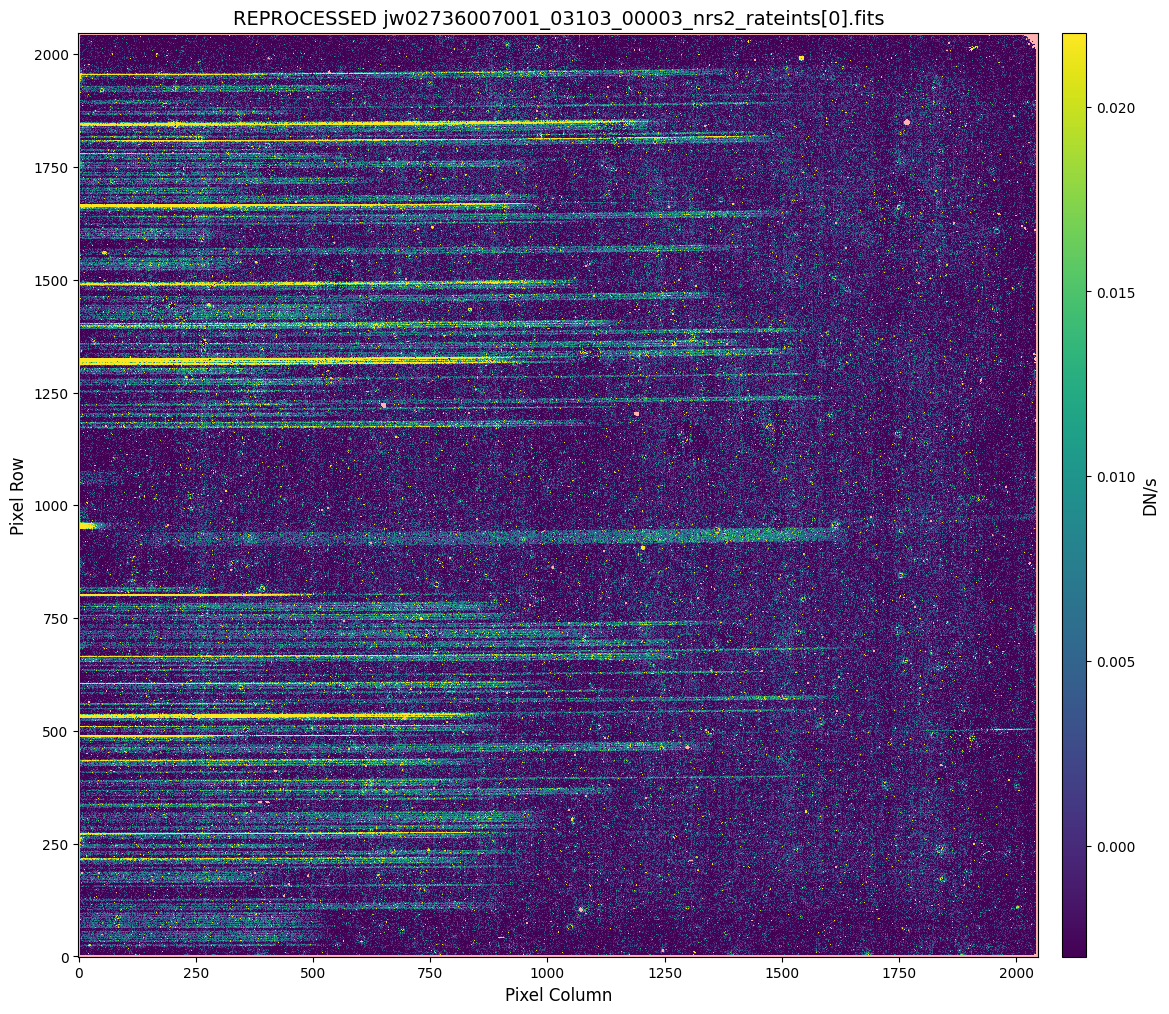

In [45]:
rate_file = rate_sci[-1]  # Show the last rate file, as an example.
display_rate(rate_file, vmin=-0.003, vmax=0.022, scale='linear',
             title_prefix='REPROCESSED')  # , extname='dq')

---

### 8.2 Display `Spec2Pipeline` Products
Inspect the Stage 2 calibrated spectra. 

Draw boxes around the extraction regions for each source in a `_rate.fits` file using the slit information from the corresponding Stage 2 calibrated products (`_cal.fits` or `_s2d.fits`). These boxes should be large enough to accommodate the curved spectral traces. While neighboring boxes may overlap, the spectra themselves do not.

2025-03-04 22:54:15,381 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:407: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(



2025-03-04 22:54:15,475 - stpipe - WARNING - /tmp/ipykernel_3579/3154024895.py:267: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2d[i].legend(fontsize=12)



2025-03-04 22:54:15,574 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:407: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(



2025-03-04 22:54:15,634 - stpipe - WARNING - /tmp/ipykernel_3579/3154024895.py:267: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2d[i].legend(fontsize=12)



2025-03-04 22:54:15,752 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:407: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(



2025-03-04 22:54:15,847 - stpipe - WARNING - /tmp/ipykernel_3579/3154024895.py:267: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2d[i].legend(fontsize=12)



2025-03-04 22:54:15,945 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:407: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(



2025-03-04 22:54:16,005 - stpipe - WARNING - /tmp/ipykernel_3579/3154024895.py:267: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2d[i].legend(fontsize=12)



2025-03-04 22:54:16,125 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:407: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(



2025-03-04 22:54:16,427 - stpipe - WARNING - /tmp/ipykernel_3579/3154024895.py:267: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2d[i].legend(fontsize=12)



2025-03-04 22:54:16,524 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:407: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(



2025-03-04 22:54:16,586 - stpipe - WARNING - /tmp/ipykernel_3579/3154024895.py:267: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2d[i].legend(fontsize=12)



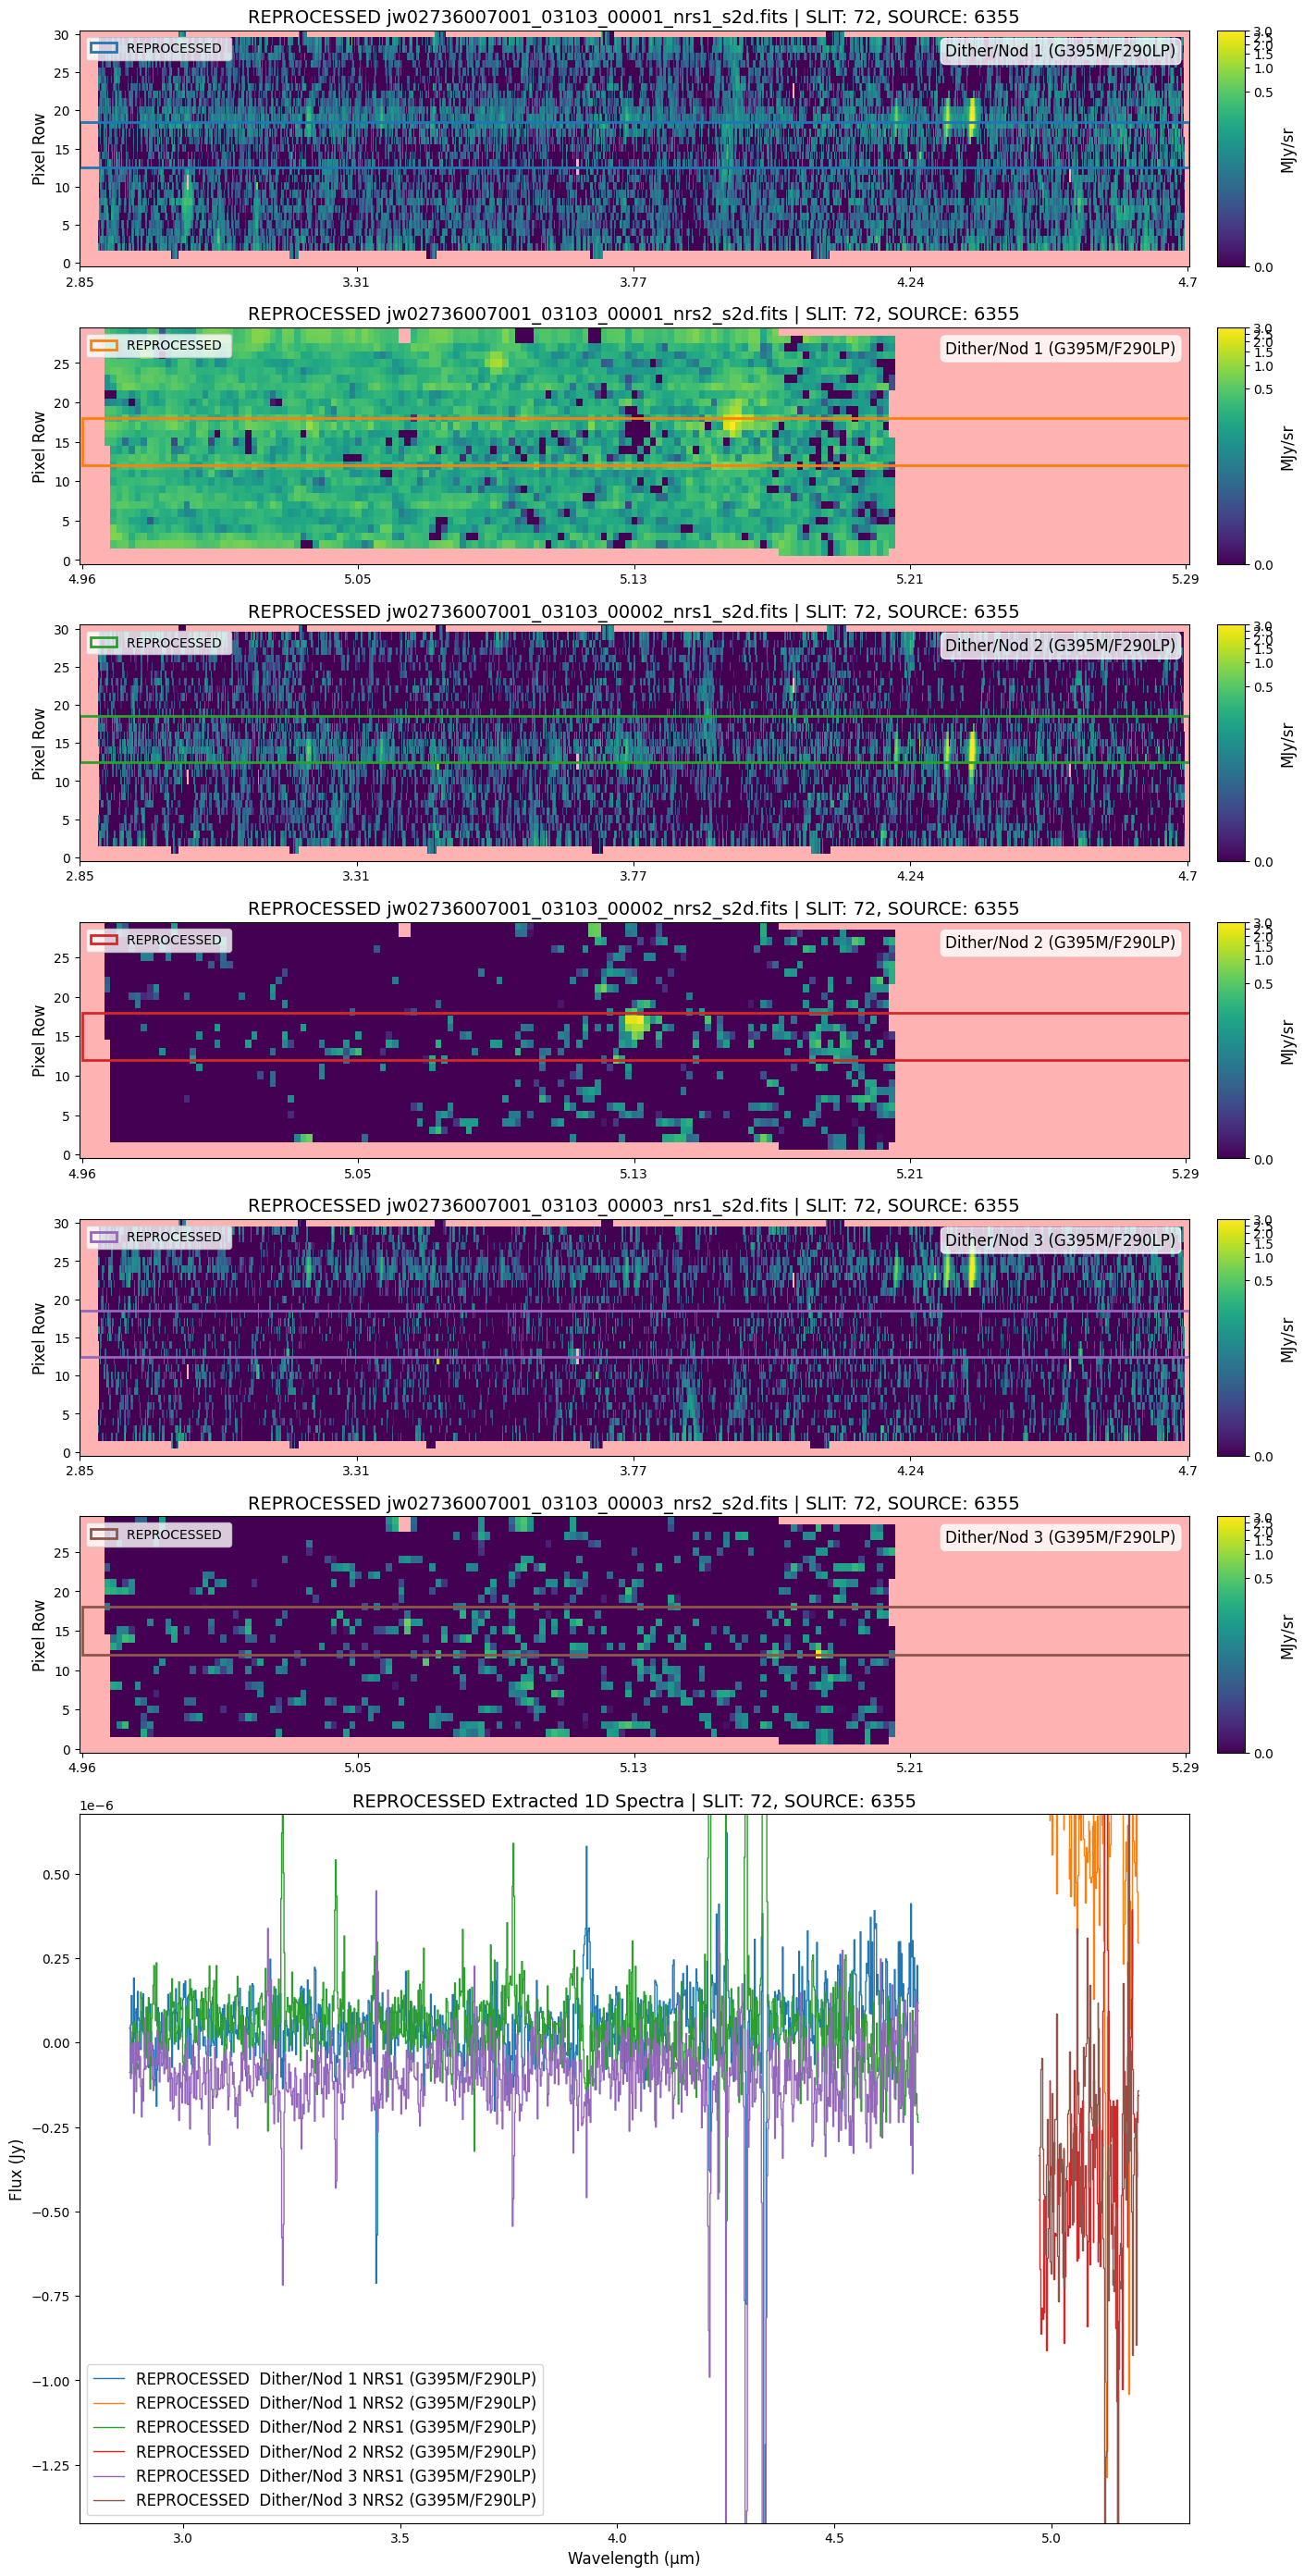

In [46]:
# Display stage 2 products.
display_spectra(sci_s2d + sci_x1d, source_id=source_id, scale='log',
                source_type='POINT', vmin=0, vmax=3, title_prefix='REPROCESSED')

---
### 8.3 Display `Spec3Pipeline` Products
Inspect the Stage 3 combined calibrated spectra. 

<div class="alert alert-block alert-warning">
You need to provide the slit ID and name for the plot to display. Below we provide values that work with the demo data.
</div>

In [47]:
# Select source to inspect. Valid for demo_mode.
if slit_name is None:
    # Using a dummy slit for ploting.
    source_id, slit_name = 6355, '72'
    print(f"Warning: plotting slit for source ID: "
          f"{source_id} and slit name: {slit_name}")

2025-03-04 22:54:18,306 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:407: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(



2025-03-04 22:54:18,406 - stpipe - WARNING - /tmp/ipykernel_3579/3154024895.py:267: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2d[i].legend(fontsize=12)



147
Expanding wavelength gap 4.70 -- 4.96 μm


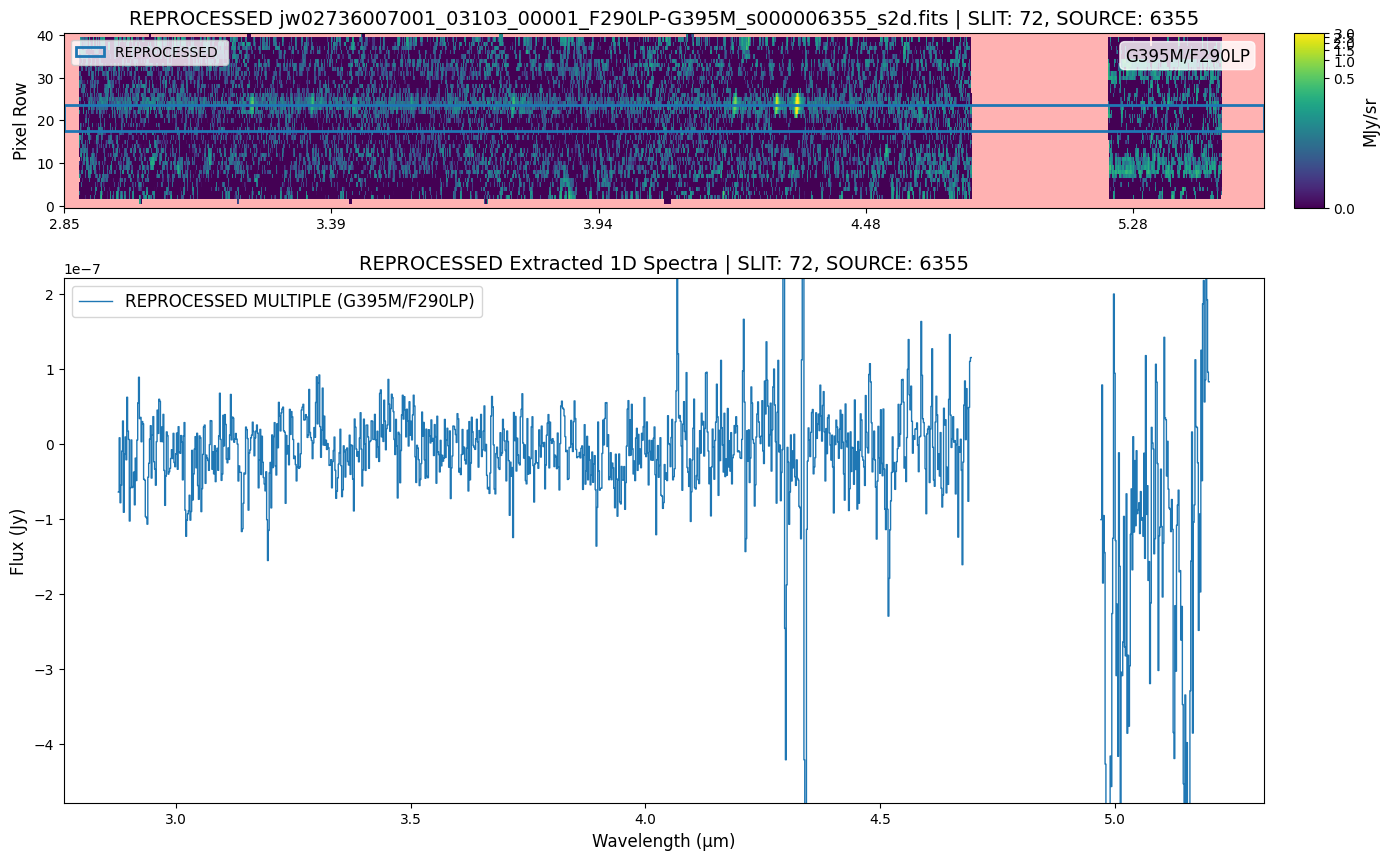

In [48]:
# Display stage 3 products.
display_spectra(stage3_s2d + stage3_x1d, source_id=source_id, scale='log',
                source_type='POINT', vmin=0, vmax=3,
                title_prefix='REPROCESSED', is_stage3=True)

Note in the demo data, the default extraction region misses the positive signal for this 5-shutter slitlet target and instead extracts negative signal from one of the nod subtractions. A workaround in [Section 9](#9.-Modifying-the-EXTRACT1D-Reference-File-(as-needed)) is provided.

---

## 9. Modifying the EXTRACT1D Reference File (as needed)
[extract_1d](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d) •
[Editing JSON reference file](https://jwst-pipeline.readthedocs.io/en/latest/jwst/extract_1d/reference_files.html#editing-json-reference-file-format-for-non-ifu-data)

The `extract_1d` step's `use_source_pos` parameter in Stage 2 generally centers the 1D extraction box on the actual source location effectively and thus doesn't usually require manual adjustment. However, in some cases, adjusting the position of the extraction box by modifying the EXTRACT1D reference file may be useful. The following section demonstrates how to modify which rows in the 2D spectrum (S2D) are used for extracting the 1D spectrum (X1D).

The EXTRACT1D reference file, along with several other parameter files, can be found in the `CRDS_PATH` directory. While some files, like `.json` files, can be manually edited, we modify them using Python.

<div class="alert alert-block alert-danger">

**Warning**: Currently, there is no aperture correction in place for NIRSpec, so the `extract_width` parameter **MUST** remain unchanged (6 pixels wide) to ensure proper flux calibration! The extraction box limits (`ystart` and `ystop`) can be modified; however, if `ystart` and `ystop` do not match the `extract_width`, the `extract_width` takes precedence and is applied symmetrically around the midpoint between `ystart` and `ystop`.

</div>

In [49]:
# Modify the EXTRACT1D reference file.

# If you don't know the reference file name this should work.
# extract_1d_ref = Spec3Pipeline().get_reference_file(stage3_s2d, 'extract1d')

refs = api.dump_references(crds_client.get_context_used('jwst'),
                           ['jwst_nirspec_extract1d_0009.json'])
extract_1d_ref = refs['jwst_nirspec_extract1d_0009.json']

# Open EXTRACT1D reference file in read-mode.
with open(extract_1d_ref, "r") as ref_file:
    params = json.load(ref_file)

    # All of these values are zero-indexed integers.
    # The start and stop limits are inclusive.

    # ANY MOS SLITLET
    params["apertures"][0]["extract_width"] = 6
    params["apertures"][0]["ystart"] = 22
    params["apertures"][0]["ystop"] = 27

# Write changes to a new file.
newData = json.dumps(params, indent=4)
# Add the suffix '_fs' to distinguish the file from the default version.
basename = os.path.basename(extract_1d_ref)[:-5]
extract_1d_ref_mod = os.path.join(spec3_dir, basename + "_mos.json")
with open(extract_1d_ref_mod, "w") as file:
    file.write(newData)

In [50]:
# Inspect the EXTRACT1D reference file.
with open(extract_1d_ref_mod, 'r') as f_obj:
    extract_1d_ref_mod_data = json.load(f_obj)

JSON(extract_1d_ref_mod_data, expanded=True)

<IPython.core.display.JSON object>

Rerun Extract1d step using the new EXTRACT1D reference file.

In [51]:
for s2d in stage3_s2d:
    Extract1dStep.call(s2d,
                       save_results=True,
                       output_dir=spec3_dir,
                       output_use_model=True,
                       suffix='x1d_mod',  # Default suffix is `_extract1dstep.fits`
                       use_source_posn=False,
                       override_extract1d=extract_1d_ref_mod)

2025-03-04 22:54:19,037 - stpipe.Extract1dStep - INFO - Extract1dStep instance created.


2025-03-04 22:54:19,241 - stpipe.Extract1dStep - INFO - Step Extract1dStep running with args ('/home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage3/jw02736007001_03103_00001_F290LP-G395M_s000006355_s2d.fits',).


2025-03-04 22:54:19,245 - stpipe.Extract1dStep - INFO - Step Extract1dStep parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage3/
  output_ext: .fits
  output_use_model: True
  output_use_index: True
  save_results: True
  skip: False
  suffix: x1d_mod
  search_output_file: True
  input_dir: ''
  subtract_background: None
  apply_apcorr: True
  use_source_posn: False
  smoothing_length: None
  bkg_fit: None
  bkg_order: None
  log_increment: 50
  save_profile: False
  save_scene_model: False
  center_xy: None
  ifu_autocen: False
  bkg_sigma_clip: 3.0
  ifu_rfcorr: False
  ifu_set_srctype: None
  ifu_rscale: None
  ifu_covar_scale: 1.0
  soss_atoca: True
  soss_threshold: 0.01
  soss_n_os: 2
  soss_wave_grid_in: None
  soss_wave_grid_out: None
  soss_estimate: None
  soss_rtol: 0.0001
  soss_max_grid_size: 20000
  soss_tikfac: None
  soss_wid

2025-03-04 22:54:19,449 - stpipe.Extract1dStep - INFO - Using EXTRACT1D reference file /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage3/jwst_nirspec_extract1d_0009_mos.json


2025-03-04 22:54:19,511 - stpipe.Extract1dStep - INFO - Using APCORR file /home/runner/crds_cache/references/jwst/nirspec/jwst_nirspec_apcorr_0004.fits


2025-03-04 22:54:19,544 - stpipe.Extract1dStep - INFO - Processing spectral order -1


2025-03-04 22:54:19,546 - stpipe.Extract1dStep - INFO - Aperture start/stop: 22.00 -> 27.00 (inclusive)


2025-03-04 22:54:19,602 - stpipe.Extract1dStep - INFO - Results used CRDS context: jwst_1322.pmap


2025-03-04 22:54:19,674 - stpipe.Extract1dStep - INFO - Saved model in /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/NIRSPEC/MOS/mos_data_02736/Obs007/stage3/jw02736007001_03103_00001_F290LP-G395M_s000006355_x1d_mod.fits


2025-03-04 22:54:19,675 - stpipe.Extract1dStep - INFO - Step Extract1dStep done


2025-03-04 22:54:19,675 - stpipe - INFO - Results used jwst version: 1.17.1


2025-03-04 22:54:19,927 - stpipe - WARNING - /opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/astropy/stats/sigma_clipping.py:407: AstropyUserWarning: Input data contains invalid values (NaNs or infs), which were automatically clipped.
  warnings.warn(



2025-03-04 22:54:20,025 - stpipe - WARNING - /tmp/ipykernel_3579/3154024895.py:267: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2d[i].legend(fontsize=12)



147
Expanding wavelength gap 4.70 -- 4.96 μm
147
Expanding wavelength gap 4.70 -- 4.96 μm


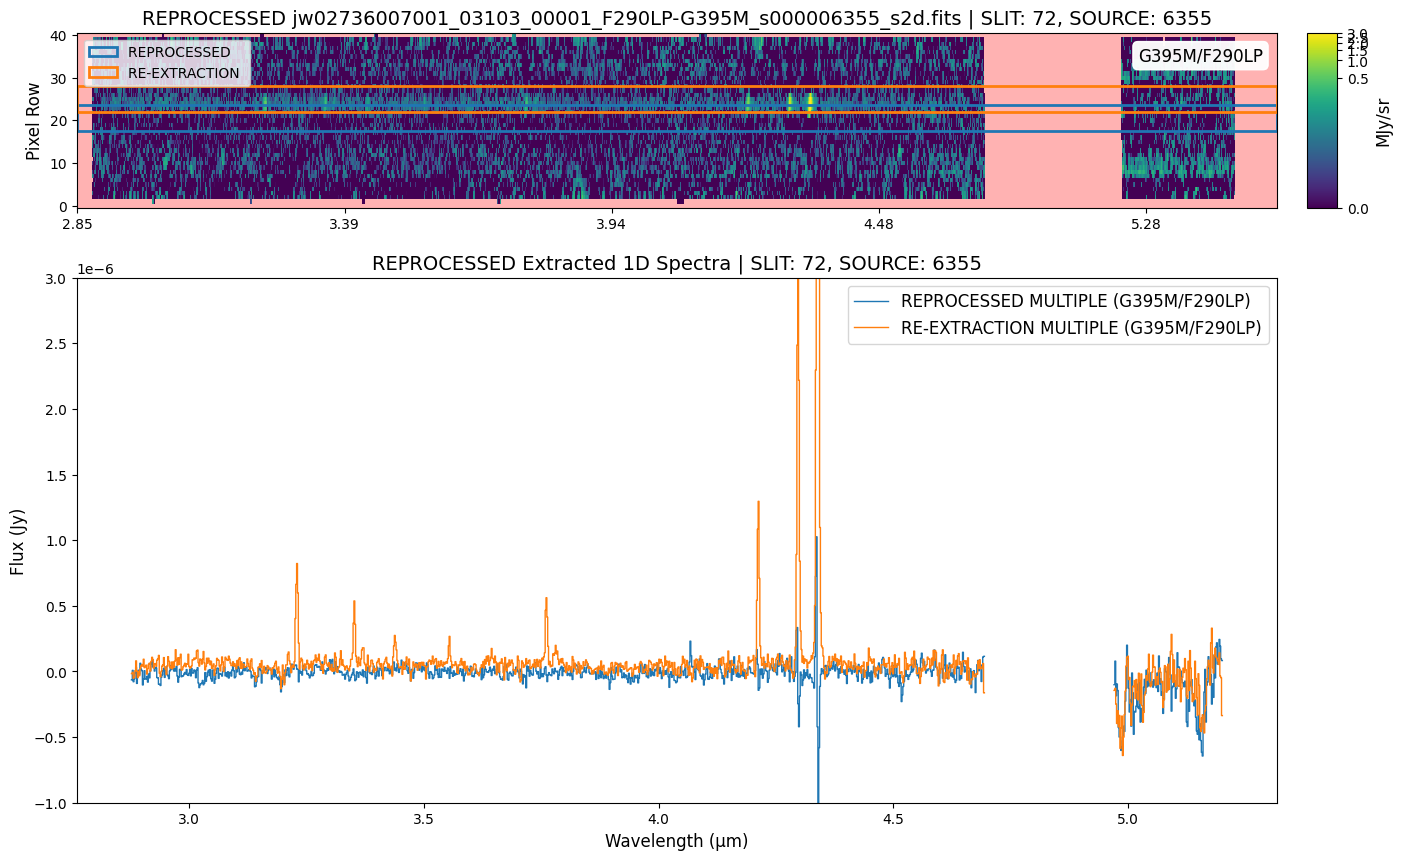

In [52]:
stage3_x1ds_mod = sorted(glob.glob(spec3_dir + '*_x1d_mod.fits'))
display_spectra(stage3_s2d + stage3_x1d, compare_x1d=stage3_x1ds_mod,
                source_id=source_id, source_type='POINT', scale='log',
                vmin=0, vmax=3, y_limits=(-1e-6, 0.3e-5),
                title_prefix='REPROCESSED', is_stage3=True)

---
## Related Notebooks
* [NIRSpec Workaround Notebooks](https://github.com/spacetelescope/jwst-caveat-examples/tree/main/NIRSPEC_General)
* [JDAT: JWST Data Analysis Example Notebooks](https://github.com/spacetelescope/jdat_notebooks/tree/main/notebooks)
* Notebooks running pipeline on simulated NIRSpec MOS data:
[JWebbinar7 (Oct 2021)](https://github.com/spacetelescope/jwebbinar_prep/blob/webbinar7/mos_session/jwebbinar7_nirspecmos.ipynb) •
[JDAT (2021)](https://github.com/spacetelescope/dat_pyinthesky/blob/main/jdat_notebooks/mos-spectroscopy/MOSspec_sv06_revised.ipynb) •
[JADES (June 2022)](https://github.com/eclake/NIRSpec_GTO_sims_STScI_reduction/blob/master/NIRSpec%20GTO%20IPS%20Simultions.ipynb)
* [Notebook processing ERO SMACS0723 NIRSpec MOS data](https://github.com/gbrammer/msaexp/blob/main/docs/examples/process-smacs0723.ipynb)
using the JWST pipeline and
[msaexp](https://github.com/gbrammer/msaexp)
* [MOSViz notebook analyzing NIRSpec MOS spectra](https://spacetelescope.github.io/jdat_notebooks/notebooks/mos_spectroscopy_advanced/MOSspec_advanced.html)
* [Optimal extraction](https://spacetelescope.github.io/jdat_notebooks/notebooks/optimal_extraction/Spectral_Extraction-static.html)

---

<figure>
       <img src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo\" align="right" style="width: 200px"/>
</figure>

[Top of Page](#NIRSpec-MOS-Pipeline-Notebook)